参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Thu Dec 29 18:42:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   45C    P0    40W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100

cfg_pseudo_sim_max = cfg_pseudo_max
cfg_pseudo_sim_min = cfg_pseudo_min
#cfg_pseudo_sim_max = 0.8
#cfg_pseudo_sim_min = 0.4
#cfg_pseudo_sim_max = 0.0
#cfg_pseudo_sim_min = 0.0

cfg_pseudo_real_max = cfg_pseudo_max
cfg_pseudo_real_min = cfg_pseudo_min

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

# ==============================================================
# kqi_3090_ex075_v2 base Parameters
# ==============================================================
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1

cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
#is_trn_allfold = True
#DEBUG = False
# ==============================================================

# ==============================================================
# kqi_3090_ex075_v2_tta_v3_miximp_hvflip_pseudo_lb0771_1000_simall_100ep Parameters
# ==============================================================
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 1.0 
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = 0.0
cfg_pseudo_real_max = -1
epochs = 100
# ==============================================================

#PSEUDO_CSV = "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv"
#PSEUDO_CSV = "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_ver25_lb0777.csv"

DEL_Outlier_Pseudo_MEAN_TH = 0
#DEL_Outlier_Pseudo_MEAN_TH = 5

DEL_Outlier_Pseudo_STD_TH = 0
#DEL_Outlier_Pseudo_STD_TH = 10

## pseudo全部入れる
#cfg_pseudo_max = 0.0
#cfg_pseudo_min = 1.0
#cfg_pseudo_sim_max = -1
#cfg_pseudo_real_max = -1

## pseudo sim全部入れる+real[<0.1,>0.9]だけ入れる
#cfg_pseudo_max = 0.9
#cfg_pseudo_min = 0.1
#cfg_pseudo_sim_max = 0
#cfg_pseudo_real_max = 0.9
#cfg_pseudo_real_min = 0.1

cfg_alb_norm_mean_th = 0  # albで画像正規化しない
#cfg_alb_norm_mean_th = DEL_Outlier_Pseudo_MEAN_TH  # これ以上の h1_mean+l1_mean を取る画像は除いて統計値出してalbで正規化する。
#cfg_alb_norm_mean_th = 1000000  # 全データで正規化

cfg_alb_norm_std_th = 0  # albで画像正規化しない
#cfg_alb_norm_std_th = DEL_Outlier_Pseudo_STD_TH  # これ以上の h1_std+l1_std を取る画像は除いて統計値出してalbで正規化する。trainの h1_std,l1_std は 0.42 ぐらいがmax値
#cfg_alb_norm_std_th = 1000000  # 全データで正規化

ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800, EX007_NONSTAT_NOISE800, EX009_NOISE_ART]"
ADD_PSEUDO_DIRS = ""

model_cls = "CustomModelMultiOutputStride12"
BATCH_SIZE = 48

cfg_prob_gauss_noise = 0.0
cfg_prob_gauss_noise = 0.5
cfg_min_snr = 5
cfg_max_snr = 20
#cfg_min_snr = 15  # https://github.com/analokmaus/kaggle-g2net-public/blob/main/configs.py
#cfg_max_snr = 30

add_name = ""

In [4]:
# Parameters
add_name = "_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 0.0
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = -1
cfg_pseudo_real_max = -1
epochs = 100
cfg_alb_norm_mean_th = 5
cfg_alb_norm_std_th = 10
DEL_Outlier_Pseudo_MEAN_TH = 5
DEL_Outlier_Pseudo_STD_TH = 10
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800, EX007_NONSTAT_NOISE800, EX007_NONSTAT_NOISE1000]"
ADD_PSEUDO_DIRS = ""
model_cls = "CustomModelMultiOutputStride12"
BATCH_SIZE = 48
cfg_prob_gauss_noise = 0.5
cfg_min_snr = 5
cfg_max_snr = 20
is_trn_allfold = True
is_wandb = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
import os
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    if "/kqi/output" in os.getcwd():
        NAME = f"kqi_3090_ex075_v2{add_name}"
    else:
        NAME = f"3090_kqi_ex075_v2{add_name}"
print(NAME)

kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX007_NONSTAT_NOISE1200 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1200"  # HDD 1200件
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    EX009_NOISE_ART = f"/volume/kaggle/g2net2/pyfstat_output/ex009_generating_noise_artifacts_n_len3"  # HDD 150件ぐらい
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX007_NONSTAT_NOISE1200 = f"{_dir}/ex007_generating_noise_nonstationary1200"  # HDD 1200件
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # SSD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # SSD 400件
    EX009_NOISE_ART = f"{_dir}/ex009_generating_noise_artifacts_n_len3"  # SSD 150件ぐらい
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
train_df["h1_l1_mean"] = train_df["h1_mean"] + train_df["l1_mean"]
train_df["h1_l1_std"] = train_df["h1_std"] + train_df["l1_std"]

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

# リアルデータとシュミレーションデータのフラグ
_real_sim_flags = test_df["h1_stddiff"] + test_df["l1_stddiff"]
_real_sim_flags = _real_sim_flags.to_numpy()
test_df["real_sim"] = np.array([1 if _f > 0 else 0 for _f in _real_sim_flags])  # リアルデータ=1,シュミレーションデータ=0
print("test real_sim_flags:")
print(test_df["real_sim"].value_counts())

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
test_df["h1_l1_mean"] = test_df["h1_mean"] + test_df["l1_mean"]
test_df["h1_l1_std"] = test_df["h1_std"] + test_df["l1_std"]


train_df.shape: (600, 22)
9.0 1.0
test real_sim_flags:
0    6478
1    1497
Name: real_sim, dtype: int64
test_df.shape: (7975, 29)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 32)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (10193, 24)


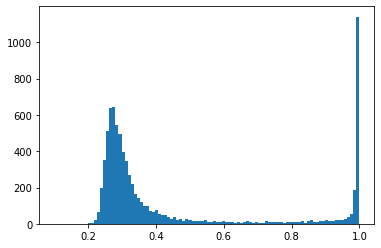

In [13]:
pseudo_df = pd.read_csv(PSEUDO_CSV)
plt.hist(pseudo_df["target"], bins=100, label="use target_real")
plt.show()

np.clip(pseudo_df['target'], 0.2, None)
10.0 0.0
(7975, 32)
(7327, 32)


0    6478
1     849
Name: real_sim, dtype: int64


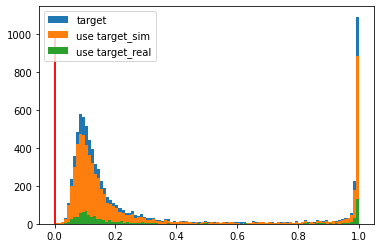

pseudo_df.shape: (7327, 32)


In [14]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    if PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.771のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver18_lb0772.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.772のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv":
        print("np.clip(pseudo_df['target'], 0.21, None)")
        # lb0.774のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.21, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver25_lb0777.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
    
    pseudo_df = pd.merge(pseudo_df, test_df[["id", "real_sim"]], on="id")
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 分布可視化
    plt.hist(pseudo_df["target"], bins=100, label="target")
    
    p_sim_df = pseudo_df[pseudo_df["real_sim"] == 0].copy()
    p_real_df = pseudo_df[pseudo_df["real_sim"] == 1].copy()
    
    # 確信度が高い低いものだけ採用。0なら全部入れる
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
        
    # simデータが高い低いものだけ採用
    if cfg_pseudo_sim_max > 0:
        p_sim_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_sim_max) | (p_sim_df["target"] < cfg_pseudo_sim_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == -1:
        # -1なら追加なし
        pass
        
    # realデータが高い低いものだけ採用
    if cfg_pseudo_real_max > 0:
        p_real_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_real_max) | (p_sim_df["target"] < cfg_pseudo_real_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == -1:
        # -1なら追加なし
        pass
        
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())

    # 振幅が外れ値のpseudo_label除く
    if (DEL_Outlier_Pseudo_MEAN_TH > 0) or (DEL_Outlier_Pseudo_STD_TH > 0):
        print(pseudo_df.shape)
        pseudo_df = pseudo_df[
            (pseudo_df["h1_l1_mean"] <= DEL_Outlier_Pseudo_MEAN_TH)
            & (pseudo_df["h1_l1_std"] <= DEL_Outlier_Pseudo_STD_TH)
        ].reset_index(drop=True)
        print(pseudo_df.shape)
        display(
            pseudo_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]]
            .describe()
            .style.background_gradient(cmap="Blues")
        )
        print(pseudo_df["real_sim"].value_counts())
        
    # 分布可視化
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==0, "target"], bins=100, label="use target_sim")
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==1, "target"], bins=100, label="use target_real")
    plt.vlines(cfg_pseudo_max, 0, 1000, colors="red")
    plt.vlines(cfg_pseudo_min, 0, 1000, colors="red")
    plt.legend()
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

In [15]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        _add_df = pd.merge(_add_df, _sum_df, on="id")
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

In [16]:
#=====

In [17]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [18]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        if isinstance(p, torch.Tensor):
            p = p.numpy()
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [19]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [20]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/workspace/g2net2/input/train/02887d232.hdf5
img.max(), img.min(): 0.9832806 -0.19115533
img.shape: (2, 360, 127)
y: 1


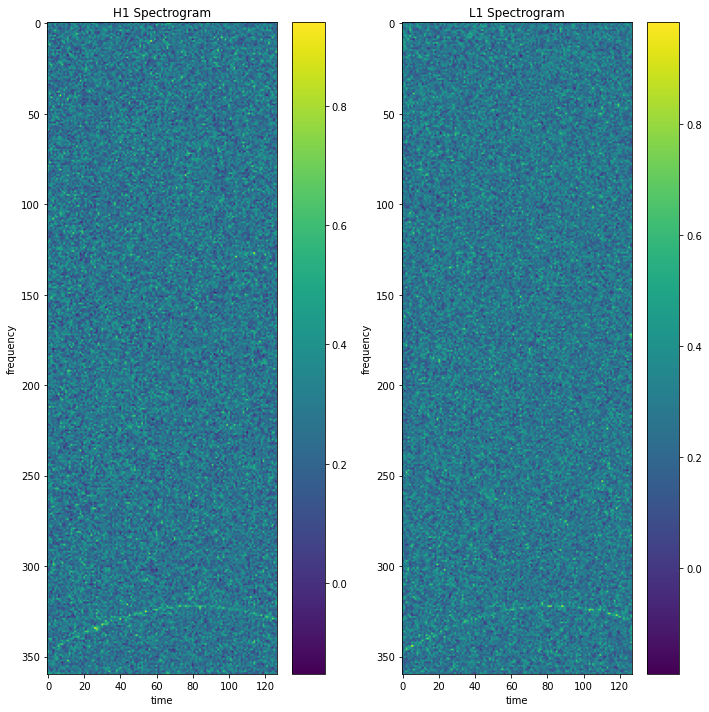

[[[0.36476544 0.2102918  0.33968183 ... 0.2389567  0.13265787 0.38727215]
  [0.27185956 0.43851343 0.2305968  ... 0.2557807  0.23621419 0.16354166]
  [0.14917201 0.26660788 0.2768124  ... 0.30809733 0.2490804  0.25764975]
  ...
  [0.28188577 0.26452792 0.02045513 ... 0.10047743 0.16484646 0.27256674]
  [0.28981844 0.39076617 0.14893036 ... 0.40815973 0.33954537 0.04227973]
  [0.52583796 0.4739412  0.4670277  ... 0.3011122  0.3313775  0.2952881 ]]

 [[0.15093154 0.268492   0.16885146 ... 0.2802165  0.2595052  0.24155816]
  [0.52174765 0.26768965 0.448552   ... 0.5394857  0.35234103 0.29309353]
  [0.2148019  0.2631178  0.4841211  ... 0.2054769  0.3976237  0.3071018 ]
  ...
  [0.22830552 0.2292185  0.09281849 ... 0.19478895 0.26972657 0.22048882]
  [0.08123234 0.36916366 0.59807014 ... 0.37764758 0.16507976 0.42040202]
  [0.22836936 0.31907192 0.24057075 ... 0.21703017 0.42180988 0.36079645]]]

/kqi/output/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
img.max(), img.m

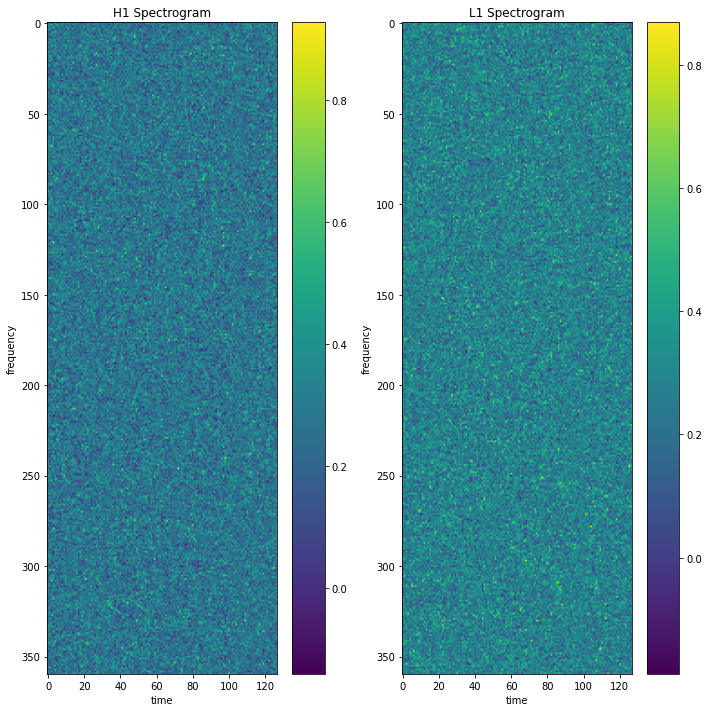

[[[0.15140726 0.3699351  0.03747915 ... 0.25099555 0.299726   0.45655924]
  [0.46434325 0.31688216 0.6097888  ... 0.52993435 0.05745443 0.27874893]
  [0.33954698 0.35181203 0.28139135 ... 0.41537544 0.1638916  0.30018988]
  ...
  [0.1896306  0.0373034  0.28357872 ... 0.177889   0.00305176 0.38669163]
  [0.40564936 0.3487896  0.32136172 ... 0.47659233 0.35656196 0.26858723]
  [0.19057624 0.3520654  0.08455751 ... 0.39749077 0.1377794  0.20426433]]

 [[0.44073486 0.3425733  0.18189248 ... 0.21655002 0.17091742 0.11951497]
  [0.274204   0.37530077 0.23546007 ... 0.39821234 0.34354654 0.19146322]
  [0.5105909  0.20656785 0.35895506 ... 0.4215549  0.10597873 0.14919433]
  ...
  [0.26202965 0.28474206 0.28197297 ... 0.35169542 0.39443088 0.16361763]
  [0.17399748 0.32649195 0.40146378 ... 0.05472276 0.30917156 0.24041884]
  [0.14453216 0.19500327 0.34653983 ... 0.35616863 0.3727349  0.26498753]]]


In [21]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

/workspace/g2net2/input/train/02887d232.hdf5
(2, 360, 127)


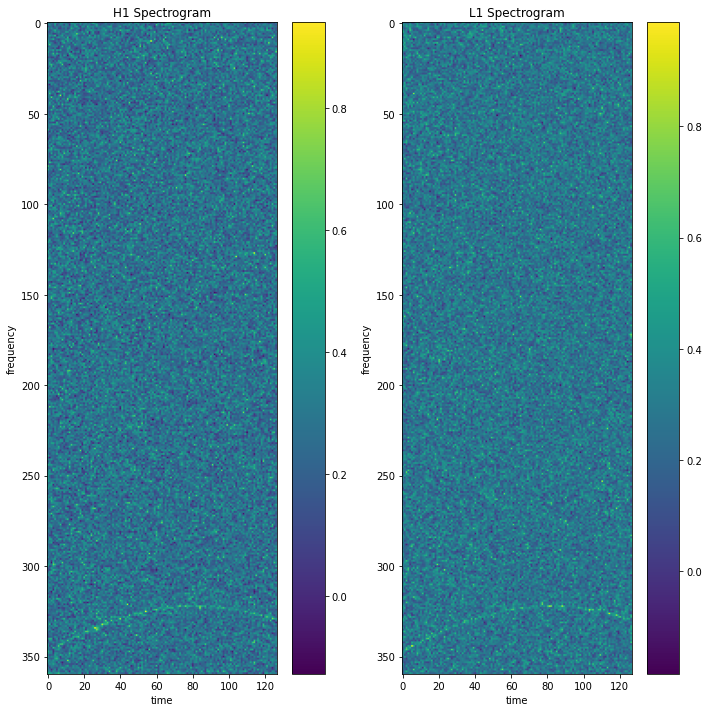

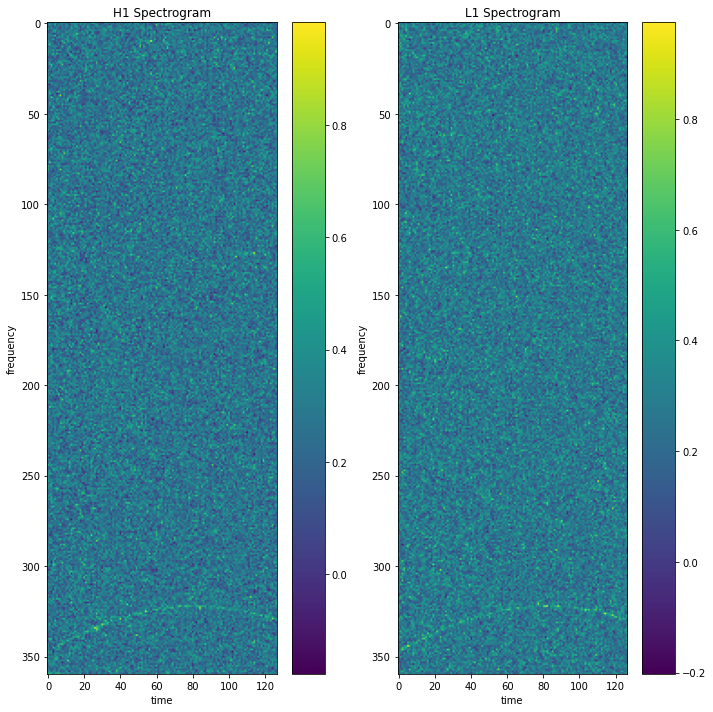

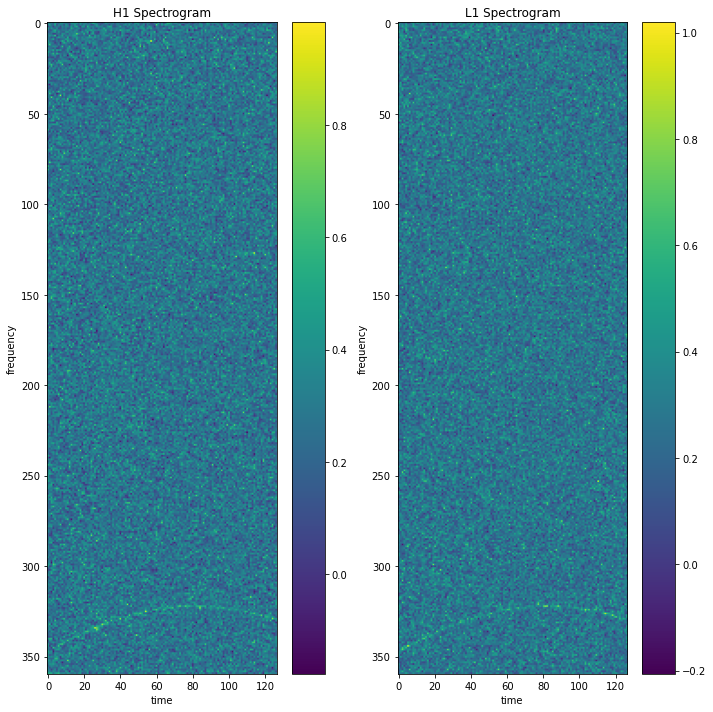

In [22]:
%reload_ext autoreload
%autoreload 2
from src import audio_augments

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )

xxx = img.copy()
print(xxx.shape)
show_1img_2ch(img)

_transform = audio_augments.GaussianNoiseSNR(min_snr=15, max_snr=30, p=1.0)  # https://github.com/analokmaus/kaggle-g2net-public/blob/main/configs.py
#_transform = audio_augments.GaussianNoiseSNR(min_snr=5.0, max_snr=20.0, p=1.0)
xxx = _transform(xxx)
show_1img_2ch(xxx)
xxx[1] = _transform(xxx[1])
show_1img_2ch(xxx)

In [23]:
#%debug

In [24]:
#=====

# To npy

In [25]:
#!rm -r {NPY_DIR}/{normalize_type}

In [26]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /workspace/g2ne

In [27]:
#=====

# Libraries

In [28]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.1+cu117


In [29]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [30]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [31]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [32]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        
        # これ以上の h1_mean+l1_mean, h1_std+l1_std を取る画像は除いて統計値出し、その統計値でalbの正規化行う
        self.alb_norm_mean_th = cfg_alb_norm_mean_th 
        self.alb_norm_std_th = cfg_alb_norm_std_th  
        
        # GaussianNoiseSNR行う確率, ノイズの大きさ
        self.prob_gauss_noise = cfg_prob_gauss_noise
        self.max_snr = cfg_max_snr
        self.min_snr = cfg_min_snr

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
#    train_df = cv_split(train_df, 0, 10, cv_col="target")
#    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
#    print("debug train_df.shape:", train_df.shape)
#    test_df = test_df.iloc[:30]
#    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 100,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800, '
                 'EX007_NONSTAT_NOISE800, EX007_NONSTAT_NOISE1000]',
 'add_pseudo_dirs': '',
 'add_split_str': 'StratifiedKFold',
 'alb_norm_mean_th': 5,
 'alb_norm_std_th': 10,
 'apex': True,
 'batch_size': 48,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 100,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogits

# Utils

In [33]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [34]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [35]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                 prob_gauss_noise=0.0,
                 min_snr=CFG.min_snr,
                 max_snr=CFG.max_snr,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )
        
        # GaussianNoiseSNR行う確率, ノイズの大きさ
        self.prob_gauss_noise = prob_gauss_noise  
        self.min_snr = min_snr,
        self.max_snr = max_snr
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)
            
        # ===============================================
        # GaussianNoiseSNR
        # ===============================================
        if self.prob_gauss_noise:
            _transform = audio_augments.GaussianNoiseSNRTorch(min_snr=self.min_snr, 
                                                              max_snr=self.max_snr, 
                                                              p=self.prob_gauss_noise)  
            img = _transform(img)
            #print("GaussianNoiseSNR")

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# calc_mean_std

In [36]:
%reload_ext autoreload
%autoreload 2
from src import calc_mean_std

_df = pd.concat([train_df, test_df])
print(_df.shape)

# 外れ値のデータは除く
_df = _df[
    (_df["h1_l1_mean"] <= CFG.alb_norm_mean_th)
    & (_df["h1_l1_std"] <= CFG.alb_norm_std_th)
].reset_index(drop=True)
print(_df.shape)
display(_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]].describe().style.background_gradient(cmap="Blues"))

_dataset = TrainDataset(_df, 
                        is_npy=CFG.is_npy, 
                        is_add_ch=CFG.is_add_ch,)
_loader = DataLoader(_dataset, 
                     #batch_size=CFG.batch_size * 2, # batch_size=1でないとだめ
                     shuffle=False, 
                     num_workers=CFG.num_workers, pin_memory=False, drop_last=False)
X_MEAN, X_STD, X_MAX = calc_mean_std.calc_mean_std_max(_dataset, _loader, N_CHANNELS=CFG.ch)

(8575, 33)
(7927, 33)


==> Computing mean and std..


100%|██████████████████████████████████████████████████████████████████████████████| 7927/7927 [3:21:34<00:00,  1.53s/it]

mean, std, max: [0.2797384  0.27972412] [0.12301076 0.12294598] [2.8376431 2.6048286]


# Transform

In [37]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    elif data == 'train_norm':
        print("train_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    elif data == 'valid_norm':
        print("valid_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [38]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


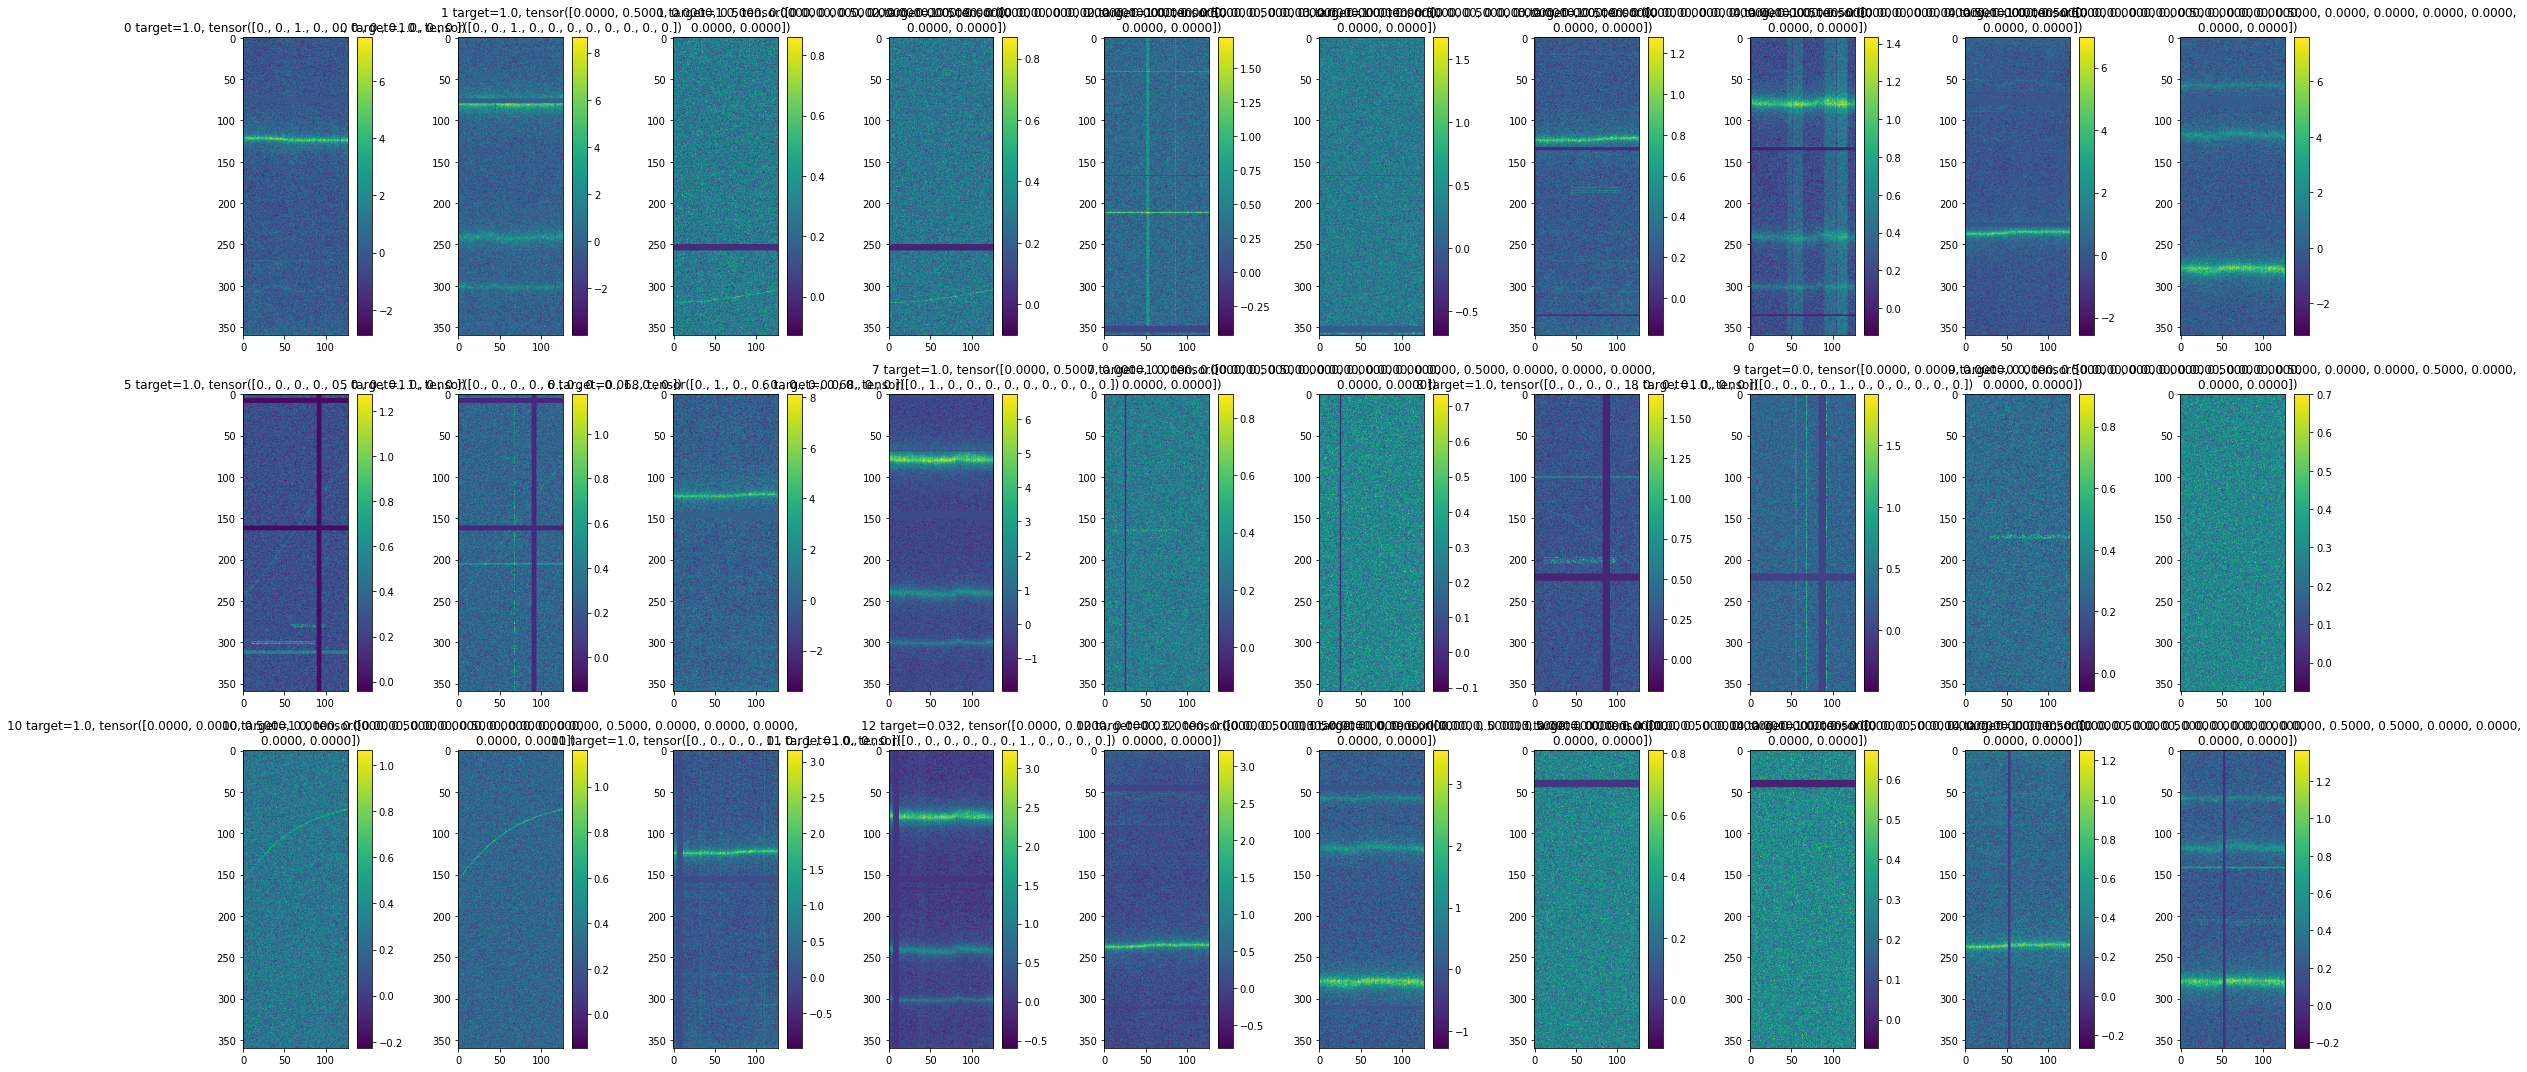

In [39]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        #transforms=get_transforms(data="train_norm"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
        prob_gauss_noise=1,#CFG.prob_gauss_noise,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #    prob_gauss_noise=1.0,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [40]:
#%debug

In [41]:
#=====

# Model

In [42]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [43]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [44]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [45]:
class CustomModelMultiOutputDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch,
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutputDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [46]:
from src import layer_edit
class CustomModelMultiOutputStride12(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)
        
        # 最初の conv レイヤーのモデル ストライドをfirst_strideに変更
        self.net = layer_edit.patch_first_conv_stride(self.net, first_stride=(1,2))
        
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // cfg.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

In [47]:
from src import layer_edit
class CustomModelMultiOutputStride11(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)
        
        # 最初の conv レイヤーのモデル ストライドをfirst_strideに変更
        self.net = layer_edit.patch_first_conv_stride(self.net, first_stride=(1,1))
        
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // cfg.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2


In [48]:
#=====

In [49]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [50]:
#=====

In [51]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [52]:
#=====

In [53]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [54]:
#=====

In [55]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [56]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [57]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [58]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [59]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [60]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [61]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            train_transforms_type = 'train_norm'
            valid_transforms_type = 'valid_norm'
        else:
            train_transforms_type = 'train'
            valid_transforms_type = 'valid'
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data=train_transforms_type), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                     prob_gauss_noise=CFG.prob_gauss_noise,
                                     min_snr=CFG.min_snr,
                                     max_snr=CFG.max_snr,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data=valid_transforms_type),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [62]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (10193, 24)
pseudo_df.shape: (7327, 32)


> SEEDING DONE
fold0: (2039,)
fold1: (2039,)
fold2: (2039,)
fold3: (2038,)
fold4: (2038,)
fold  target
0     0         1239
      1          800
1     0         1239
      1          800
2     0         1239
      1          800
3     0         1238
      1          800
4     0         1238
      1          800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (18120, 40)
========== fold: 0, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/332] Elapsed 0m 4s (remain 25m 27s) Loss: 1.5482(1.5482) Grad: 52508.1445  LR: 4.0000e-06  
Epoch: [1][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.5243(1.5336) Grad: 54329.3594  LR: 4.0000e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 30s) Loss: 1.5568(1.5568) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.5033(1.5342) 


Epoch 1 - avg_train_loss: 1.5336  avg_val_loss: 1.5342  time: 173s
Epoch 1 - Score: 0.6413
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6413 Model
Epoch 1 - Save Best Loss: 1.5342 Model


Epoch: [2][0/332] Elapsed 0m 2s (remain 14m 0s) Loss: 1.5274(1.5274) Grad: 53834.4688  LR: 1.3600e-04  
Epoch: [2][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3868(1.4062) Grad: 49507.9648  LR: 1.3600e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.2392(1.2392) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3076(1.3246) 


Epoch 2 - avg_train_loss: 1.4062  avg_val_loss: 1.3246  time: 172s
Epoch 2 - Score: 0.8303
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8303 Model
Epoch 2 - Save Best Loss: 1.3246 Model


Epoch: [3][0/332] Elapsed 0m 2s (remain 12m 48s) Loss: 1.3702(1.3702) Grad: 51817.9727  LR: 2.6800e-04  
Epoch: [3][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3565(1.3763) Grad: 42822.4023  LR: 2.6800e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2045(1.2045) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1933(1.2859) 


Epoch 3 - avg_train_loss: 1.3763  avg_val_loss: 1.2859  time: 170s
Epoch 3 - Score: 0.8553
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8553 Model
Epoch 3 - Save Best Loss: 1.2859 Model


Epoch: [4][0/332] Elapsed 0m 2s (remain 11m 39s) Loss: 1.3465(1.3465) Grad: 32283.9922  LR: 4.0000e-04  
Epoch: [4][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3456(1.3773) Grad: 11060.5479  LR: 4.0000e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2854(1.2854) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2542(1.3062) 


Epoch 4 - avg_train_loss: 1.3773  avg_val_loss: 1.3062  time: 169s
Epoch 4 - Score: 0.8593
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8593 Model


Epoch: [5][0/332] Elapsed 0m 2s (remain 13m 34s) Loss: 1.4319(1.4319) Grad: 51096.0977  LR: 3.9990e-04  
Epoch: [5][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3883(1.3662) Grad: 11502.9287  LR: 3.9990e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.2178(1.2178) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1822(1.2700) 


Epoch 5 - avg_train_loss: 1.3662  avg_val_loss: 1.2700  time: 170s
Epoch 5 - Score: 0.8679
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8679 Model
Epoch 5 - Save Best Loss: 1.2700 Model


Epoch: [6][0/332] Elapsed 0m 2s (remain 13m 25s) Loss: 1.3602(1.3602) Grad: 29617.0117  LR: 3.9961e-04  
Epoch: [6][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3426(1.3532) Grad: 10941.9150  LR: 3.9961e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2389(1.2389) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1413(1.2856) 


Epoch 6 - avg_train_loss: 1.3532  avg_val_loss: 1.2856  time: 171s
Epoch 6 - Score: 0.8676
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/332] Elapsed 0m 2s (remain 12m 57s) Loss: 1.3358(1.3358) Grad: 28667.6719  LR: 3.9912e-04  
Epoch: [7][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3215(1.3499) Grad: 9965.1650  LR: 3.9912e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2138(1.2138) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1709(1.2707) 


Epoch 7 - avg_train_loss: 1.3499  avg_val_loss: 1.2707  time: 170s
Epoch 7 - Score: 0.8595
Epoch 7 - lr: 3.9844e-04


Epoch: [8][0/332] Elapsed 0m 2s (remain 12m 3s) Loss: 1.3957(1.3957) Grad: 23333.0977  LR: 3.9844e-04  
Epoch: [8][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2959(1.3508) Grad: 10588.4590  LR: 3.9844e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2176(1.2176) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2410(1.2829) 


Epoch 8 - avg_train_loss: 1.3508  avg_val_loss: 1.2829  time: 169s
Epoch 8 - Score: 0.8683
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8683 Model


Epoch: [9][0/332] Elapsed 0m 2s (remain 13m 56s) Loss: 1.3522(1.3522) Grad: 25515.8242  LR: 3.9756e-04  
Epoch: [9][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3315(1.3423) Grad: 20694.6367  LR: 3.9756e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1726(1.1726) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1882(1.2429) 


Epoch 9 - avg_train_loss: 1.3423  avg_val_loss: 1.2429  time: 170s
Epoch 9 - Score: 0.8640
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Loss: 1.2429 Model


Epoch: [10][0/332] Elapsed 0m 2s (remain 12m 46s) Loss: 1.3462(1.3462) Grad: 17012.8750  LR: 3.9649e-04  
Epoch: [10][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3257(1.3399) Grad: 18954.2754  LR: 3.9649e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1904(1.1904) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1821(1.2447) 


Epoch 10 - avg_train_loss: 1.3399  avg_val_loss: 1.2447  time: 171s
Epoch 10 - Score: 0.8743
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Score: 0.8743 Model


Epoch: [11][0/332] Elapsed 0m 2s (remain 12m 45s) Loss: 1.3219(1.3219) Grad: 16199.0127  LR: 3.9523e-04  
Epoch: [11][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3231(1.3378) Grad: 25615.6797  LR: 3.9523e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1525(1.1525) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1510(1.2372) 


Epoch 11 - avg_train_loss: 1.3378  avg_val_loss: 1.2372  time: 170s
Epoch 11 - Score: 0.8726
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2372 Model


Epoch: [12][0/332] Elapsed 0m 2s (remain 13m 39s) Loss: 1.4003(1.4003) Grad: 36388.9883  LR: 3.9378e-04  
Epoch: [12][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3461(1.3348) Grad: 23888.7852  LR: 3.9378e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1869(1.1869) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1461(1.2438) 


Epoch 12 - avg_train_loss: 1.3348  avg_val_loss: 1.2438  time: 170s
Epoch 12 - Score: 0.8661
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/332] Elapsed 0m 2s (remain 13m 3s) Loss: 1.3144(1.3144) Grad: 26546.9922  LR: 3.9214e-04  
Epoch: [13][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3699(1.3370) Grad: 35240.3828  LR: 3.9214e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2259(1.2259) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1437(1.2411) 


Epoch 13 - avg_train_loss: 1.3370  avg_val_loss: 1.2411  time: 171s
Epoch 13 - Score: 0.8681
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/332] Elapsed 0m 2s (remain 13m 40s) Loss: 1.3127(1.3127) Grad: 22975.7441  LR: 3.9031e-04  
Epoch: [14][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3160(1.3356) Grad: 25928.5566  LR: 3.9031e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2164(1.2164) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1225(1.2437) 


Epoch 14 - avg_train_loss: 1.3356  avg_val_loss: 1.2437  time: 172s
Epoch 14 - Score: 0.8672
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/332] Elapsed 0m 2s (remain 13m 6s) Loss: 1.3201(1.3201) Grad: 24389.8438  LR: 3.8829e-04  
Epoch: [15][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3193(1.3374) Grad: 8874.7061  LR: 3.8829e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2103(1.2103) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1506(1.2652) 


Epoch 15 - avg_train_loss: 1.3374  avg_val_loss: 1.2652  time: 172s
Epoch 15 - Score: 0.8616
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/332] Elapsed 0m 2s (remain 12m 47s) Loss: 1.3678(1.3678) Grad: 18466.5449  LR: 3.8610e-04  
Epoch: [16][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3236(1.3408) Grad: 9085.0957  LR: 3.8610e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2092(1.2092) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.4519(1.2991) 


Epoch 16 - avg_train_loss: 1.3408  avg_val_loss: 1.2991  time: 172s
Epoch 16 - Score: 0.8031
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/332] Elapsed 0m 1s (remain 11m 0s) Loss: 1.3839(1.3839) Grad: 24360.3926  LR: 3.8372e-04  
Epoch: [17][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3457(1.3314) Grad: 8615.0801  LR: 3.8372e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1993(1.1993) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3160(1.3143) 


Epoch 17 - avg_train_loss: 1.3314  avg_val_loss: 1.3143  time: 172s
Epoch 17 - Score: 0.8688
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/332] Elapsed 0m 2s (remain 13m 34s) Loss: 1.3428(1.3428) Grad: 22809.1289  LR: 3.8116e-04  
Epoch: [18][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3941(1.3299) Grad: 34918.6172  LR: 3.8116e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1264(1.1264) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1955(1.2462) 


Epoch 18 - avg_train_loss: 1.3299  avg_val_loss: 1.2462  time: 170s
Epoch 18 - Score: 0.8782
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Score: 0.8782 Model


Epoch: [19][0/332] Elapsed 0m 2s (remain 14m 54s) Loss: 1.3745(1.3745) Grad: 31302.2129  LR: 3.7842e-04  
Epoch: [19][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3393(1.3336) Grad: 10790.3994  LR: 3.7842e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.2151(1.2151) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1408(1.2424) 


Epoch 19 - avg_train_loss: 1.3336  avg_val_loss: 1.2424  time: 171s
Epoch 19 - Score: 0.8714
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/332] Elapsed 0m 2s (remain 12m 22s) Loss: 1.3235(1.3235) Grad: 18814.9375  LR: 3.7551e-04  
Epoch: [20][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3760(1.3299) Grad: 22645.5957  LR: 3.7551e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1627(1.1627) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1362(1.2374) 


Epoch 20 - avg_train_loss: 1.3299  avg_val_loss: 1.2374  time: 171s
Epoch 20 - Score: 0.8700
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/332] Elapsed 0m 2s (remain 13m 41s) Loss: 1.3146(1.3146) Grad: 16978.5547  LR: 3.7243e-04  
Epoch: [21][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3027(1.3267) Grad: 28803.9844  LR: 3.7243e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1000(1.1000) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1282(1.2275) 


Epoch 21 - avg_train_loss: 1.3267  avg_val_loss: 1.2275  time: 171s
Epoch 21 - Score: 0.8715
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Loss: 1.2275 Model


Epoch: [22][0/332] Elapsed 0m 2s (remain 11m 42s) Loss: 1.3615(1.3615) Grad: 28893.0273  LR: 3.6918e-04  
Epoch: [22][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3510(1.3253) Grad: 18331.0684  LR: 3.6918e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1919(1.1919) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2306(1.2600) 


Epoch 22 - avg_train_loss: 1.3253  avg_val_loss: 1.2600  time: 171s
Epoch 22 - Score: 0.8779
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/332] Elapsed 0m 2s (remain 11m 8s) Loss: 1.3133(1.3133) Grad: 23585.2598  LR: 3.6576e-04  
Epoch: [23][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2965(1.3239) Grad: 17613.5977  LR: 3.6576e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1296(1.1296) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1648(1.2322) 


Epoch 23 - avg_train_loss: 1.3239  avg_val_loss: 1.2322  time: 170s
Epoch 23 - Score: 0.8807
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Score: 0.8807 Model


Epoch: [24][0/332] Elapsed 0m 2s (remain 11m 37s) Loss: 1.3358(1.3358) Grad: 21396.0098  LR: 3.6219e-04  
Epoch: [24][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3010(1.3243) Grad: 16375.5605  LR: 3.6219e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1719(1.1719) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1470(1.2329) 


Epoch 24 - avg_train_loss: 1.3243  avg_val_loss: 1.2329  time: 171s
Epoch 24 - Score: 0.8697
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/332] Elapsed 0m 2s (remain 12m 49s) Loss: 1.3453(1.3453) Grad: 28845.1895  LR: 3.5845e-04  
Epoch: [25][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3101(1.3293) Grad: 7105.2515  LR: 3.5845e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1919(1.1919) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1620(1.2347) 


Epoch 25 - avg_train_loss: 1.3293  avg_val_loss: 1.2347  time: 171s
Epoch 25 - Score: 0.8713
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/332] Elapsed 0m 2s (remain 13m 8s) Loss: 1.3179(1.3179) Grad: 14559.8340  LR: 3.5456e-04  
Epoch: [26][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3295(1.3279) Grad: 17375.5703  LR: 3.5456e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1953(1.1953) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1258(1.2244) 


Epoch 26 - avg_train_loss: 1.3279  avg_val_loss: 1.2244  time: 171s
Epoch 26 - Score: 0.8708
Epoch 26 - lr: 3.5052e-04
Epoch 26 - Save Best Loss: 1.2244 Model


Epoch: [27][0/332] Elapsed 0m 2s (remain 11m 58s) Loss: 1.3633(1.3633) Grad: 23761.0977  LR: 3.5052e-04  
Epoch: [27][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3612(1.3226) Grad: 21339.4707  LR: 3.5052e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1687(1.1687) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1358(1.2280) 


Epoch 27 - avg_train_loss: 1.3226  avg_val_loss: 1.2280  time: 172s
Epoch 27 - Score: 0.8734
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/332] Elapsed 0m 2s (remain 11m 18s) Loss: 1.2816(1.2816) Grad: 16804.1699  LR: 3.4634e-04  
Epoch: [28][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3197(1.3245) Grad: 21706.1582  LR: 3.4634e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1329(1.1329) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1507(1.2187) 


Epoch 28 - avg_train_loss: 1.3245  avg_val_loss: 1.2187  time: 173s
Epoch 28 - Score: 0.8733
Epoch 28 - lr: 3.4201e-04
Epoch 28 - Save Best Loss: 1.2187 Model


Epoch: [29][0/332] Elapsed 0m 1s (remain 10m 52s) Loss: 1.2291(1.2291) Grad: 19885.9062  LR: 3.4201e-04  
Epoch: [29][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3735(1.3326) Grad: 9070.1719  LR: 3.4201e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1374(1.1374) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1672(1.2349) 


Epoch 29 - avg_train_loss: 1.3326  avg_val_loss: 1.2349  time: 173s
Epoch 29 - Score: 0.8811
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Score: 0.8811 Model


Epoch: [30][0/332] Elapsed 0m 2s (remain 13m 56s) Loss: 1.2931(1.2931) Grad: 14837.9521  LR: 3.3754e-04  
Epoch: [30][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2968(1.3263) Grad: 10374.2803  LR: 3.3754e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1147(1.1147) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1853(1.2631) 


Epoch 30 - avg_train_loss: 1.3263  avg_val_loss: 1.2631  time: 171s
Epoch 30 - Score: 0.8810
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/332] Elapsed 0m 1s (remain 10m 8s) Loss: 1.3140(1.3140) Grad: 27716.1699  LR: 3.3294e-04  
Epoch: [31][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3443(1.3211) Grad: 20474.0898  LR: 3.3294e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.2061(1.2061) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1296(1.2195) 


Epoch 31 - avg_train_loss: 1.3211  avg_val_loss: 1.2195  time: 170s
Epoch 31 - Score: 0.8747
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/332] Elapsed 0m 2s (remain 12m 8s) Loss: 1.3812(1.3812) Grad: 28278.3359  LR: 3.2821e-04  
Epoch: [32][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3417(1.3267) Grad: 13963.9180  LR: 3.2821e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1056(1.1056) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1690(1.2390) 


Epoch 32 - avg_train_loss: 1.3267  avg_val_loss: 1.2390  time: 174s
Epoch 32 - Score: 0.8792
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/332] Elapsed 0m 1s (remain 11m 1s) Loss: 1.3230(1.3230) Grad: 23413.4062  LR: 3.2336e-04  
Epoch: [33][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3536(1.3233) Grad: 17063.5527  LR: 3.2336e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1007(1.1007) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1510(1.2247) 


Epoch 33 - avg_train_loss: 1.3233  avg_val_loss: 1.2247  time: 174s
Epoch 33 - Score: 0.8805
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/332] Elapsed 0m 2s (remain 14m 37s) Loss: 1.3562(1.3562) Grad: 18922.5605  LR: 3.1838e-04  
Epoch: [34][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3581(1.3197) Grad: 27746.4336  LR: 3.1838e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1420(1.1420) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1278(1.2176) 


Epoch 34 - avg_train_loss: 1.3197  avg_val_loss: 1.2176  time: 172s
Epoch 34 - Score: 0.8729
Epoch 34 - lr: 3.1329e-04
Epoch 34 - Save Best Loss: 1.2176 Model


Epoch: [35][0/332] Elapsed 0m 2s (remain 14m 16s) Loss: 1.3078(1.3078) Grad: 18069.1797  LR: 3.1329e-04  
Epoch: [35][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3356(1.3198) Grad: 21855.7266  LR: 3.1329e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1023(1.1023) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1390(1.2173) 


Epoch 35 - avg_train_loss: 1.3198  avg_val_loss: 1.2173  time: 171s
Epoch 35 - Score: 0.8840
Epoch 35 - lr: 3.0809e-04
Epoch 35 - Save Best Score: 0.8840 Model
Epoch 35 - Save Best Loss: 1.2173 Model


Epoch: [36][0/332] Elapsed 0m 2s (remain 14m 4s) Loss: 1.3107(1.3107) Grad: 25229.0176  LR: 3.0809e-04  
Epoch: [36][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2761(1.3164) Grad: 18625.4258  LR: 3.0809e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1168(1.1168) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1517(1.2270) 


Epoch 36 - avg_train_loss: 1.3164  avg_val_loss: 1.2270  time: 171s
Epoch 36 - Score: 0.8844
Epoch 36 - lr: 3.0279e-04
Epoch 36 - Save Best Score: 0.8844 Model


Epoch: [37][0/332] Elapsed 0m 2s (remain 11m 51s) Loss: 1.3256(1.3256) Grad: 23642.9648  LR: 3.0279e-04  
Epoch: [37][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3263(1.3199) Grad: 20989.2266  LR: 3.0279e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2058(1.2058) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2792(1.2911) 


Epoch 37 - avg_train_loss: 1.3199  avg_val_loss: 1.2911  time: 171s
Epoch 37 - Score: 0.7546
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/332] Elapsed 0m 2s (remain 14m 10s) Loss: 1.3375(1.3375) Grad: 19417.3262  LR: 2.9739e-04  
Epoch: [38][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3083(1.3211) Grad: 16308.5107  LR: 2.9739e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1411(1.1411) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1388(1.2285) 


Epoch 38 - avg_train_loss: 1.3211  avg_val_loss: 1.2285  time: 171s
Epoch 38 - Score: 0.8835
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/332] Elapsed 0m 2s (remain 13m 27s) Loss: 1.3284(1.3284) Grad: 16033.1445  LR: 2.9189e-04  
Epoch: [39][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3686(1.3165) Grad: 19032.2871  LR: 2.9189e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1746(1.1746) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1453(1.2109) 


Epoch 39 - avg_train_loss: 1.3165  avg_val_loss: 1.2109  time: 172s
Epoch 39 - Score: 0.8710
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Loss: 1.2109 Model


Epoch: [40][0/332] Elapsed 0m 2s (remain 13m 9s) Loss: 1.3301(1.3301) Grad: 21215.0020  LR: 2.8630e-04  
Epoch: [40][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3062(1.3231) Grad: 9253.1836  LR: 2.8630e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2065(1.2065) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1334(1.2457) 


Epoch 40 - avg_train_loss: 1.3231  avg_val_loss: 1.2457  time: 171s
Epoch 40 - Score: 0.8733
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/332] Elapsed 0m 2s (remain 14m 1s) Loss: 1.2966(1.2966) Grad: 14936.1777  LR: 2.8064e-04  
Epoch: [41][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3719(1.3191) Grad: 27559.7695  LR: 2.8064e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1363(1.1363) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1398(1.2176) 


Epoch 41 - avg_train_loss: 1.3191  avg_val_loss: 1.2176  time: 170s
Epoch 41 - Score: 0.8790
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/332] Elapsed 0m 2s (remain 12m 57s) Loss: 1.3881(1.3881) Grad: 26290.8906  LR: 2.7489e-04  
Epoch: [42][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2920(1.3164) Grad: 9662.5400  LR: 2.7489e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1681(1.1681) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1311(1.2263) 


Epoch 42 - avg_train_loss: 1.3164  avg_val_loss: 1.2263  time: 170s
Epoch 42 - Score: 0.8756
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/332] Elapsed 0m 2s (remain 11m 14s) Loss: 1.2656(1.2656) Grad: 15691.0537  LR: 2.6907e-04  
Epoch: [43][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2996(1.3183) Grad: 23186.1055  LR: 2.6907e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1268(1.1268) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1316(1.2093) 


Epoch 43 - avg_train_loss: 1.3183  avg_val_loss: 1.2093  time: 170s
Epoch 43 - Score: 0.8750
Epoch 43 - lr: 2.6319e-04
Epoch 43 - Save Best Loss: 1.2093 Model


Epoch: [44][0/332] Elapsed 0m 2s (remain 15m 44s) Loss: 1.3464(1.3464) Grad: 15915.1270  LR: 2.6319e-04  
Epoch: [44][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3199(1.3133) Grad: 15463.0244  LR: 2.6319e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1618(1.1618) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1375(1.2110) 


Epoch 44 - avg_train_loss: 1.3133  avg_val_loss: 1.2110  time: 172s
Epoch 44 - Score: 0.8732
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/332] Elapsed 0m 2s (remain 12m 29s) Loss: 1.3292(1.3292) Grad: 25445.0234  LR: 2.5724e-04  
Epoch: [45][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3001(1.3095) Grad: 16217.2207  LR: 2.5724e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1345(1.1345) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2516(1.2658) 


Epoch 45 - avg_train_loss: 1.3095  avg_val_loss: 1.2658  time: 171s
Epoch 45 - Score: 0.8826
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/332] Elapsed 0m 2s (remain 11m 48s) Loss: 1.2882(1.2882) Grad: 18162.5664  LR: 2.5124e-04  
Epoch: [46][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2882(1.3183) Grad: 10198.2354  LR: 2.5124e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1657(1.1657) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1353(1.2215) 


Epoch 46 - avg_train_loss: 1.3183  avg_val_loss: 1.2215  time: 170s
Epoch 46 - Score: 0.8717
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/332] Elapsed 0m 2s (remain 11m 57s) Loss: 1.3339(1.3339) Grad: 25155.7930  LR: 2.4519e-04  
Epoch: [47][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2916(1.3113) Grad: 23870.2246  LR: 2.4519e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1424(1.1424) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1309(1.2049) 


Epoch 47 - avg_train_loss: 1.3113  avg_val_loss: 1.2049  time: 171s
Epoch 47 - Score: 0.8782
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Loss: 1.2049 Model


Epoch: [48][0/332] Elapsed 0m 2s (remain 13m 42s) Loss: 1.3246(1.3246) Grad: 20057.7461  LR: 2.3910e-04  
Epoch: [48][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3343(1.3132) Grad: 16957.8828  LR: 2.3910e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1256(1.1256) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1395(1.2045) 


Epoch 48 - avg_train_loss: 1.3132  avg_val_loss: 1.2045  time: 172s
Epoch 48 - Score: 0.8763
Epoch 48 - lr: 2.3297e-04
Epoch 48 - Save Best Loss: 1.2045 Model


Epoch: [49][0/332] Elapsed 0m 2s (remain 12m 18s) Loss: 1.3552(1.3552) Grad: 21375.2363  LR: 2.3297e-04  
Epoch: [49][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2884(1.3091) Grad: 9950.9268  LR: 2.3297e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1470(1.1470) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1874(1.2439) 


Epoch 49 - avg_train_loss: 1.3091  avg_val_loss: 1.2439  time: 171s
Epoch 49 - Score: 0.8860
Epoch 49 - lr: 2.2682e-04
Epoch 49 - Save Best Score: 0.8860 Model


Epoch: [50][0/332] Elapsed 0m 2s (remain 13m 8s) Loss: 1.3509(1.3509) Grad: 21393.9199  LR: 2.2682e-04  
Epoch: [50][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2745(1.3112) Grad: 19116.2676  LR: 2.2682e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1693(1.1693) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1328(1.2160) 


Epoch 50 - avg_train_loss: 1.3112  avg_val_loss: 1.2160  time: 171s
Epoch 50 - Score: 0.8826
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/332] Elapsed 0m 2s (remain 12m 47s) Loss: 1.3328(1.3328) Grad: 22167.7031  LR: 2.2063e-04  
Epoch: [51][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2955(1.3092) Grad: 16728.6797  LR: 2.2063e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1236(1.1236) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1298(1.2037) 


Epoch 51 - avg_train_loss: 1.3092  avg_val_loss: 1.2037  time: 170s
Epoch 51 - Score: 0.8820
Epoch 51 - lr: 2.1443e-04
Epoch 51 - Save Best Loss: 1.2037 Model


Epoch: [52][0/332] Elapsed 0m 2s (remain 12m 54s) Loss: 1.3367(1.3367) Grad: 17228.8965  LR: 2.1443e-04  
Epoch: [52][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3176(1.3101) Grad: 23238.4336  LR: 2.1443e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1332(1.1332) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1295(1.2026) 


Epoch 52 - avg_train_loss: 1.3101  avg_val_loss: 1.2026  time: 172s
Epoch 52 - Score: 0.8790
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Loss: 1.2026 Model


Epoch: [53][0/332] Elapsed 0m 2s (remain 13m 14s) Loss: 1.2789(1.2789) Grad: 19495.7246  LR: 2.0822e-04  
Epoch: [53][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2760(1.3106) Grad: 26454.8086  LR: 2.0822e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1041(1.1041) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1341(1.2152) 


Epoch 53 - avg_train_loss: 1.3106  avg_val_loss: 1.2152  time: 170s
Epoch 53 - Score: 0.8912
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Score: 0.8912 Model


Epoch: [54][0/332] Elapsed 0m 2s (remain 12m 20s) Loss: 1.2195(1.2195) Grad: 18153.4121  LR: 2.0200e-04  
Epoch: [54][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3492(1.3082) Grad: 25276.9336  LR: 2.0200e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1723(1.1723) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1287(1.2068) 


Epoch 54 - avg_train_loss: 1.3082  avg_val_loss: 1.2068  time: 170s
Epoch 54 - Score: 0.8767
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/332] Elapsed 0m 2s (remain 11m 4s) Loss: 1.3167(1.3167) Grad: 34554.1211  LR: 1.9578e-04  
Epoch: [55][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3466(1.3105) Grad: 20513.5391  LR: 1.9578e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1496(1.1496) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1237(1.2056) 


Epoch 55 - avg_train_loss: 1.3105  avg_val_loss: 1.2056  time: 171s
Epoch 55 - Score: 0.8796
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/332] Elapsed 0m 2s (remain 11m 27s) Loss: 1.2589(1.2589) Grad: 18199.5508  LR: 1.8957e-04  
Epoch: [56][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3103(1.3108) Grad: 14387.6172  LR: 1.8957e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1233(1.1233) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1376(1.2222) 


Epoch 56 - avg_train_loss: 1.3108  avg_val_loss: 1.2222  time: 171s
Epoch 56 - Score: 0.8733
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/332] Elapsed 0m 2s (remain 12m 36s) Loss: 1.2596(1.2596) Grad: 14757.7100  LR: 1.8337e-04  
Epoch: [57][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2850(1.3089) Grad: 25069.0996  LR: 1.8337e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1346(1.1346) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1310(1.1985) 


Epoch 57 - avg_train_loss: 1.3089  avg_val_loss: 1.1985  time: 171s
Epoch 57 - Score: 0.8782
Epoch 57 - lr: 1.7718e-04
Epoch 57 - Save Best Loss: 1.1985 Model


Epoch: [58][0/332] Elapsed 0m 2s (remain 11m 59s) Loss: 1.3218(1.3218) Grad: 25817.1250  LR: 1.7718e-04  
Epoch: [58][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2961(1.3066) Grad: 25001.1992  LR: 1.7718e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1468(1.1468) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1229(1.2121) 


Epoch 58 - avg_train_loss: 1.3066  avg_val_loss: 1.2121  time: 171s
Epoch 58 - Score: 0.8772
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/332] Elapsed 0m 2s (remain 12m 50s) Loss: 1.3272(1.3272) Grad: 31351.0762  LR: 1.7103e-04  
Epoch: [59][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2359(1.3050) Grad: 19185.9531  LR: 1.7103e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1014(1.1014) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1307(1.2100) 


Epoch 59 - avg_train_loss: 1.3050  avg_val_loss: 1.2100  time: 169s
Epoch 59 - Score: 0.8844
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/332] Elapsed 0m 2s (remain 12m 28s) Loss: 1.1950(1.1950) Grad: 20422.7441  LR: 1.6490e-04  
Epoch: [60][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2372(1.3057) Grad: 23203.1641  LR: 1.6490e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.0943(1.0943) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1235(1.2049) 


Epoch 60 - avg_train_loss: 1.3057  avg_val_loss: 1.2049  time: 170s
Epoch 60 - Score: 0.8826
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/332] Elapsed 0m 2s (remain 13m 26s) Loss: 1.3294(1.3294) Grad: 26899.9160  LR: 1.5881e-04  
Epoch: [61][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3581(1.3081) Grad: 24078.4531  LR: 1.5881e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1355(1.1355) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1288(1.2036) 


Epoch 61 - avg_train_loss: 1.3081  avg_val_loss: 1.2036  time: 172s
Epoch 61 - Score: 0.8772
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/332] Elapsed 0m 2s (remain 11m 41s) Loss: 1.3205(1.3205) Grad: 24300.6758  LR: 1.5276e-04  
Epoch: [62][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3240(1.3047) Grad: 19631.7148  LR: 1.5276e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1043(1.1043) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1324(1.2080) 


Epoch 62 - avg_train_loss: 1.3047  avg_val_loss: 1.2080  time: 170s
Epoch 62 - Score: 0.8849
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/332] Elapsed 0m 2s (remain 12m 27s) Loss: 1.3537(1.3537) Grad: 21080.9609  LR: 1.4676e-04  
Epoch: [63][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2864(1.3068) Grad: 17112.6172  LR: 1.4676e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1342(1.1342) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1224(1.1978) 


Epoch 63 - avg_train_loss: 1.3068  avg_val_loss: 1.1978  time: 171s
Epoch 63 - Score: 0.8791
Epoch 63 - lr: 1.4081e-04
Epoch 63 - Save Best Loss: 1.1978 Model


Epoch: [64][0/332] Elapsed 0m 1s (remain 10m 47s) Loss: 1.3171(1.3171) Grad: 29904.3594  LR: 1.4081e-04  
Epoch: [64][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3247(1.3026) Grad: 24282.3555  LR: 1.4081e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1133(1.1133) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1508(1.2215) 


Epoch 64 - avg_train_loss: 1.3026  avg_val_loss: 1.2215  time: 171s
Epoch 64 - Score: 0.8934
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Score: 0.8934 Model


Epoch: [65][0/332] Elapsed 0m 2s (remain 15m 33s) Loss: 1.3208(1.3208) Grad: 19389.8125  LR: 1.3493e-04  
Epoch: [65][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3306(1.3053) Grad: 19038.2871  LR: 1.3493e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1305(1.1305) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1317(1.2054) 


Epoch 65 - avg_train_loss: 1.3053  avg_val_loss: 1.2054  time: 171s
Epoch 65 - Score: 0.8843
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/332] Elapsed 0m 1s (remain 10m 19s) Loss: 1.2651(1.2651) Grad: 19098.3672  LR: 1.2911e-04  
Epoch: [66][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3046(1.3029) Grad: 20610.6484  LR: 1.2911e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1513(1.1513) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1275(1.1992) 


Epoch 66 - avg_train_loss: 1.3029  avg_val_loss: 1.1992  time: 170s
Epoch 66 - Score: 0.8851
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/332] Elapsed 0m 2s (remain 12m 51s) Loss: 1.2750(1.2750) Grad: 21539.2305  LR: 1.2336e-04  
Epoch: [67][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2707(1.3043) Grad: 21091.5586  LR: 1.2336e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1027(1.1027) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1375(1.1931) 


Epoch 67 - avg_train_loss: 1.3043  avg_val_loss: 1.1931  time: 171s
Epoch 67 - Score: 0.8899
Epoch 67 - lr: 1.1770e-04
Epoch 67 - Save Best Loss: 1.1931 Model


Epoch: [68][0/332] Elapsed 0m 2s (remain 11m 53s) Loss: 1.2648(1.2648) Grad: 17755.6621  LR: 1.1770e-04  
Epoch: [68][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3133(1.3030) Grad: 25884.9277  LR: 1.1770e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1443(1.1443) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1228(1.2057) 


Epoch 68 - avg_train_loss: 1.3030  avg_val_loss: 1.2057  time: 170s
Epoch 68 - Score: 0.8819
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/332] Elapsed 0m 2s (remain 11m 3s) Loss: 1.2939(1.2939) Grad: 25475.3145  LR: 1.1211e-04  
Epoch: [69][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2580(1.3007) Grad: 18917.3770  LR: 1.1211e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1232(1.1232) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1262(1.2101) 


Epoch 69 - avg_train_loss: 1.3007  avg_val_loss: 1.2101  time: 170s
Epoch 69 - Score: 0.8876
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/332] Elapsed 0m 2s (remain 12m 47s) Loss: 1.3660(1.3660) Grad: 25967.4980  LR: 1.0661e-04  
Epoch: [70][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3147(1.3030) Grad: 20570.6426  LR: 1.0661e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.0936(1.0936) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1359(1.2170) 


Epoch 70 - avg_train_loss: 1.3030  avg_val_loss: 1.2170  time: 171s
Epoch 70 - Score: 0.8891
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/332] Elapsed 0m 2s (remain 12m 7s) Loss: 1.3326(1.3326) Grad: 23344.8984  LR: 1.0121e-04  
Epoch: [71][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3714(1.2999) Grad: 28913.6699  LR: 1.0121e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.0878(1.0878) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1256(1.2082) 


Epoch 71 - avg_train_loss: 1.2999  avg_val_loss: 1.2082  time: 170s
Epoch 71 - Score: 0.8868
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/332] Elapsed 0m 2s (remain 12m 42s) Loss: 1.3235(1.3235) Grad: 24739.5801  LR: 9.5906e-05  
Epoch: [72][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2724(1.2993) Grad: 21670.1445  LR: 9.5906e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1096(1.1096) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1317(1.2095) 


Epoch 72 - avg_train_loss: 1.2993  avg_val_loss: 1.2095  time: 171s
Epoch 72 - Score: 0.8889
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/332] Elapsed 0m 2s (remain 11m 13s) Loss: 1.2212(1.2212) Grad: 22791.5430  LR: 9.0707e-05  
Epoch: [73][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3498(1.2984) Grad: 17862.0977  LR: 9.0707e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1234(1.1234) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1383(1.1990) 


Epoch 73 - avg_train_loss: 1.2984  avg_val_loss: 1.1990  time: 170s
Epoch 73 - Score: 0.8792
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/332] Elapsed 0m 2s (remain 12m 31s) Loss: 1.3077(1.3077) Grad: 21957.8672  LR: 8.5619e-05  
Epoch: [74][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2489(1.3006) Grad: 19458.8125  LR: 8.5619e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.0954(1.0954) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1596(1.2234) 


Epoch 74 - avg_train_loss: 1.3006  avg_val_loss: 1.2234  time: 170s
Epoch 74 - Score: 0.8942
Epoch 74 - lr: 8.0644e-05
Epoch 74 - Save Best Score: 0.8942 Model


Epoch: [75][0/332] Elapsed 0m 2s (remain 14m 15s) Loss: 1.3474(1.3474) Grad: 22498.7383  LR: 8.0644e-05  
Epoch: [75][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3269(1.2959) Grad: 23931.3145  LR: 8.0644e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1249(1.1249) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2424(1.2243) 


Epoch 75 - avg_train_loss: 1.2959  avg_val_loss: 1.2243  time: 171s
Epoch 75 - Score: 0.8781
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/332] Elapsed 0m 2s (remain 12m 44s) Loss: 1.2676(1.2676) Grad: 19266.4648  LR: 7.5790e-05  
Epoch: [76][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3128(1.2984) Grad: 22060.9141  LR: 7.5790e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1188(1.1188) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1346(1.2013) 


Epoch 76 - avg_train_loss: 1.2984  avg_val_loss: 1.2013  time: 172s
Epoch 76 - Score: 0.8803
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/332] Elapsed 0m 1s (remain 10m 53s) Loss: 1.2931(1.2931) Grad: 17185.1191  LR: 7.1060e-05  
Epoch: [77][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3465(1.2971) Grad: 28568.4414  LR: 7.1060e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1010(1.1010) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1299(1.1985) 


Epoch 77 - avg_train_loss: 1.2971  avg_val_loss: 1.1985  time: 170s
Epoch 77 - Score: 0.8870
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/332] Elapsed 0m 2s (remain 13m 12s) Loss: 1.2469(1.2469) Grad: 20889.8730  LR: 6.6460e-05  
Epoch: [78][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2621(1.2991) Grad: 24889.0137  LR: 6.6460e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1172(1.1172) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1272(1.1927) 


Epoch 78 - avg_train_loss: 1.2991  avg_val_loss: 1.1927  time: 171s
Epoch 78 - Score: 0.8846
Epoch 78 - lr: 6.1993e-05
Epoch 78 - Save Best Loss: 1.1927 Model


Epoch: [79][0/332] Elapsed 0m 2s (remain 12m 20s) Loss: 1.3291(1.3291) Grad: 20730.8047  LR: 6.1993e-05  
Epoch: [79][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3447(1.2994) Grad: 27794.8125  LR: 6.1993e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.0820(1.0820) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1327(1.2017) 


Epoch 79 - avg_train_loss: 1.2994  avg_val_loss: 1.2017  time: 171s
Epoch 79 - Score: 0.8847
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/332] Elapsed 0m 2s (remain 11m 27s) Loss: 1.2759(1.2759) Grad: 20491.5039  LR: 5.7664e-05  
Epoch: [80][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2973(1.2947) Grad: 22986.2715  LR: 5.7664e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1096(1.1096) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1249(1.1911) 


Epoch 80 - avg_train_loss: 1.2947  avg_val_loss: 1.1911  time: 171s
Epoch 80 - Score: 0.8860
Epoch 80 - lr: 5.3478e-05
Epoch 80 - Save Best Loss: 1.1911 Model


Epoch: [81][0/332] Elapsed 0m 2s (remain 12m 21s) Loss: 1.2446(1.2446) Grad: 24399.0117  LR: 5.3478e-05  
Epoch: [81][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2781(1.2996) Grad: 11767.1709  LR: 5.3478e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.0992(1.0992) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1336(1.1892) 


Epoch 81 - avg_train_loss: 1.2996  avg_val_loss: 1.1892  time: 171s
Epoch 81 - Score: 0.8886
Epoch 81 - lr: 4.9438e-05
Epoch 81 - Save Best Loss: 1.1892 Model


Epoch: [82][0/332] Elapsed 0m 2s (remain 14m 11s) Loss: 1.2656(1.2656) Grad: 27039.1484  LR: 4.9438e-05  
Epoch: [82][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2866(1.2967) Grad: 18099.9844  LR: 4.9438e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.0991(1.0991) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1367(1.1921) 


Epoch 82 - avg_train_loss: 1.2967  avg_val_loss: 1.1921  time: 172s
Epoch 82 - Score: 0.8836
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/332] Elapsed 0m 2s (remain 14m 11s) Loss: 1.3167(1.3167) Grad: 22702.4102  LR: 4.5549e-05  
Epoch: [83][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3049(1.2966) Grad: 25118.8340  LR: 4.5549e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.0993(1.0993) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1388(1.2069) 


Epoch 83 - avg_train_loss: 1.2966  avg_val_loss: 1.2069  time: 172s
Epoch 83 - Score: 0.8887
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/332] Elapsed 0m 2s (remain 12m 40s) Loss: 1.2625(1.2625) Grad: 17791.3496  LR: 4.1815e-05  
Epoch: [84][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3033(1.2975) Grad: 20919.3984  LR: 4.1815e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1003(1.1003) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1293(1.1916) 


Epoch 84 - avg_train_loss: 1.2975  avg_val_loss: 1.1916  time: 171s
Epoch 84 - Score: 0.8907
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/332] Elapsed 0m 2s (remain 11m 8s) Loss: 1.3072(1.3072) Grad: 19481.8340  LR: 3.8238e-05  
Epoch: [85][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2965(1.2978) Grad: 25065.0078  LR: 3.8238e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1082(1.1082) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1293(1.1925) 


Epoch 85 - avg_train_loss: 1.2978  avg_val_loss: 1.1925  time: 171s
Epoch 85 - Score: 0.8847
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/332] Elapsed 0m 2s (remain 12m 27s) Loss: 1.3187(1.3187) Grad: 24875.2520  LR: 3.4823e-05  
Epoch: [86][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2525(1.2944) Grad: 22192.4453  LR: 3.4823e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1156(1.1156) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1229(1.1892) 


Epoch 86 - avg_train_loss: 1.2944  avg_val_loss: 1.1892  time: 172s
Epoch 86 - Score: 0.8855
Epoch 86 - lr: 3.1573e-05
Epoch 86 - Save Best Loss: 1.1892 Model


Epoch: [87][0/332] Elapsed 0m 2s (remain 13m 36s) Loss: 1.3153(1.3153) Grad: 30010.2578  LR: 3.1573e-05  
Epoch: [87][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2207(1.2945) Grad: 21387.6738  LR: 3.1573e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1028(1.1028) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1230(1.1875) 


Epoch 87 - avg_train_loss: 1.2945  avg_val_loss: 1.1875  time: 174s
Epoch 87 - Score: 0.8896
Epoch 87 - lr: 2.8491e-05
Epoch 87 - Save Best Loss: 1.1875 Model


Epoch: [88][0/332] Elapsed 0m 2s (remain 12m 41s) Loss: 1.3116(1.3116) Grad: 22122.2910  LR: 2.8491e-05  
Epoch: [88][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2753(1.2981) Grad: 20298.5957  LR: 2.8491e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.0972(1.0972) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1231(1.1843) 


Epoch 88 - avg_train_loss: 1.2981  avg_val_loss: 1.1843  time: 173s
Epoch 88 - Score: 0.8910
Epoch 88 - lr: 2.5581e-05
Epoch 88 - Save Best Loss: 1.1843 Model


Epoch: [89][0/332] Elapsed 0m 2s (remain 13m 10s) Loss: 1.3013(1.3013) Grad: 28164.8320  LR: 2.5581e-05  
Epoch: [89][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3651(1.2954) Grad: 20792.0898  LR: 2.5581e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.0844(1.0844) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1267(1.1928) 


Epoch 89 - avg_train_loss: 1.2954  avg_val_loss: 1.1928  time: 172s
Epoch 89 - Score: 0.8916
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/332] Elapsed 0m 2s (remain 11m 33s) Loss: 1.2712(1.2712) Grad: 24401.9375  LR: 2.2844e-05  
Epoch: [90][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2791(1.2940) Grad: 19081.0781  LR: 2.2844e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1056(1.1056) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1214(1.1836) 


Epoch 90 - avg_train_loss: 1.2940  avg_val_loss: 1.1836  time: 172s
Epoch 90 - Score: 0.8911
Epoch 90 - lr: 2.0285e-05
Epoch 90 - Save Best Loss: 1.1836 Model


Epoch: [91][0/332] Elapsed 0m 2s (remain 12m 0s) Loss: 1.2433(1.2433) Grad: 36858.6523  LR: 2.0285e-05  
Epoch: [91][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2944(1.2955) Grad: 25978.6660  LR: 2.0285e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1154(1.1154) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1216(1.1888) 


Epoch 91 - avg_train_loss: 1.2955  avg_val_loss: 1.1888  time: 172s
Epoch 91 - Score: 0.8876
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/332] Elapsed 0m 2s (remain 12m 43s) Loss: 1.2771(1.2771) Grad: 25274.3613  LR: 1.7904e-05  
Epoch: [92][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3341(1.2926) Grad: 21442.0723  LR: 1.7904e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.0856(1.0856) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1386(1.2027) 


Epoch 92 - avg_train_loss: 1.2926  avg_val_loss: 1.2027  time: 172s
Epoch 92 - Score: 0.8944
Epoch 92 - lr: 1.5706e-05
Epoch 92 - Save Best Score: 0.8944 Model


Epoch: [93][0/332] Elapsed 0m 2s (remain 13m 19s) Loss: 1.2880(1.2880) Grad: 19735.9883  LR: 1.5706e-05  
Epoch: [93][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2897(1.2936) Grad: 27275.7461  LR: 1.5706e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.0973(1.0973) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1234(1.1831) 


Epoch 93 - avg_train_loss: 1.2936  avg_val_loss: 1.1831  time: 172s
Epoch 93 - Score: 0.8903
Epoch 93 - lr: 1.3691e-05
Epoch 93 - Save Best Loss: 1.1831 Model


Epoch: [94][0/332] Elapsed 0m 2s (remain 13m 0s) Loss: 1.2617(1.2617) Grad: 35633.2109  LR: 1.3691e-05  
Epoch: [94][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2920(1.2987) Grad: 25022.6016  LR: 1.3691e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1041(1.1041) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1227(1.1844) 


Epoch 94 - avg_train_loss: 1.2987  avg_val_loss: 1.1844  time: 172s
Epoch 94 - Score: 0.8909
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/332] Elapsed 0m 2s (remain 13m 2s) Loss: 1.3327(1.3327) Grad: 32681.9727  LR: 1.1862e-05  
Epoch: [95][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2752(1.2955) Grad: 22440.3105  LR: 1.1862e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1098(1.1098) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1227(1.1896) 


Epoch 95 - avg_train_loss: 1.2955  avg_val_loss: 1.1896  time: 171s
Epoch 95 - Score: 0.8891
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/332] Elapsed 0m 2s (remain 12m 4s) Loss: 1.2937(1.2937) Grad: 21267.6758  LR: 1.0221e-05  
Epoch: [96][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2644(1.2916) Grad: 21156.1406  LR: 1.0221e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.1118(1.1118) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1227(1.1902) 


Epoch 96 - avg_train_loss: 1.2916  avg_val_loss: 1.1902  time: 170s
Epoch 96 - Score: 0.8871
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/332] Elapsed 0m 2s (remain 14m 3s) Loss: 1.2795(1.2795) Grad: 18991.9297  LR: 8.7685e-06  
Epoch: [97][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2585(1.2928) Grad: 23476.6602  LR: 8.7685e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1156(1.1156) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1197(1.1840) 


Epoch 97 - avg_train_loss: 1.2928  avg_val_loss: 1.1840  time: 171s
Epoch 97 - Score: 0.8892
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/332] Elapsed 0m 2s (remain 12m 22s) Loss: 1.2892(1.2892) Grad: 23934.6152  LR: 7.5071e-06  
Epoch: [98][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3112(1.2939) Grad: 23415.6016  LR: 7.5071e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1134(1.1134) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1215(1.1863) 


Epoch 98 - avg_train_loss: 1.2939  avg_val_loss: 1.1863  time: 171s
Epoch 98 - Score: 0.8893
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/332] Elapsed 0m 2s (remain 12m 33s) Loss: 1.3382(1.3382) Grad: 25593.8711  LR: 6.4377e-06  
Epoch: [99][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2574(1.2940) Grad: 10410.6758  LR: 6.4377e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1229(1.1229) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1201(1.1950) 


Epoch 99 - avg_train_loss: 1.2940  avg_val_loss: 1.1950  time: 171s
Epoch 99 - Score: 0.8876
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/332] Elapsed 0m 2s (remain 12m 48s) Loss: 1.2674(1.2674) Grad: 18904.8457  LR: 5.5613e-06  
Epoch: [100][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2780(1.2962) Grad: 14493.2656  LR: 5.5613e-06  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.0880(1.0880) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1211(1.1857) 


Epoch 100 - avg_train_loss: 1.2962  avg_val_loss: 1.1857  time: 173s
Epoch 100 - Score: 0.8918
Epoch 100 - lr: 4.8787e-06
========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8944
========== fold: 1, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/332] Elapsed 0m 1s (remain 10m 58s) Loss: 1.5449(1.5449) Grad: 54372.4727  LR: 4.0000e-06  
Epoch: [1][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.5298(1.5364) Grad: 53130.9453  LR: 4.0000e-06  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.5530(1.5530) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.5079(1.5391) 


Epoch 1 - avg_train_loss: 1.5364  avg_val_loss: 1.5391  time: 171s
Epoch 1 - Score: 0.7431
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.7431 Model
Epoch 1 - Save Best Loss: 1.5391 Model


Epoch: [2][0/332] Elapsed 0m 2s (remain 13m 42s) Loss: 1.5292(1.5292) Grad: 52485.2266  LR: 1.3600e-04  
Epoch: [2][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3689(1.4073) Grad: 41100.4805  LR: 1.3600e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3730(1.3730) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1581(1.2843) 


Epoch 2 - avg_train_loss: 1.4073  avg_val_loss: 1.2843  time: 171s
Epoch 2 - Score: 0.8669
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8669 Model
Epoch 2 - Save Best Loss: 1.2843 Model


Epoch: [3][0/332] Elapsed 0m 2s (remain 11m 41s) Loss: 1.4156(1.4156) Grad: 53584.8750  LR: 2.6800e-04  
Epoch: [3][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3530(1.3773) Grad: 25106.2500  LR: 2.6800e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.5091(1.5091) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1249(1.3157) 


Epoch 3 - avg_train_loss: 1.3773  avg_val_loss: 1.3157  time: 172s
Epoch 3 - Score: 0.8542
Epoch 3 - lr: 4.0000e-04


Epoch: [4][0/332] Elapsed 0m 2s (remain 12m 39s) Loss: 1.3558(1.3558) Grad: 32103.0156  LR: 4.0000e-04  
Epoch: [4][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.4088(1.3736) Grad: 41214.8242  LR: 4.0000e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3205(1.3205) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2215(1.2767) 


Epoch 4 - avg_train_loss: 1.3736  avg_val_loss: 1.2767  time: 172s
Epoch 4 - Score: 0.8767
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8767 Model
Epoch 4 - Save Best Loss: 1.2767 Model


Epoch: [5][0/332] Elapsed 0m 2s (remain 13m 36s) Loss: 1.3285(1.3285) Grad: 26133.5605  LR: 3.9990e-04  
Epoch: [5][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3609(1.3615) Grad: 28029.1445  LR: 3.9990e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2668(1.2668) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3246(1.3165) 


Epoch 5 - avg_train_loss: 1.3615  avg_val_loss: 1.3165  time: 172s
Epoch 5 - Score: 0.8702
Epoch 5 - lr: 3.9961e-04


Epoch: [6][0/332] Elapsed 0m 2s (remain 15m 10s) Loss: 1.3652(1.3652) Grad: 24130.3359  LR: 3.9961e-04  
Epoch: [6][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3743(1.3610) Grad: 12945.0576  LR: 3.9961e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2504(1.2504) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2565(1.2761) 


Epoch 6 - avg_train_loss: 1.3610  avg_val_loss: 1.2761  time: 172s
Epoch 6 - Score: 0.8799
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8799 Model
Epoch 6 - Save Best Loss: 1.2761 Model


Epoch: [7][0/332] Elapsed 0m 2s (remain 13m 42s) Loss: 1.4172(1.4172) Grad: 26856.0293  LR: 3.9912e-04  
Epoch: [7][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3367(1.3536) Grad: 24089.7930  LR: 3.9912e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2385(1.2385) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1869(1.2441) 


Epoch 7 - avg_train_loss: 1.3536  avg_val_loss: 1.2441  time: 171s
Epoch 7 - Score: 0.8885
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8885 Model
Epoch 7 - Save Best Loss: 1.2441 Model


Epoch: [8][0/332] Elapsed 0m 2s (remain 12m 33s) Loss: 1.3316(1.3316) Grad: 22307.6562  LR: 3.9844e-04  
Epoch: [8][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3394(1.3451) Grad: 18919.9375  LR: 3.9844e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3070(1.3070) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1697(1.2385) 


Epoch 8 - avg_train_loss: 1.3451  avg_val_loss: 1.2385  time: 171s
Epoch 8 - Score: 0.8865
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2385 Model


Epoch: [9][0/332] Elapsed 0m 2s (remain 13m 42s) Loss: 1.3105(1.3105) Grad: 19439.4707  LR: 3.9756e-04  
Epoch: [9][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3112(1.3450) Grad: 19131.7871  LR: 3.9756e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2905(1.2905) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1510(1.2370) 


Epoch 9 - avg_train_loss: 1.3450  avg_val_loss: 1.2370  time: 171s
Epoch 9 - Score: 0.8875
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Loss: 1.2370 Model


Epoch: [10][0/332] Elapsed 0m 2s (remain 12m 9s) Loss: 1.3287(1.3287) Grad: 23275.2852  LR: 3.9649e-04  
Epoch: [10][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3355(1.3443) Grad: 26851.0742  LR: 3.9649e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3016(1.3016) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1309(1.2461) 


Epoch 10 - avg_train_loss: 1.3443  avg_val_loss: 1.2461  time: 170s
Epoch 10 - Score: 0.8818
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/332] Elapsed 0m 2s (remain 12m 18s) Loss: 1.2990(1.2990) Grad: 21977.2109  LR: 3.9523e-04  
Epoch: [11][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.4072(1.3403) Grad: 36360.4844  LR: 3.9523e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2763(1.2763) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1813(1.2339) 


Epoch 11 - avg_train_loss: 1.3403  avg_val_loss: 1.2339  time: 172s
Epoch 11 - Score: 0.8930
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Score: 0.8930 Model
Epoch 11 - Save Best Loss: 1.2339 Model


Epoch: [12][0/332] Elapsed 0m 2s (remain 13m 18s) Loss: 1.3234(1.3234) Grad: 20681.2617  LR: 3.9378e-04  
Epoch: [12][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3464(1.3381) Grad: 18138.5352  LR: 3.9378e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2401(1.2401) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1704(1.2339) 


Epoch 12 - avg_train_loss: 1.3381  avg_val_loss: 1.2339  time: 172s
Epoch 12 - Score: 0.8925
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/332] Elapsed 0m 2s (remain 12m 46s) Loss: 1.2889(1.2889) Grad: 20781.2500  LR: 3.9214e-04  
Epoch: [13][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3723(1.3353) Grad: 29138.2871  LR: 3.9214e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2027(1.2027) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1597(1.2246) 


Epoch 13 - avg_train_loss: 1.3353  avg_val_loss: 1.2246  time: 173s
Epoch 13 - Score: 0.8962
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Score: 0.8962 Model
Epoch 13 - Save Best Loss: 1.2246 Model


Epoch: [14][0/332] Elapsed 0m 2s (remain 14m 28s) Loss: 1.3023(1.3023) Grad: 18171.9062  LR: 3.9031e-04  
Epoch: [14][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2940(1.3357) Grad: 18876.4004  LR: 3.9031e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2389(1.2389) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1714(1.2389) 


Epoch 14 - avg_train_loss: 1.3357  avg_val_loss: 1.2389  time: 172s
Epoch 14 - Score: 0.8978
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Score: 0.8978 Model


Epoch: [15][0/332] Elapsed 0m 2s (remain 15m 50s) Loss: 1.3522(1.3522) Grad: 19361.4453  LR: 3.8829e-04  
Epoch: [15][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3322(1.3328) Grad: 21045.1992  LR: 3.8829e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2356(1.2356) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1869(1.2547) 


Epoch 15 - avg_train_loss: 1.3328  avg_val_loss: 1.2547  time: 172s
Epoch 15 - Score: 0.9029
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Score: 0.9029 Model


Epoch: [16][0/332] Elapsed 0m 2s (remain 15m 26s) Loss: 1.3472(1.3472) Grad: 22679.7988  LR: 3.8610e-04  
Epoch: [16][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3212(1.3328) Grad: 20296.4297  LR: 3.8610e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2367(1.2367) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1438(1.2163) 


Epoch 16 - avg_train_loss: 1.3328  avg_val_loss: 1.2163  time: 172s
Epoch 16 - Score: 0.8980
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2163 Model


Epoch: [17][0/332] Elapsed 0m 2s (remain 14m 1s) Loss: 1.3273(1.3273) Grad: 23554.0723  LR: 3.8372e-04  
Epoch: [17][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2876(1.3336) Grad: 18552.8555  LR: 3.8372e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2294(1.2294) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1608(1.2305) 


Epoch 17 - avg_train_loss: 1.3336  avg_val_loss: 1.2305  time: 171s
Epoch 17 - Score: 0.8923
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/332] Elapsed 0m 2s (remain 13m 34s) Loss: 1.2805(1.2805) Grad: 20233.7695  LR: 3.8116e-04  
Epoch: [18][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3631(1.3343) Grad: 23076.8672  LR: 3.8116e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2181(1.2181) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1262(1.2205) 


Epoch 18 - avg_train_loss: 1.3343  avg_val_loss: 1.2205  time: 171s
Epoch 18 - Score: 0.8993
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/332] Elapsed 0m 2s (remain 12m 52s) Loss: 1.3379(1.3379) Grad: 17232.7949  LR: 3.7842e-04  
Epoch: [19][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3339(1.3314) Grad: 23466.4609  LR: 3.7842e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2144(1.2144) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1525(1.2310) 


Epoch 19 - avg_train_loss: 1.3314  avg_val_loss: 1.2310  time: 171s
Epoch 19 - Score: 0.8975
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/332] Elapsed 0m 2s (remain 12m 41s) Loss: 1.3165(1.3165) Grad: 21655.4590  LR: 3.7551e-04  
Epoch: [20][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3287(1.3304) Grad: 20590.3770  LR: 3.7551e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1995(1.1995) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1837(1.2230) 


Epoch 20 - avg_train_loss: 1.3304  avg_val_loss: 1.2230  time: 170s
Epoch 20 - Score: 0.9031
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Score: 0.9031 Model


Epoch: [21][0/332] Elapsed 0m 2s (remain 13m 58s) Loss: 1.3320(1.3320) Grad: 24754.9004  LR: 3.7243e-04  
Epoch: [21][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3452(1.3289) Grad: 34288.6367  LR: 3.7243e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2926(1.2926) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1420(1.2136) 


Epoch 21 - avg_train_loss: 1.3289  avg_val_loss: 1.2136  time: 170s
Epoch 21 - Score: 0.8942
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Loss: 1.2136 Model


Epoch: [22][0/332] Elapsed 0m 2s (remain 13m 46s) Loss: 1.3120(1.3120) Grad: 16905.9492  LR: 3.6918e-04  
Epoch: [22][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2881(1.3300) Grad: 16974.1816  LR: 3.6918e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3375(1.3375) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1266(1.2218) 


Epoch 22 - avg_train_loss: 1.3300  avg_val_loss: 1.2218  time: 171s
Epoch 22 - Score: 0.8872
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/332] Elapsed 0m 2s (remain 12m 32s) Loss: 1.3197(1.3197) Grad: 18990.6367  LR: 3.6576e-04  
Epoch: [23][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.4015(1.3281) Grad: 29752.1719  LR: 3.6576e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1598(1.1598) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1328(1.2255) 


Epoch 23 - avg_train_loss: 1.3281  avg_val_loss: 1.2255  time: 171s
Epoch 23 - Score: 0.9008
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/332] Elapsed 0m 2s (remain 12m 30s) Loss: 1.3127(1.3127) Grad: 30191.9199  LR: 3.6219e-04  
Epoch: [24][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3017(1.3256) Grad: 20664.8340  LR: 3.6219e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1821(1.1821) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1504(1.2066) 


Epoch 24 - avg_train_loss: 1.3256  avg_val_loss: 1.2066  time: 171s
Epoch 24 - Score: 0.9024
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2066 Model


Epoch: [25][0/332] Elapsed 0m 2s (remain 11m 47s) Loss: 1.3362(1.3362) Grad: 21964.9297  LR: 3.5845e-04  
Epoch: [25][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2897(1.3328) Grad: 9061.0537  LR: 3.5845e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2565(1.2565) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1379(1.2190) 


Epoch 25 - avg_train_loss: 1.3328  avg_val_loss: 1.2190  time: 171s
Epoch 25 - Score: 0.8912
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/332] Elapsed 0m 2s (remain 14m 14s) Loss: 1.3340(1.3340) Grad: 31610.5742  LR: 3.5456e-04  
Epoch: [26][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3898(1.3245) Grad: 31124.9473  LR: 3.5456e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2666(1.2666) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1405(1.2127) 


Epoch 26 - avg_train_loss: 1.3245  avg_val_loss: 1.2127  time: 171s
Epoch 26 - Score: 0.8935
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/332] Elapsed 0m 2s (remain 14m 17s) Loss: 1.3366(1.3366) Grad: 23137.7715  LR: 3.5052e-04  


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [27][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3245(1.3222) Grad: 23520.3027  LR: 3.5052e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2342(1.2342) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1297(1.2077) 


Epoch 27 - avg_train_loss: 1.3222  avg_val_loss: 1.2077  time: 171s
Epoch 27 - Score: 0.8989
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/332] Elapsed 0m 2s (remain 11m 19s) Loss: 1.3668(1.3668) Grad: 24062.7480  LR: 3.4634e-04  
Epoch: [28][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3007(1.3240) Grad: 19704.4961  LR: 3.4634e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2077(1.2077) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1477(1.2228) 


Epoch 28 - avg_train_loss: 1.3240  avg_val_loss: 1.2228  time: 172s
Epoch 28 - Score: 0.9024
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/332] Elapsed 0m 2s (remain 13m 50s) Loss: 1.3011(1.3011) Grad: 18875.7871  LR: 3.4201e-04  
Epoch: [29][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3529(1.3216) Grad: 17439.3516  LR: 3.4201e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2299(1.2299) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1466(1.2027) 


Epoch 29 - avg_train_loss: 1.3216  avg_val_loss: 1.2027  time: 172s
Epoch 29 - Score: 0.8980
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Loss: 1.2027 Model


Epoch: [30][0/332] Elapsed 0m 2s (remain 11m 20s) Loss: 1.2842(1.2842) Grad: 18314.5078  LR: 3.3754e-04  
Epoch: [30][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3011(1.3172) Grad: 23695.8164  LR: 3.3754e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2780(1.2780) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1423(1.2150) 


Epoch 30 - avg_train_loss: 1.3172  avg_val_loss: 1.2150  time: 171s
Epoch 30 - Score: 0.8930
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/332] Elapsed 0m 2s (remain 12m 59s) Loss: 1.3704(1.3704) Grad: 27525.8770  LR: 3.3294e-04  
Epoch: [31][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3010(1.3217) Grad: 21631.4707  LR: 3.3294e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2177(1.2177) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1384(1.2067) 


Epoch 31 - avg_train_loss: 1.3217  avg_val_loss: 1.2067  time: 172s
Epoch 31 - Score: 0.8959
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/332] Elapsed 0m 2s (remain 12m 29s) Loss: 1.3856(1.3856) Grad: 17635.5996  LR: 3.2821e-04  
Epoch: [32][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3280(1.3229) Grad: 40332.4688  LR: 3.2821e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1980(1.1980) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1348(1.1971) 


Epoch 32 - avg_train_loss: 1.3229  avg_val_loss: 1.1971  time: 169s
Epoch 32 - Score: 0.9007
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Loss: 1.1971 Model


Epoch: [33][0/332] Elapsed 0m 2s (remain 14m 36s) Loss: 1.3078(1.3078) Grad: 23421.8711  LR: 3.2336e-04  
Epoch: [33][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2896(1.3212) Grad: 14614.8760  LR: 3.2336e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2505(1.2505) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1481(1.2079) 


Epoch 33 - avg_train_loss: 1.3212  avg_val_loss: 1.2079  time: 174s
Epoch 33 - Score: 0.8935
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/332] Elapsed 0m 2s (remain 11m 29s) Loss: 1.3366(1.3366) Grad: 16225.2217  LR: 3.1838e-04  
Epoch: [34][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2824(1.3194) Grad: 17199.3809  LR: 3.1838e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2133(1.2133) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1412(1.2167) 


Epoch 34 - avg_train_loss: 1.3194  avg_val_loss: 1.2167  time: 172s
Epoch 34 - Score: 0.8955
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/332] Elapsed 0m 2s (remain 11m 12s) Loss: 1.2631(1.2631) Grad: 20040.6543  LR: 3.1329e-04  
Epoch: [35][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3116(1.3210) Grad: 21472.2598  LR: 3.1329e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1763(1.1763) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1399(1.2196) 


Epoch 35 - avg_train_loss: 1.3210  avg_val_loss: 1.2196  time: 170s
Epoch 35 - Score: 0.9057
Epoch 35 - lr: 3.0809e-04
Epoch 35 - Save Best Score: 0.9057 Model


Epoch: [36][0/332] Elapsed 0m 2s (remain 12m 46s) Loss: 1.3455(1.3455) Grad: 21171.8203  LR: 3.0809e-04  
Epoch: [36][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3054(1.3201) Grad: 18333.4688  LR: 3.0809e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1902(1.1902) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1192(1.2069) 


Epoch 36 - avg_train_loss: 1.3201  avg_val_loss: 1.2069  time: 171s
Epoch 36 - Score: 0.9010
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/332] Elapsed 0m 2s (remain 12m 14s) Loss: 1.2962(1.2962) Grad: 26859.5117  LR: 3.0279e-04  
Epoch: [37][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2978(1.3195) Grad: 23676.8691  LR: 3.0279e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1799(1.1799) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1350(1.2224) 


Epoch 37 - avg_train_loss: 1.3195  avg_val_loss: 1.2224  time: 171s
Epoch 37 - Score: 0.9071
Epoch 37 - lr: 2.9739e-04
Epoch 37 - Save Best Score: 0.9071 Model


Epoch: [38][0/332] Elapsed 0m 2s (remain 13m 19s) Loss: 1.3395(1.3395) Grad: 22365.0664  LR: 2.9739e-04  
Epoch: [38][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3258(1.3205) Grad: 18930.4629  LR: 2.9739e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2369(1.2369) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1414(1.2140) 


Epoch 38 - avg_train_loss: 1.3205  avg_val_loss: 1.2140  time: 170s
Epoch 38 - Score: 0.8954
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/332] Elapsed 0m 2s (remain 14m 10s) Loss: 1.3275(1.3275) Grad: 19097.7246  LR: 2.9189e-04  
Epoch: [39][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3923(1.3191) Grad: 28096.8379  LR: 2.9189e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2710(1.2710) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1300(1.2064) 


Epoch 39 - avg_train_loss: 1.3191  avg_val_loss: 1.2064  time: 171s
Epoch 39 - Score: 0.8871
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/332] Elapsed 0m 2s (remain 13m 15s) Loss: 1.2682(1.2682) Grad: 23246.2246  LR: 2.8630e-04  
Epoch: [40][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3403(1.3165) Grad: 21844.6816  LR: 2.8630e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2043(1.2043) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1179(1.2068) 


Epoch 40 - avg_train_loss: 1.3165  avg_val_loss: 1.2068  time: 171s
Epoch 40 - Score: 0.8902
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/332] Elapsed 0m 2s (remain 12m 30s) Loss: 1.2969(1.2969) Grad: 18901.5859  LR: 2.8064e-04  
Epoch: [41][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3091(1.3150) Grad: 24646.3613  LR: 2.8064e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2507(1.2507) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1390(1.2233) 


Epoch 41 - avg_train_loss: 1.3150  avg_val_loss: 1.2233  time: 172s
Epoch 41 - Score: 0.8928
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/332] Elapsed 0m 2s (remain 12m 19s) Loss: 1.2725(1.2725) Grad: 20372.1582  LR: 2.7489e-04  
Epoch: [42][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3939(1.3168) Grad: 24584.1660  LR: 2.7489e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.2770(1.2770) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1354(1.2023) 


Epoch 42 - avg_train_loss: 1.3168  avg_val_loss: 1.2023  time: 173s
Epoch 42 - Score: 0.8813
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/332] Elapsed 0m 2s (remain 14m 12s) Loss: 1.3100(1.3100) Grad: 17732.2188  LR: 2.6907e-04  
Epoch: [43][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2982(1.3145) Grad: 19449.2051  LR: 2.6907e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2764(1.2764) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1112(1.2014) 


Epoch 43 - avg_train_loss: 1.3145  avg_val_loss: 1.2014  time: 170s
Epoch 43 - Score: 0.8861
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/332] Elapsed 0m 2s (remain 14m 7s) Loss: 1.3290(1.3290) Grad: 19268.0840  LR: 2.6319e-04  
Epoch: [44][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3009(1.3145) Grad: 18626.1992  LR: 2.6319e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2450(1.2450) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1124(1.1950) 


Epoch 44 - avg_train_loss: 1.3145  avg_val_loss: 1.1950  time: 173s
Epoch 44 - Score: 0.8878
Epoch 44 - lr: 2.5724e-04
Epoch 44 - Save Best Loss: 1.1950 Model


Epoch: [45][0/332] Elapsed 0m 2s (remain 13m 38s) Loss: 1.3738(1.3738) Grad: 23373.3535  LR: 2.5724e-04  
Epoch: [45][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3482(1.3148) Grad: 26020.9180  LR: 2.5724e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1940(1.1940) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1331(1.2224) 


Epoch 45 - avg_train_loss: 1.3148  avg_val_loss: 1.2224  time: 170s
Epoch 45 - Score: 0.9019
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/332] Elapsed 0m 2s (remain 12m 14s) Loss: 1.3194(1.3194) Grad: 17145.4980  LR: 2.5124e-04  
Epoch: [46][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2795(1.3131) Grad: 19964.5742  LR: 2.5124e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1656(1.1656) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1672(1.2284) 


Epoch 46 - avg_train_loss: 1.3131  avg_val_loss: 1.2284  time: 170s
Epoch 46 - Score: 0.9032
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/332] Elapsed 0m 2s (remain 14m 1s) Loss: 1.2790(1.2790) Grad: 21607.5137  LR: 2.4519e-04  
Epoch: [47][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3105(1.3168) Grad: 7984.9590  LR: 2.4519e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2493(1.2493) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1233(1.1959) 


Epoch 47 - avg_train_loss: 1.3168  avg_val_loss: 1.1959  time: 173s
Epoch 47 - Score: 0.8931
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/332] Elapsed 0m 2s (remain 11m 35s) Loss: 1.3652(1.3652) Grad: 27954.1895  LR: 2.3910e-04  
Epoch: [48][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3227(1.3135) Grad: 23688.5840  LR: 2.3910e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2273(1.2273) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1236(1.2011) 


Epoch 48 - avg_train_loss: 1.3135  avg_val_loss: 1.2011  time: 172s
Epoch 48 - Score: 0.8977
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/332] Elapsed 0m 2s (remain 13m 33s) Loss: 1.3028(1.3028) Grad: 20205.0332  LR: 2.3297e-04  
Epoch: [49][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3081(1.3099) Grad: 22938.9902  LR: 2.3297e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3135(1.3135) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1161(1.2013) 


Epoch 49 - avg_train_loss: 1.3099  avg_val_loss: 1.2013  time: 171s
Epoch 49 - Score: 0.8856
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/332] Elapsed 0m 2s (remain 13m 25s) Loss: 1.2666(1.2666) Grad: 22355.8457  LR: 2.2682e-04  
Epoch: [50][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2561(1.3093) Grad: 19481.5703  LR: 2.2682e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2281(1.2281) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1179(1.1923) 


Epoch 50 - avg_train_loss: 1.3093  avg_val_loss: 1.1923  time: 171s
Epoch 50 - Score: 0.8934
Epoch 50 - lr: 2.2063e-04
Epoch 50 - Save Best Loss: 1.1923 Model


Epoch: [51][0/332] Elapsed 0m 2s (remain 13m 37s) Loss: 1.3240(1.3240) Grad: 21339.3203  LR: 2.2063e-04  
Epoch: [51][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3217(1.3090) Grad: 27170.6055  LR: 2.2063e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1851(1.1851) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1741(1.2443) 


Epoch 51 - avg_train_loss: 1.3090  avg_val_loss: 1.2443  time: 171s
Epoch 51 - Score: 0.8862
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/332] Elapsed 0m 2s (remain 13m 52s) Loss: 1.2808(1.2808) Grad: 22531.4414  LR: 2.1443e-04  
Epoch: [52][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3635(1.3095) Grad: 24876.7129  LR: 2.1443e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2484(1.2484) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1157(1.1858) 


Epoch 52 - avg_train_loss: 1.3095  avg_val_loss: 1.1858  time: 171s
Epoch 52 - Score: 0.8922
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Loss: 1.1858 Model


Epoch: [53][0/332] Elapsed 0m 2s (remain 13m 13s) Loss: 1.2927(1.2927) Grad: 18293.6836  LR: 2.0822e-04  
Epoch: [53][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3348(1.3092) Grad: 28996.2109  LR: 2.0822e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2049(1.2049) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1185(1.1919) 


Epoch 53 - avg_train_loss: 1.3092  avg_val_loss: 1.1919  time: 171s
Epoch 53 - Score: 0.8978
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/332] Elapsed 0m 2s (remain 12m 14s) Loss: 1.3050(1.3050) Grad: 27230.6582  LR: 2.0200e-04  
Epoch: [54][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3068(1.3105) Grad: 24911.3828  LR: 2.0200e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1758(1.1758) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1587(1.2132) 


Epoch 54 - avg_train_loss: 1.3105  avg_val_loss: 1.2132  time: 169s
Epoch 54 - Score: 0.9119
Epoch 54 - lr: 1.9578e-04
Epoch 54 - Save Best Score: 0.9119 Model


Epoch: [55][0/332] Elapsed 0m 2s (remain 14m 8s) Loss: 1.3096(1.3096) Grad: 19287.5352  LR: 1.9578e-04  
Epoch: [55][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2787(1.3107) Grad: 26325.1855  LR: 1.9578e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2370(1.2370) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1151(1.1892) 


Epoch 55 - avg_train_loss: 1.3107  avg_val_loss: 1.1892  time: 171s
Epoch 55 - Score: 0.8952
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/332] Elapsed 0m 2s (remain 11m 41s) Loss: 1.3539(1.3539) Grad: 33251.3438  LR: 1.8957e-04  
Epoch: [56][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2808(1.3031) Grad: 17485.4766  LR: 1.8957e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2273(1.2273) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1171(1.1964) 


Epoch 56 - avg_train_loss: 1.3031  avg_val_loss: 1.1964  time: 170s
Epoch 56 - Score: 0.8912
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/332] Elapsed 0m 2s (remain 11m 10s) Loss: 1.2727(1.2727) Grad: 26561.7188  LR: 1.8337e-04  
Epoch: [57][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3187(1.3054) Grad: 17791.2461  LR: 1.8337e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2308(1.2308) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1212(1.1906) 


Epoch 57 - avg_train_loss: 1.3054  avg_val_loss: 1.1906  time: 170s
Epoch 57 - Score: 0.8880
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/332] Elapsed 0m 2s (remain 13m 56s) Loss: 1.3168(1.3168) Grad: 17680.0020  LR: 1.7718e-04  
Epoch: [58][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2936(1.3065) Grad: 20821.1270  LR: 1.7718e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2421(1.2421) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1333(1.1838) 


Epoch 58 - avg_train_loss: 1.3065  avg_val_loss: 1.1838  time: 172s
Epoch 58 - Score: 0.8925
Epoch 58 - lr: 1.7103e-04
Epoch 58 - Save Best Loss: 1.1838 Model


Epoch: [59][0/332] Elapsed 0m 2s (remain 11m 50s) Loss: 1.2493(1.2493) Grad: 17618.8887  LR: 1.7103e-04  
Epoch: [59][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3111(1.3068) Grad: 23730.5352  LR: 1.7103e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2346(1.2346) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1239(1.1825) 


Epoch 59 - avg_train_loss: 1.3068  avg_val_loss: 1.1825  time: 170s
Epoch 59 - Score: 0.8925
Epoch 59 - lr: 1.6490e-04
Epoch 59 - Save Best Loss: 1.1825 Model


Epoch: [60][0/332] Elapsed 0m 2s (remain 13m 58s) Loss: 1.3211(1.3211) Grad: 22409.8906  LR: 1.6490e-04  
Epoch: [60][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3195(1.3073) Grad: 25985.1309  LR: 1.6490e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1841(1.1841) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2363(1.2345) 


Epoch 60 - avg_train_loss: 1.3073  avg_val_loss: 1.2345  time: 171s
Epoch 60 - Score: 0.8965
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/332] Elapsed 0m 2s (remain 13m 33s) Loss: 1.3003(1.3003) Grad: 19463.1660  LR: 1.5881e-04  
Epoch: [61][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3613(1.3069) Grad: 27052.5098  LR: 1.5881e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1862(1.1862) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1169(1.1865) 


Epoch 61 - avg_train_loss: 1.3069  avg_val_loss: 1.1865  time: 172s
Epoch 61 - Score: 0.8969
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/332] Elapsed 0m 1s (remain 11m 1s) Loss: 1.2759(1.2759) Grad: 19026.5234  LR: 1.5276e-04  
Epoch: [62][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3494(1.3089) Grad: 15251.8350  LR: 1.5276e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1513(1.1513) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1305(1.2150) 


Epoch 62 - avg_train_loss: 1.3089  avg_val_loss: 1.2150  time: 170s
Epoch 62 - Score: 0.9104
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/332] Elapsed 0m 2s (remain 13m 12s) Loss: 1.2454(1.2454) Grad: 16081.9863  LR: 1.4676e-04  
Epoch: [63][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2909(1.3035) Grad: 23574.6504  LR: 1.4676e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2048(1.2048) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1169(1.1774) 


Epoch 63 - avg_train_loss: 1.3035  avg_val_loss: 1.1774  time: 170s
Epoch 63 - Score: 0.8917
Epoch 63 - lr: 1.4081e-04
Epoch 63 - Save Best Loss: 1.1774 Model


Epoch: [64][0/332] Elapsed 0m 2s (remain 14m 21s) Loss: 1.3303(1.3303) Grad: 40313.0469  LR: 1.4081e-04  
Epoch: [64][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2923(1.3025) Grad: 18717.9746  LR: 1.4081e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1760(1.1760) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2642(1.2413) 


Epoch 64 - avg_train_loss: 1.3025  avg_val_loss: 1.2413  time: 172s
Epoch 64 - Score: 0.8986
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/332] Elapsed 0m 2s (remain 12m 3s) Loss: 1.2929(1.2929) Grad: 26202.7012  LR: 1.3493e-04  
Epoch: [65][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3254(1.2989) Grad: 19487.1328  LR: 1.3493e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1955(1.1955) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1172(1.1866) 


Epoch 65 - avg_train_loss: 1.2989  avg_val_loss: 1.1866  time: 171s
Epoch 65 - Score: 0.8885
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/332] Elapsed 0m 2s (remain 14m 35s) Loss: 1.3657(1.3657) Grad: 25899.6016  LR: 1.2911e-04  
Epoch: [66][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2573(1.3023) Grad: 22736.3184  LR: 1.2911e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2157(1.2157) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1136(1.1737) 


Epoch 66 - avg_train_loss: 1.3023  avg_val_loss: 1.1737  time: 171s
Epoch 66 - Score: 0.8936
Epoch 66 - lr: 1.2336e-04
Epoch 66 - Save Best Loss: 1.1737 Model


Epoch: [67][0/332] Elapsed 0m 2s (remain 14m 4s) Loss: 1.3040(1.3040) Grad: 27431.1660  LR: 1.2336e-04  
Epoch: [67][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3041(1.3022) Grad: 24988.3359  LR: 1.2336e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1919(1.1919) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1099(1.1844) 


Epoch 67 - avg_train_loss: 1.3022  avg_val_loss: 1.1844  time: 171s
Epoch 67 - Score: 0.8911
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/332] Elapsed 0m 2s (remain 11m 53s) Loss: 1.2773(1.2773) Grad: 25902.9941  LR: 1.1770e-04  
Epoch: [68][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3096(1.3032) Grad: 23833.2480  LR: 1.1770e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1797(1.1797) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1197(1.1843) 


Epoch 68 - avg_train_loss: 1.3032  avg_val_loss: 1.1843  time: 171s
Epoch 68 - Score: 0.8921
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/332] Elapsed 0m 2s (remain 12m 10s) Loss: 1.2623(1.2623) Grad: 19815.6992  LR: 1.1211e-04  
Epoch: [69][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2615(1.3033) Grad: 23751.1035  LR: 1.1211e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1503(1.1503) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1454(1.2139) 


Epoch 69 - avg_train_loss: 1.3033  avg_val_loss: 1.2139  time: 170s
Epoch 69 - Score: 0.9136
Epoch 69 - lr: 1.0661e-04
Epoch 69 - Save Best Score: 0.9136 Model


Epoch: [70][0/332] Elapsed 0m 2s (remain 12m 29s) Loss: 1.2974(1.2974) Grad: 25220.2832  LR: 1.0661e-04  
Epoch: [70][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3521(1.3047) Grad: 30278.9297  LR: 1.0661e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1469(1.1469) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1253(1.2005) 


Epoch 70 - avg_train_loss: 1.3047  avg_val_loss: 1.2005  time: 170s
Epoch 70 - Score: 0.9051
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/332] Elapsed 0m 2s (remain 13m 45s) Loss: 1.2786(1.2786) Grad: 22059.7129  LR: 1.0121e-04  
Epoch: [71][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2687(1.3013) Grad: 18131.8535  LR: 1.0121e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2015(1.2015) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1131(1.1764) 


Epoch 71 - avg_train_loss: 1.3013  avg_val_loss: 1.1764  time: 171s
Epoch 71 - Score: 0.9004
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/332] Elapsed 0m 2s (remain 13m 38s) Loss: 1.2606(1.2606) Grad: 18410.1738  LR: 9.5906e-05  
Epoch: [72][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2849(1.3006) Grad: 26830.0234  LR: 9.5906e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1704(1.1704) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3385(1.2654) 


Epoch 72 - avg_train_loss: 1.3006  avg_val_loss: 1.2654  time: 172s
Epoch 72 - Score: 0.8839
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/332] Elapsed 0m 2s (remain 13m 14s) Loss: 1.2922(1.2922) Grad: 27992.8633  LR: 9.0707e-05  
Epoch: [73][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3208(1.2991) Grad: 40334.7188  LR: 9.0707e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1306(1.1306) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1222(1.1943) 


Epoch 73 - avg_train_loss: 1.2991  avg_val_loss: 1.1943  time: 170s
Epoch 73 - Score: 0.9082
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/332] Elapsed 0m 2s (remain 11m 51s) Loss: 1.3519(1.3519) Grad: 35992.4258  LR: 8.5619e-05  
Epoch: [74][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3012(1.2986) Grad: 19113.3379  LR: 8.5619e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2142(1.2142) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1113(1.1692) 


Epoch 74 - avg_train_loss: 1.2986  avg_val_loss: 1.1692  time: 170s
Epoch 74 - Score: 0.8883
Epoch 74 - lr: 8.0644e-05
Epoch 74 - Save Best Loss: 1.1692 Model


Epoch: [75][0/332] Elapsed 0m 2s (remain 14m 4s) Loss: 1.3153(1.3153) Grad: 20425.9668  LR: 8.0644e-05  
Epoch: [75][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3692(1.2987) Grad: 21878.7617  LR: 8.0644e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1997(1.1997) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1141(1.1799) 


Epoch 75 - avg_train_loss: 1.2987  avg_val_loss: 1.1799  time: 172s
Epoch 75 - Score: 0.8952
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/332] Elapsed 0m 2s (remain 11m 49s) Loss: 1.2606(1.2606) Grad: 28155.6836  LR: 7.5790e-05  
Epoch: [76][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3509(1.2976) Grad: 13251.1006  LR: 7.5790e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2106(1.2106) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1132(1.1759) 


Epoch 76 - avg_train_loss: 1.2976  avg_val_loss: 1.1759  time: 170s
Epoch 76 - Score: 0.8887
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/332] Elapsed 0m 2s (remain 11m 49s) Loss: 1.2594(1.2594) Grad: 17075.8262  LR: 7.1060e-05  
Epoch: [77][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2977(1.2991) Grad: 20723.9746  LR: 7.1060e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2162(1.2162) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1138(1.1838) 


Epoch 77 - avg_train_loss: 1.2991  avg_val_loss: 1.1838  time: 172s
Epoch 77 - Score: 0.8919
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/332] Elapsed 0m 2s (remain 12m 36s) Loss: 1.2958(1.2958) Grad: 22000.2363  LR: 6.6460e-05  
Epoch: [78][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3208(1.3008) Grad: 28313.2148  LR: 6.6460e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1878(1.1878) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1144(1.1698) 


Epoch 78 - avg_train_loss: 1.3008  avg_val_loss: 1.1698  time: 171s
Epoch 78 - Score: 0.8930
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/332] Elapsed 0m 2s (remain 11m 5s) Loss: 1.2593(1.2593) Grad: 24750.4258  LR: 6.1993e-05  
Epoch: [79][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3398(1.2988) Grad: 31703.0547  LR: 6.1993e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1842(1.1842) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1186(1.1704) 


Epoch 79 - avg_train_loss: 1.2988  avg_val_loss: 1.1704  time: 170s
Epoch 79 - Score: 0.8940
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/332] Elapsed 0m 2s (remain 11m 24s) Loss: 1.3177(1.3177) Grad: 23979.3223  LR: 5.7664e-05  
Epoch: [80][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3364(1.2973) Grad: 25736.2246  LR: 5.7664e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1957(1.1957) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1298(1.1858) 


Epoch 80 - avg_train_loss: 1.2973  avg_val_loss: 1.1858  time: 171s
Epoch 80 - Score: 0.9026
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/332] Elapsed 0m 2s (remain 12m 33s) Loss: 1.3410(1.3410) Grad: 25899.2246  LR: 5.3478e-05  
Epoch: [81][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2877(1.2958) Grad: 20996.5312  LR: 5.3478e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1582(1.1582) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3019(1.2435) 


Epoch 81 - avg_train_loss: 1.2958  avg_val_loss: 1.2435  time: 171s
Epoch 81 - Score: 0.8744
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/332] Elapsed 0m 2s (remain 13m 38s) Loss: 1.3333(1.3333) Grad: 22964.9883  LR: 4.9438e-05  
Epoch: [82][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2835(1.2955) Grad: 22996.5352  LR: 4.9438e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1312(1.1312) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1400(1.2106) 


Epoch 82 - avg_train_loss: 1.2955  avg_val_loss: 1.2106  time: 173s
Epoch 82 - Score: 0.9035
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/332] Elapsed 0m 2s (remain 13m 53s) Loss: 1.2763(1.2763) Grad: 25203.8672  LR: 4.5549e-05  
Epoch: [83][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2417(1.2951) Grad: 22104.6621  LR: 4.5549e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2260(1.2260) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1147(1.1780) 


Epoch 83 - avg_train_loss: 1.2951  avg_val_loss: 1.1780  time: 171s
Epoch 83 - Score: 0.8927
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/332] Elapsed 0m 2s (remain 11m 56s) Loss: 1.3632(1.3632) Grad: 35523.5703  LR: 4.1815e-05  
Epoch: [84][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2688(1.2957) Grad: 30107.5137  LR: 4.1815e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2062(1.2062) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1113(1.1694) 


Epoch 84 - avg_train_loss: 1.2957  avg_val_loss: 1.1694  time: 170s
Epoch 84 - Score: 0.8954
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/332] Elapsed 0m 2s (remain 13m 46s) Loss: 1.3393(1.3393) Grad: 31795.1738  LR: 3.8238e-05  
Epoch: [85][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2735(1.2941) Grad: 17812.9219  LR: 3.8238e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2254(1.2254) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1086(1.1712) 


Epoch 85 - avg_train_loss: 1.2941  avg_val_loss: 1.1712  time: 171s
Epoch 85 - Score: 0.8953
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/332] Elapsed 0m 2s (remain 12m 22s) Loss: 1.3102(1.3102) Grad: 27136.9609  LR: 3.4823e-05  
Epoch: [86][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3107(1.2940) Grad: 29240.7871  LR: 3.4823e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1248(1.1248) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1178(1.1949) 


Epoch 86 - avg_train_loss: 1.2940  avg_val_loss: 1.1949  time: 170s
Epoch 86 - Score: 0.9066
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/332] Elapsed 0m 2s (remain 12m 36s) Loss: 1.3159(1.3159) Grad: 19748.4043  LR: 3.1573e-05  
Epoch: [87][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3064(1.2931) Grad: 28540.6055  LR: 3.1573e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2321(1.2321) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1112(1.1712) 


Epoch 87 - avg_train_loss: 1.2931  avg_val_loss: 1.1712  time: 172s
Epoch 87 - Score: 0.8938
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/332] Elapsed 0m 2s (remain 13m 51s) Loss: 1.2528(1.2528) Grad: 24086.4238  LR: 2.8491e-05  
Epoch: [88][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3096(1.2978) Grad: 28189.7754  LR: 2.8491e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2308(1.2308) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1122(1.1688) 


Epoch 88 - avg_train_loss: 1.2978  avg_val_loss: 1.1688  time: 171s
Epoch 88 - Score: 0.8948
Epoch 88 - lr: 2.5581e-05
Epoch 88 - Save Best Loss: 1.1688 Model


Epoch: [89][0/332] Elapsed 0m 2s (remain 12m 39s) Loss: 1.3107(1.3107) Grad: 25721.8516  LR: 2.5581e-05  
Epoch: [89][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3830(1.2973) Grad: 33962.8398  LR: 2.5581e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2228(1.2228) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1135(1.1714) 


Epoch 89 - avg_train_loss: 1.2973  avg_val_loss: 1.1714  time: 170s
Epoch 89 - Score: 0.8951
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/332] Elapsed 0m 2s (remain 13m 7s) Loss: 1.3013(1.3013) Grad: 23328.4961  LR: 2.2844e-05  
Epoch: [90][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2202(1.2953) Grad: 18868.8984  LR: 2.2844e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2190(1.2190) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1124(1.1697) 


Epoch 90 - avg_train_loss: 1.2953  avg_val_loss: 1.1697  time: 170s
Epoch 90 - Score: 0.8943
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/332] Elapsed 0m 2s (remain 12m 48s) Loss: 1.3160(1.3160) Grad: 22317.6133  LR: 2.0285e-05  
Epoch: [91][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2589(1.2927) Grad: 29220.1836  LR: 2.0285e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2041(1.2041) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1130(1.1707) 


Epoch 91 - avg_train_loss: 1.2927  avg_val_loss: 1.1707  time: 171s
Epoch 91 - Score: 0.8972
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/332] Elapsed 0m 2s (remain 13m 29s) Loss: 1.2736(1.2736) Grad: 29899.0352  LR: 1.7904e-05  
Epoch: [92][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2787(1.2961) Grad: 24689.0234  LR: 1.7904e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1948(1.1948) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1144(1.1686) 


Epoch 92 - avg_train_loss: 1.2961  avg_val_loss: 1.1686  time: 171s
Epoch 92 - Score: 0.8977
Epoch 92 - lr: 1.5706e-05
Epoch 92 - Save Best Loss: 1.1686 Model


Epoch: [93][0/332] Elapsed 0m 2s (remain 12m 6s) Loss: 1.2835(1.2835) Grad: 22250.4746  LR: 1.5706e-05  
Epoch: [93][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2921(1.2977) Grad: 21306.8652  LR: 1.5706e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2348(1.2348) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1136(1.1692) 


Epoch 93 - avg_train_loss: 1.2977  avg_val_loss: 1.1692  time: 170s
Epoch 93 - Score: 0.8953
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/332] Elapsed 0m 2s (remain 11m 50s) Loss: 1.2772(1.2772) Grad: 25723.7676  LR: 1.3691e-05  
Epoch: [94][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2859(1.2913) Grad: 11190.1455  LR: 1.3691e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1559(1.1559) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1184(1.1749) 


Epoch 94 - avg_train_loss: 1.2913  avg_val_loss: 1.1749  time: 171s
Epoch 94 - Score: 0.9015
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/332] Elapsed 0m 2s (remain 12m 18s) Loss: 1.2618(1.2618) Grad: 28442.2461  LR: 1.1862e-05  
Epoch: [95][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3651(1.2946) Grad: 27429.1875  LR: 1.1862e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1256(1.1256) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1384(1.2033) 


Epoch 95 - avg_train_loss: 1.2946  avg_val_loss: 1.2033  time: 171s
Epoch 95 - Score: 0.9137
Epoch 95 - lr: 1.0221e-05
Epoch 95 - Save Best Score: 0.9137 Model


Epoch: [96][0/332] Elapsed 0m 2s (remain 12m 25s) Loss: 1.2672(1.2672) Grad: 19028.6406  LR: 1.0221e-05  
Epoch: [96][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2884(1.2915) Grad: 26813.1992  LR: 1.0221e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2199(1.2199) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2908(1.2618) 


Epoch 96 - avg_train_loss: 1.2915  avg_val_loss: 1.2618  time: 171s
Epoch 96 - Score: 0.8240
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/332] Elapsed 0m 2s (remain 13m 44s) Loss: 1.3743(1.3743) Grad: 30790.9492  LR: 8.7685e-06  
Epoch: [97][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2125(1.2932) Grad: 23517.9824  LR: 8.7685e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1507(1.1507) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1194(1.1841) 


Epoch 97 - avg_train_loss: 1.2932  avg_val_loss: 1.1841  time: 171s
Epoch 97 - Score: 0.9021
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/332] Elapsed 0m 2s (remain 13m 11s) Loss: 1.2974(1.2974) Grad: 26992.1719  LR: 7.5071e-06  
Epoch: [98][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3011(1.2923) Grad: 26732.4395  LR: 7.5071e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1338(1.1338) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1306(1.1974) 


Epoch 98 - avg_train_loss: 1.2923  avg_val_loss: 1.1974  time: 171s
Epoch 98 - Score: 0.9104
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/332] Elapsed 0m 2s (remain 13m 36s) Loss: 1.2779(1.2779) Grad: 27385.3125  LR: 6.4377e-06  
Epoch: [99][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3457(1.2959) Grad: 25307.4336  LR: 6.4377e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2325(1.2325) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1172(1.1707) 


Epoch 99 - avg_train_loss: 1.2959  avg_val_loss: 1.1707  time: 171s
Epoch 99 - Score: 0.8968
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/332] Elapsed 0m 2s (remain 13m 57s) Loss: 1.2695(1.2695) Grad: 29295.7520  LR: 5.5613e-06  
Epoch: [100][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3319(1.2956) Grad: 22063.6309  LR: 5.5613e-06  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1667(1.1667) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1176(1.1659) 


Epoch 100 - avg_train_loss: 1.2956  avg_val_loss: 1.1659  time: 172s
Epoch 100 - Score: 0.8985
Epoch 100 - lr: 4.8787e-06
Epoch 100 - Save Best Loss: 1.1659 Model
========== fold: 1 seed: 0 result ==========
fold1 Score: 0.9137
========== fold: 2, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/332] Elapsed 0m 2s (remain 14m 45s) Loss: 1.5505(1.5505) Grad: 54488.4609  LR: 4.0000e-06  
Epoch: [1][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.5342(1.5400) Grad: 52226.2500  LR: 4.0000e-06  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.5520(1.5520) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.4804(1.5276) 


Epoch 1 - avg_train_loss: 1.5400  avg_val_loss: 1.5276  time: 172s
Epoch 1 - Score: 0.6413
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6413 Model
Epoch 1 - Save Best Loss: 1.5276 Model


Epoch: [2][0/332] Elapsed 0m 2s (remain 11m 45s) Loss: 1.5342(1.5342) Grad: 53440.7539  LR: 1.3600e-04  
Epoch: [2][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3672(1.4066) Grad: 43702.1641  LR: 1.3600e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2508(1.2508) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3427(1.3138) 


Epoch 2 - avg_train_loss: 1.4066  avg_val_loss: 1.3138  time: 171s
Epoch 2 - Score: 0.8487
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8487 Model
Epoch 2 - Save Best Loss: 1.3138 Model


Epoch: [3][0/332] Elapsed 0m 2s (remain 13m 55s) Loss: 1.4135(1.4135) Grad: 51689.0000  LR: 2.6800e-04  
Epoch: [3][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3863(1.3767) Grad: 31146.3652  LR: 2.6800e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2594(1.2594) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2447(1.2811) 


Epoch 3 - avg_train_loss: 1.3767  avg_val_loss: 1.2811  time: 171s
Epoch 3 - Score: 0.8575
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8575 Model
Epoch 3 - Save Best Loss: 1.2811 Model


Epoch: [4][0/332] Elapsed 0m 2s (remain 12m 46s) Loss: 1.3672(1.3672) Grad: 48260.9883  LR: 4.0000e-04  
Epoch: [4][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3823(1.3713) Grad: 46214.4258  LR: 4.0000e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1933(1.1933) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2588(1.2781) 


Epoch 4 - avg_train_loss: 1.3713  avg_val_loss: 1.2781  time: 171s
Epoch 4 - Score: 0.8728
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8728 Model
Epoch 4 - Save Best Loss: 1.2781 Model


Epoch: [5][0/332] Elapsed 0m 2s (remain 13m 8s) Loss: 1.3158(1.3158) Grad: 30339.8340  LR: 3.9990e-04  
Epoch: [5][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3650(1.3689) Grad: 15064.5801  LR: 3.9990e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2292(1.2292) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3164(1.3059) 


Epoch 5 - avg_train_loss: 1.3689  avg_val_loss: 1.3059  time: 172s
Epoch 5 - Score: 0.8596
Epoch 5 - lr: 3.9961e-04


Epoch: [6][0/332] Elapsed 0m 2s (remain 12m 28s) Loss: 1.4194(1.4194) Grad: 47030.2031  LR: 3.9961e-04  
Epoch: [6][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.4784(1.3537) Grad: 28901.7949  LR: 3.9961e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2676(1.2676) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.4282(1.4257) 


Epoch 6 - avg_train_loss: 1.3537  avg_val_loss: 1.4257  time: 171s
Epoch 6 - Score: 0.8549
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/332] Elapsed 0m 2s (remain 11m 44s) Loss: 1.3621(1.3621) Grad: nan  LR: 3.9912e-04  
Epoch: [7][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3394(1.3552) Grad: 11224.6895  LR: 3.9912e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2027(1.2027) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1377(1.2394) 


Epoch 7 - avg_train_loss: 1.3552  avg_val_loss: 1.2394  time: 170s
Epoch 7 - Score: 0.8700
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2394 Model


Epoch: [8][0/332] Elapsed 0m 2s (remain 11m 13s) Loss: 1.3303(1.3303) Grad: 26458.7266  LR: 3.9844e-04  
Epoch: [8][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3230(1.3446) Grad: 22314.6250  LR: 3.9844e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1871(1.1871) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1463(1.2270) 


Epoch 8 - avg_train_loss: 1.3446  avg_val_loss: 1.2270  time: 170s
Epoch 8 - Score: 0.8842
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8842 Model
Epoch 8 - Save Best Loss: 1.2270 Model


Epoch: [9][0/332] Elapsed 0m 2s (remain 12m 15s) Loss: 1.3698(1.3698) Grad: 22934.3105  LR: 3.9756e-04  
Epoch: [9][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3455(1.3391) Grad: 21866.4531  LR: 3.9756e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2278(1.2278) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1455(1.2312) 


Epoch 9 - avg_train_loss: 1.3391  avg_val_loss: 1.2312  time: 172s
Epoch 9 - Score: 0.8844
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8844 Model


Epoch: [10][0/332] Elapsed 0m 1s (remain 10m 27s) Loss: 1.3007(1.3007) Grad: 19972.7930  LR: 3.9649e-04  
Epoch: [10][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3801(1.3395) Grad: 18286.3125  LR: 3.9649e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2557(1.2557) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3276(1.3014) 


Epoch 10 - avg_train_loss: 1.3395  avg_val_loss: 1.3014  time: 171s
Epoch 10 - Score: 0.8223
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/332] Elapsed 0m 2s (remain 14m 17s) Loss: 1.3360(1.3360) Grad: 15084.1348  LR: 3.9523e-04  
Epoch: [11][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3463(1.3378) Grad: 20468.1309  LR: 3.9523e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1719(1.1719) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1457(1.2232) 


Epoch 11 - avg_train_loss: 1.3378  avg_val_loss: 1.2232  time: 171s
Epoch 11 - Score: 0.8792
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2232 Model


Epoch: [12][0/332] Elapsed 0m 2s (remain 12m 45s) Loss: 1.3193(1.3193) Grad: 18261.5645  LR: 3.9378e-04  
Epoch: [12][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3423(1.3377) Grad: 28755.8320  LR: 3.9378e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1723(1.1723) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2542(1.2597) 


Epoch 12 - avg_train_loss: 1.3377  avg_val_loss: 1.2597  time: 172s
Epoch 12 - Score: 0.8692
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/332] Elapsed 0m 2s (remain 12m 33s) Loss: 1.3055(1.3055) Grad: 21435.1250  LR: 3.9214e-04  
Epoch: [13][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3913(1.3410) Grad: 11136.7920  LR: 3.9214e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3333(1.3333) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1174(1.2673) 


Epoch 13 - avg_train_loss: 1.3410  avg_val_loss: 1.2673  time: 170s
Epoch 13 - Score: 0.8702
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/332] Elapsed 0m 1s (remain 10m 55s) Loss: 1.2991(1.2991) Grad: 18464.3828  LR: 3.9031e-04  
Epoch: [14][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3597(1.3352) Grad: 23470.2031  LR: 3.9031e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1923(1.1923) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1360(1.2201) 


Epoch 14 - avg_train_loss: 1.3352  avg_val_loss: 1.2201  time: 172s
Epoch 14 - Score: 0.8764
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Loss: 1.2201 Model


Epoch: [15][0/332] Elapsed 0m 2s (remain 12m 7s) Loss: 1.3503(1.3503) Grad: 30904.3750  LR: 3.8829e-04  
Epoch: [15][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3367(1.3320) Grad: 19314.6582  LR: 3.8829e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2412(1.2412) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1616(1.2270) 


Epoch 15 - avg_train_loss: 1.3320  avg_val_loss: 1.2270  time: 171s
Epoch 15 - Score: 0.8715
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/332] Elapsed 0m 2s (remain 12m 25s) Loss: 1.2986(1.2986) Grad: 21970.3711  LR: 3.8610e-04  
Epoch: [16][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2940(1.3356) Grad: 27187.8594  LR: 3.8610e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1889(1.1889) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1588(1.2115) 


Epoch 16 - avg_train_loss: 1.3356  avg_val_loss: 1.2115  time: 172s
Epoch 16 - Score: 0.8791
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2115 Model


Epoch: [17][0/332] Elapsed 0m 3s (remain 16m 34s) Loss: 1.3269(1.3269) Grad: 21048.2539  LR: 3.8372e-04  
Epoch: [17][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3435(1.3334) Grad: 28065.4160  LR: 3.8372e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1604(1.1604) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1353(1.2139) 


Epoch 17 - avg_train_loss: 1.3334  avg_val_loss: 1.2139  time: 171s
Epoch 17 - Score: 0.8801
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/332] Elapsed 0m 2s (remain 16m 32s) Loss: 1.4756(1.4756) Grad: 48799.2461  LR: 3.8116e-04  
Epoch: [18][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3488(1.3389) Grad: 10121.3018  LR: 3.8116e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1999(1.1999) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2038(1.2404) 


Epoch 18 - avg_train_loss: 1.3389  avg_val_loss: 1.2404  time: 174s
Epoch 18 - Score: 0.8830
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/332] Elapsed 0m 2s (remain 12m 14s) Loss: 1.3707(1.3707) Grad: 21165.0840  LR: 3.7842e-04  
Epoch: [19][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3185(1.3374) Grad: 9596.4277  LR: 3.7842e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1634(1.1634) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1705(1.2241) 


Epoch 19 - avg_train_loss: 1.3374  avg_val_loss: 1.2241  time: 169s
Epoch 19 - Score: 0.8770
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/332] Elapsed 0m 2s (remain 12m 51s) Loss: 1.3146(1.3146) Grad: 19118.1602  LR: 3.7551e-04  
Epoch: [20][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3229(1.3299) Grad: 25024.2949  LR: 3.7551e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1964(1.1964) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1571(1.2195) 


Epoch 20 - avg_train_loss: 1.3299  avg_val_loss: 1.2195  time: 169s
Epoch 20 - Score: 0.8847
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Score: 0.8847 Model


Epoch: [21][0/332] Elapsed 0m 2s (remain 11m 12s) Loss: 1.3263(1.3263) Grad: 16167.1396  LR: 3.7243e-04  
Epoch: [21][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2833(1.3270) Grad: 19661.8926  LR: 3.7243e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2003(1.2003) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1217(1.2212) 


Epoch 21 - avg_train_loss: 1.3270  avg_val_loss: 1.2212  time: 172s
Epoch 21 - Score: 0.8833
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/332] Elapsed 0m 2s (remain 13m 12s) Loss: 1.3449(1.3449) Grad: 20081.8301  LR: 3.6918e-04  
Epoch: [22][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3226(1.3284) Grad: 22427.8164  LR: 3.6918e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1548(1.1548) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2880(1.2595) 


Epoch 22 - avg_train_loss: 1.3284  avg_val_loss: 1.2595  time: 169s
Epoch 22 - Score: 0.8875
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Score: 0.8875 Model


Epoch: [23][0/332] Elapsed 0m 2s (remain 12m 15s) Loss: 1.3658(1.3658) Grad: 30299.0684  LR: 3.6576e-04  
Epoch: [23][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3414(1.3260) Grad: 31540.6035  LR: 3.6576e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1804(1.1804) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1366(1.2102) 


Epoch 23 - avg_train_loss: 1.3260  avg_val_loss: 1.2102  time: 171s
Epoch 23 - Score: 0.8868
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2102 Model


Epoch: [24][0/332] Elapsed 0m 2s (remain 13m 20s) Loss: 1.3148(1.3148) Grad: 20414.4316  LR: 3.6219e-04  
Epoch: [24][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3095(1.3263) Grad: 25143.7441  LR: 3.6219e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1234(1.1234) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1563(1.2122) 


Epoch 24 - avg_train_loss: 1.3263  avg_val_loss: 1.2122  time: 170s
Epoch 24 - Score: 0.8847
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/332] Elapsed 0m 2s (remain 13m 12s) Loss: 1.3436(1.3436) Grad: 21839.7383  LR: 3.5845e-04  
Epoch: [25][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3880(1.3243) Grad: 20852.8691  LR: 3.5845e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1971(1.1971) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1409(1.2170) 


Epoch 25 - avg_train_loss: 1.3243  avg_val_loss: 1.2170  time: 173s
Epoch 25 - Score: 0.8807
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/332] Elapsed 0m 2s (remain 13m 51s) Loss: 1.3364(1.3364) Grad: 14842.1387  LR: 3.5456e-04  
Epoch: [26][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3534(1.3266) Grad: 21148.3418  LR: 3.5456e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1421(1.1421) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2454(1.2711) 


Epoch 26 - avg_train_loss: 1.3266  avg_val_loss: 1.2711  time: 172s
Epoch 26 - Score: 0.8882
Epoch 26 - lr: 3.5052e-04
Epoch 26 - Save Best Score: 0.8882 Model


Epoch: [27][0/332] Elapsed 0m 2s (remain 14m 49s) Loss: 1.3151(1.3151) Grad: 19477.3789  LR: 3.5052e-04  
Epoch: [27][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2611(1.3271) Grad: 21502.7324  LR: 3.5052e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2217(1.2217) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1304(1.2162) 


Epoch 27 - avg_train_loss: 1.3271  avg_val_loss: 1.2162  time: 171s
Epoch 27 - Score: 0.8734
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/332] Elapsed 0m 2s (remain 13m 35s) Loss: 1.3334(1.3334) Grad: 27158.7207  LR: 3.4634e-04  
Epoch: [28][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3380(1.3265) Grad: 10381.9531  LR: 3.4634e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1667(1.1667) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1635(1.2366) 


Epoch 28 - avg_train_loss: 1.3265  avg_val_loss: 1.2366  time: 172s
Epoch 28 - Score: 0.8846
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/332] Elapsed 0m 1s (remain 10m 56s) Loss: 1.3296(1.3296) Grad: 18057.8262  LR: 3.4201e-04  
Epoch: [29][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3446(1.3228) Grad: 15297.5791  LR: 3.4201e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1534(1.1534) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1207(1.2031) 


Epoch 29 - avg_train_loss: 1.3228  avg_val_loss: 1.2031  time: 172s
Epoch 29 - Score: 0.8797
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Loss: 1.2031 Model


Epoch: [30][0/332] Elapsed 0m 2s (remain 13m 31s) Loss: 1.2798(1.2798) Grad: 20301.0508  LR: 3.3754e-04  
Epoch: [30][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3269(1.3212) Grad: 15270.6533  LR: 3.3754e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1859(1.1859) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1148(1.2016) 


Epoch 30 - avg_train_loss: 1.3212  avg_val_loss: 1.2016  time: 169s
Epoch 30 - Score: 0.8806
Epoch 30 - lr: 3.3294e-04
Epoch 30 - Save Best Loss: 1.2016 Model


Epoch: [31][0/332] Elapsed 0m 2s (remain 12m 50s) Loss: 1.3428(1.3428) Grad: 22853.8145  LR: 3.3294e-04  
Epoch: [31][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2899(1.3193) Grad: 19838.2090  LR: 3.3294e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1591(1.1591) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1154(1.1962) 


Epoch 31 - avg_train_loss: 1.3193  avg_val_loss: 1.1962  time: 170s
Epoch 31 - Score: 0.8802
Epoch 31 - lr: 3.2821e-04
Epoch 31 - Save Best Loss: 1.1962 Model


Epoch: [32][0/332] Elapsed 0m 2s (remain 13m 0s) Loss: 1.3250(1.3250) Grad: 23456.7637  LR: 3.2821e-04  
Epoch: [32][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3321(1.3256) Grad: 15768.6660  LR: 3.2821e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2315(1.2315) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1139(1.2157) 


Epoch 32 - avg_train_loss: 1.3256  avg_val_loss: 1.2157  time: 170s
Epoch 32 - Score: 0.8794
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/332] Elapsed 0m 2s (remain 13m 24s) Loss: 1.3090(1.3090) Grad: 20757.2656  LR: 3.2336e-04  
Epoch: [33][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3198(1.3199) Grad: 20685.3945  LR: 3.2336e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1715(1.1715) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1131(1.2010) 


Epoch 33 - avg_train_loss: 1.3199  avg_val_loss: 1.2010  time: 170s
Epoch 33 - Score: 0.8768
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/332] Elapsed 0m 2s (remain 13m 29s) Loss: 1.3400(1.3400) Grad: 15444.3916  LR: 3.1838e-04  
Epoch: [34][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3224(1.3239) Grad: 8387.5254  LR: 3.1838e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2195(1.2195) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1331(1.2384) 


Epoch 34 - avg_train_loss: 1.3239  avg_val_loss: 1.2384  time: 172s
Epoch 34 - Score: 0.8740
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/332] Elapsed 0m 1s (remain 10m 57s) Loss: 1.2990(1.2990) Grad: 19567.5547  LR: 3.1329e-04  
Epoch: [35][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3184(1.3208) Grad: 29730.6738  LR: 3.1329e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1679(1.1679) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1166(1.2083) 


Epoch 35 - avg_train_loss: 1.3208  avg_val_loss: 1.2083  time: 169s
Epoch 35 - Score: 0.8809
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/332] Elapsed 0m 2s (remain 13m 39s) Loss: 1.3150(1.3150) Grad: 22074.8848  LR: 3.0809e-04  
Epoch: [36][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3256(1.3150) Grad: 19835.7480  LR: 3.0809e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1783(1.1783) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1187(1.2283) 


Epoch 36 - avg_train_loss: 1.3150  avg_val_loss: 1.2283  time: 171s
Epoch 36 - Score: 0.8829
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/332] Elapsed 0m 2s (remain 11m 7s) Loss: 1.2728(1.2728) Grad: 23472.6797  LR: 3.0279e-04  
Epoch: [37][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3729(1.3176) Grad: 16554.9160  LR: 3.0279e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1837(1.1837) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1098(1.2115) 


Epoch 37 - avg_train_loss: 1.3176  avg_val_loss: 1.2115  time: 170s
Epoch 37 - Score: 0.8810
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/332] Elapsed 0m 2s (remain 15m 20s) Loss: 1.3126(1.3126) Grad: 25166.4570  LR: 2.9739e-04  
Epoch: [38][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2674(1.3190) Grad: 15357.7686  LR: 2.9739e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1309(1.1309) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1271(1.2091) 


Epoch 38 - avg_train_loss: 1.3190  avg_val_loss: 1.2091  time: 172s
Epoch 38 - Score: 0.8858
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/332] Elapsed 0m 2s (remain 12m 27s) Loss: 1.2862(1.2862) Grad: 17355.9707  LR: 2.9189e-04  
Epoch: [39][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2928(1.3166) Grad: 19642.3535  LR: 2.9189e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1956(1.1956) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1186(1.2154) 


Epoch 39 - avg_train_loss: 1.3166  avg_val_loss: 1.2154  time: 172s
Epoch 39 - Score: 0.8783
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/332] Elapsed 0m 2s (remain 14m 0s) Loss: 1.3701(1.3701) Grad: 24330.0137  LR: 2.8630e-04  
Epoch: [40][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2494(1.3171) Grad: 20720.3633  LR: 2.8630e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1456(1.1456) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1251(1.2225) 


Epoch 40 - avg_train_loss: 1.3171  avg_val_loss: 1.2225  time: 174s
Epoch 40 - Score: 0.8892
Epoch 40 - lr: 2.8064e-04
Epoch 40 - Save Best Score: 0.8892 Model


Epoch: [41][0/332] Elapsed 0m 2s (remain 11m 31s) Loss: 1.3699(1.3699) Grad: 26073.9844  LR: 2.8064e-04  
Epoch: [41][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3593(1.3198) Grad: 17572.9004  LR: 2.8064e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1725(1.1725) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1141(1.1954) 


Epoch 41 - avg_train_loss: 1.3198  avg_val_loss: 1.1954  time: 172s
Epoch 41 - Score: 0.8827
Epoch 41 - lr: 2.7489e-04
Epoch 41 - Save Best Loss: 1.1954 Model


Epoch: [42][0/332] Elapsed 0m 2s (remain 13m 22s) Loss: 1.3465(1.3465) Grad: 17368.1504  LR: 2.7489e-04  
Epoch: [42][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3271(1.3165) Grad: 34582.5742  LR: 2.7489e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1680(1.1680) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1269(1.1998) 


Epoch 42 - avg_train_loss: 1.3165  avg_val_loss: 1.1998  time: 174s
Epoch 42 - Score: 0.8838
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/332] Elapsed 0m 2s (remain 14m 0s) Loss: 1.3005(1.3005) Grad: 25310.1738  LR: 2.6907e-04  
Epoch: [43][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2845(1.3163) Grad: 22427.9434  LR: 2.6907e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1541(1.1541) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1130(1.1890) 


Epoch 43 - avg_train_loss: 1.3163  avg_val_loss: 1.1890  time: 172s
Epoch 43 - Score: 0.8841
Epoch 43 - lr: 2.6319e-04
Epoch 43 - Save Best Loss: 1.1890 Model


Epoch: [44][0/332] Elapsed 0m 2s (remain 13m 51s) Loss: 1.3668(1.3668) Grad: 32874.2461  LR: 2.6319e-04  
Epoch: [44][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2774(1.3165) Grad: 18917.4570  LR: 2.6319e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2047(1.2047) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2958(1.2647) 


Epoch 44 - avg_train_loss: 1.3165  avg_val_loss: 1.2647  time: 173s
Epoch 44 - Score: 0.8324
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/332] Elapsed 0m 2s (remain 13m 35s) Loss: 1.3550(1.3550) Grad: 23783.9277  LR: 2.5724e-04  
Epoch: [45][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2567(1.3156) Grad: 17392.5508  LR: 2.5724e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1200(1.1200) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1136(1.1918) 


Epoch 45 - avg_train_loss: 1.3156  avg_val_loss: 1.1918  time: 172s
Epoch 45 - Score: 0.8873
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/332] Elapsed 0m 2s (remain 13m 1s) Loss: 1.3226(1.3226) Grad: 18640.0293  LR: 2.5124e-04  
Epoch: [46][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2897(1.3150) Grad: 17636.7793  LR: 2.5124e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1293(1.1293) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1372(1.2158) 


Epoch 46 - avg_train_loss: 1.3150  avg_val_loss: 1.2158  time: 173s
Epoch 46 - Score: 0.8889
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/332] Elapsed 0m 2s (remain 14m 8s) Loss: 1.3264(1.3264) Grad: 17875.5840  LR: 2.4519e-04  
Epoch: [47][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3161(1.3115) Grad: 10731.8799  LR: 2.4519e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.1538(1.1538) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1239(1.2224) 


Epoch 47 - avg_train_loss: 1.3115  avg_val_loss: 1.2224  time: 171s
Epoch 47 - Score: 0.8860
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/332] Elapsed 0m 2s (remain 14m 26s) Loss: 1.3474(1.3474) Grad: 31662.1543  LR: 2.3910e-04  
Epoch: [48][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3045(1.3129) Grad: 17406.8867  LR: 2.3910e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.0952(1.0952) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1251(1.2184) 


Epoch 48 - avg_train_loss: 1.3129  avg_val_loss: 1.2184  time: 171s
Epoch 48 - Score: 0.8904
Epoch 48 - lr: 2.3297e-04
Epoch 48 - Save Best Score: 0.8904 Model


Epoch: [49][0/332] Elapsed 0m 2s (remain 13m 40s) Loss: 1.2464(1.2464) Grad: 19899.8906  LR: 2.3297e-04  
Epoch: [49][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2976(1.3097) Grad: 20457.9883  LR: 2.3297e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1312(1.1312) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1147(1.2122) 


Epoch 49 - avg_train_loss: 1.3097  avg_val_loss: 1.2122  time: 170s
Epoch 49 - Score: 0.8822
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/332] Elapsed 0m 2s (remain 13m 51s) Loss: 1.3568(1.3568) Grad: 20870.3770  LR: 2.2682e-04  
Epoch: [50][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.2906(1.3097) Grad: 21181.8496  LR: 2.2682e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1802(1.1802) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1067(1.2097) 


Epoch 50 - avg_train_loss: 1.3097  avg_val_loss: 1.2097  time: 168s
Epoch 50 - Score: 0.8852
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/332] Elapsed 0m 2s (remain 14m 28s) Loss: 1.3074(1.3074) Grad: 20877.5938  LR: 2.2063e-04  
Epoch: [51][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3129(1.3117) Grad: 27499.4844  LR: 2.2063e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1571(1.1571) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1053(1.1866) 


Epoch 51 - avg_train_loss: 1.3117  avg_val_loss: 1.1866  time: 169s
Epoch 51 - Score: 0.8816
Epoch 51 - lr: 2.1443e-04
Epoch 51 - Save Best Loss: 1.1866 Model


Epoch: [52][0/332] Elapsed 0m 2s (remain 13m 12s) Loss: 1.3352(1.3352) Grad: 17642.4570  LR: 2.1443e-04  
Epoch: [52][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.2560(1.3143) Grad: 17694.6035  LR: 2.1443e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1244(1.1244) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1080(1.2088) 


Epoch 52 - avg_train_loss: 1.3143  avg_val_loss: 1.2088  time: 169s
Epoch 52 - Score: 0.8900
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/332] Elapsed 0m 2s (remain 15m 44s) Loss: 1.3487(1.3487) Grad: 18504.9512  LR: 2.0822e-04  
Epoch: [53][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3197(1.3089) Grad: 21203.1914  LR: 2.0822e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1276(1.1276) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1154(1.1955) 


Epoch 53 - avg_train_loss: 1.3089  avg_val_loss: 1.1955  time: 171s
Epoch 53 - Score: 0.8823
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/332] Elapsed 0m 2s (remain 13m 47s) Loss: 1.3322(1.3322) Grad: 27549.3613  LR: 2.0200e-04  
Epoch: [54][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2895(1.3125) Grad: 10123.9219  LR: 2.0200e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1967(1.1967) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1184(1.2104) 


Epoch 54 - avg_train_loss: 1.3125  avg_val_loss: 1.2104  time: 173s
Epoch 54 - Score: 0.8817
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/332] Elapsed 0m 2s (remain 14m 7s) Loss: 1.3413(1.3413) Grad: 23293.1777  LR: 1.9578e-04  
Epoch: [55][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3168(1.3189) Grad: 9090.8477  LR: 1.9578e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1138(1.1138) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1183(1.1906) 


Epoch 55 - avg_train_loss: 1.3189  avg_val_loss: 1.1906  time: 174s
Epoch 55 - Score: 0.8808
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/332] Elapsed 0m 2s (remain 13m 16s) Loss: 1.2427(1.2427) Grad: 16506.1172  LR: 1.8957e-04  
Epoch: [56][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2782(1.3102) Grad: 23850.7969  LR: 1.8957e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1244(1.1244) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3040(1.2469) 


Epoch 56 - avg_train_loss: 1.3102  avg_val_loss: 1.2469  time: 172s
Epoch 56 - Score: 0.8835
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/332] Elapsed 0m 2s (remain 11m 37s) Loss: 1.3148(1.3148) Grad: 23053.5430  LR: 1.8337e-04  
Epoch: [57][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3012(1.3058) Grad: 25223.2383  LR: 1.8337e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1306(1.1306) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1836(1.2176) 


Epoch 57 - avg_train_loss: 1.3058  avg_val_loss: 1.2176  time: 172s
Epoch 57 - Score: 0.8978
Epoch 57 - lr: 1.7718e-04
Epoch 57 - Save Best Score: 0.8978 Model


Epoch: [58][0/332] Elapsed 0m 2s (remain 12m 58s) Loss: 1.3084(1.3084) Grad: 18222.3105  LR: 1.7718e-04  
Epoch: [58][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3467(1.3076) Grad: 19576.6875  LR: 1.7718e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1197(1.1197) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1150(1.1975) 


Epoch 58 - avg_train_loss: 1.3076  avg_val_loss: 1.1975  time: 173s
Epoch 58 - Score: 0.8878
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/332] Elapsed 0m 2s (remain 13m 22s) Loss: 1.3077(1.3077) Grad: 20914.3008  LR: 1.7103e-04  
Epoch: [59][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2931(1.3054) Grad: 17244.6836  LR: 1.7103e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1379(1.1379) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2953(1.2387) 


Epoch 59 - avg_train_loss: 1.3054  avg_val_loss: 1.2387  time: 172s
Epoch 59 - Score: 0.8347
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/332] Elapsed 0m 2s (remain 11m 21s) Loss: 1.2871(1.2871) Grad: 17153.6582  LR: 1.6490e-04  
Epoch: [60][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3083(1.3091) Grad: 7498.3647  LR: 1.6490e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1762(1.1762) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3057(1.2543) 


Epoch 60 - avg_train_loss: 1.3091  avg_val_loss: 1.2543  time: 172s
Epoch 60 - Score: 0.8089
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/332] Elapsed 0m 2s (remain 14m 7s) Loss: 1.3049(1.3049) Grad: 19866.9629  LR: 1.5881e-04  
Epoch: [61][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3464(1.3036) Grad: 17095.5586  LR: 1.5881e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.0964(1.0964) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1113(1.2027) 


Epoch 61 - avg_train_loss: 1.3036  avg_val_loss: 1.2027  time: 173s
Epoch 61 - Score: 0.8896
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/332] Elapsed 0m 2s (remain 13m 43s) Loss: 1.3098(1.3098) Grad: 19116.1875  LR: 1.5276e-04  
Epoch: [62][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3415(1.3079) Grad: 12088.4502  LR: 1.5276e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1533(1.1533) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1113(1.1875) 


Epoch 62 - avg_train_loss: 1.3079  avg_val_loss: 1.1875  time: 172s
Epoch 62 - Score: 0.8858
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/332] Elapsed 0m 2s (remain 13m 56s) Loss: 1.3754(1.3754) Grad: 27583.6172  LR: 1.4676e-04  
Epoch: [63][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3154(1.3091) Grad: 10402.2930  LR: 1.4676e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1255(1.1255) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1026(1.1803) 


Epoch 63 - avg_train_loss: 1.3091  avg_val_loss: 1.1803  time: 172s
Epoch 63 - Score: 0.8889
Epoch 63 - lr: 1.4081e-04
Epoch 63 - Save Best Loss: 1.1803 Model


Epoch: [64][0/332] Elapsed 0m 2s (remain 13m 2s) Loss: 1.2939(1.2939) Grad: 19376.2441  LR: 1.4081e-04  
Epoch: [64][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3283(1.3082) Grad: 25666.7871  LR: 1.4081e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1189(1.1189) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3304(1.2535) 


Epoch 64 - avg_train_loss: 1.3082  avg_val_loss: 1.2535  time: 173s
Epoch 64 - Score: 0.8792
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/332] Elapsed 0m 2s (remain 13m 13s) Loss: 1.1881(1.1881) Grad: 18932.1621  LR: 1.3493e-04  
Epoch: [65][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3118(1.3039) Grad: 19193.5234  LR: 1.3493e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1145(1.1145) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1265(1.2244) 


Epoch 65 - avg_train_loss: 1.3039  avg_val_loss: 1.2244  time: 172s
Epoch 65 - Score: 0.8921
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/332] Elapsed 0m 2s (remain 13m 7s) Loss: 1.3812(1.3812) Grad: 31380.0566  LR: 1.2911e-04  
Epoch: [66][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3133(1.3045) Grad: 18785.7383  LR: 1.2911e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1208(1.1208) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1773(1.2212) 


Epoch 66 - avg_train_loss: 1.3045  avg_val_loss: 1.2212  time: 172s
Epoch 66 - Score: 0.8954
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/332] Elapsed 0m 2s (remain 12m 56s) Loss: 1.3257(1.3257) Grad: 17805.5957  LR: 1.2336e-04  
Epoch: [67][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3256(1.3013) Grad: 25981.4609  LR: 1.2336e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.0984(1.0984) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1010(1.1832) 


Epoch 67 - avg_train_loss: 1.3013  avg_val_loss: 1.1832  time: 172s
Epoch 67 - Score: 0.8926
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/332] Elapsed 0m 2s (remain 12m 41s) Loss: 1.2301(1.2301) Grad: 16213.3428  LR: 1.1770e-04  
Epoch: [68][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2931(1.3010) Grad: 19046.0234  LR: 1.1770e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1185(1.1185) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1095(1.1994) 


Epoch 68 - avg_train_loss: 1.3010  avg_val_loss: 1.1994  time: 172s
Epoch 68 - Score: 0.8915
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/332] Elapsed 0m 2s (remain 13m 57s) Loss: 1.3621(1.3621) Grad: 25445.2656  LR: 1.1211e-04  
Epoch: [69][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2880(1.3013) Grad: 18388.4453  LR: 1.1211e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1442(1.1442) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1069(1.1801) 


Epoch 69 - avg_train_loss: 1.3013  avg_val_loss: 1.1801  time: 173s
Epoch 69 - Score: 0.8844
Epoch 69 - lr: 1.0661e-04
Epoch 69 - Save Best Loss: 1.1801 Model


Epoch: [70][0/332] Elapsed 0m 2s (remain 12m 5s) Loss: 1.2342(1.2342) Grad: 22888.1504  LR: 1.0661e-04  
Epoch: [70][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3480(1.3013) Grad: 26914.6406  LR: 1.0661e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1358(1.1358) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3278(1.2425) 


Epoch 70 - avg_train_loss: 1.3013  avg_val_loss: 1.2425  time: 172s
Epoch 70 - Score: 0.8737
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/332] Elapsed 0m 2s (remain 12m 56s) Loss: 1.3874(1.3874) Grad: 31637.5137  LR: 1.0121e-04  
Epoch: [71][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3238(1.3063) Grad: 10625.5195  LR: 1.0121e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1456(1.1456) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2219(1.2305) 


Epoch 71 - avg_train_loss: 1.3063  avg_val_loss: 1.2305  time: 171s
Epoch 71 - Score: 0.8940
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/332] Elapsed 0m 2s (remain 12m 11s) Loss: 1.3383(1.3383) Grad: 32843.9805  LR: 9.5906e-05  
Epoch: [72][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2964(1.3020) Grad: 20669.9473  LR: 9.5906e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1478(1.1478) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1033(1.1703) 


Epoch 72 - avg_train_loss: 1.3020  avg_val_loss: 1.1703  time: 172s
Epoch 72 - Score: 0.8861
Epoch 72 - lr: 9.0707e-05
Epoch 72 - Save Best Loss: 1.1703 Model


Epoch: [73][0/332] Elapsed 0m 2s (remain 13m 30s) Loss: 1.3121(1.3121) Grad: 19047.6328  LR: 9.0707e-05  
Epoch: [73][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3194(1.3021) Grad: 24107.5566  LR: 9.0707e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1361(1.1361) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1054(1.1775) 


Epoch 73 - avg_train_loss: 1.3021  avg_val_loss: 1.1775  time: 171s
Epoch 73 - Score: 0.8866
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/332] Elapsed 0m 2s (remain 13m 49s) Loss: 1.3435(1.3435) Grad: 24031.0781  LR: 8.5619e-05  
Epoch: [74][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2759(1.2986) Grad: 21845.6055  LR: 8.5619e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1017(1.1017) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1176(1.2029) 


Epoch 74 - avg_train_loss: 1.2986  avg_val_loss: 1.2029  time: 171s
Epoch 74 - Score: 0.8949
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/332] Elapsed 0m 2s (remain 14m 30s) Loss: 1.2869(1.2869) Grad: 20193.3906  LR: 8.0644e-05  
Epoch: [75][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3318(1.3006) Grad: 22294.6992  LR: 8.0644e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1185(1.1185) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1165(1.1999) 


Epoch 75 - avg_train_loss: 1.3006  avg_val_loss: 1.1999  time: 173s
Epoch 75 - Score: 0.8930
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/332] Elapsed 0m 2s (remain 12m 28s) Loss: 1.2666(1.2666) Grad: 21630.5078  LR: 7.5790e-05  
Epoch: [76][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3266(1.3005) Grad: 22515.3047  LR: 7.5790e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1306(1.1306) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1139(1.1815) 


Epoch 76 - avg_train_loss: 1.3005  avg_val_loss: 1.1815  time: 173s
Epoch 76 - Score: 0.8892
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/332] Elapsed 0m 2s (remain 12m 58s) Loss: 1.2819(1.2819) Grad: 26202.1094  LR: 7.1060e-05  
Epoch: [77][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2851(1.2985) Grad: 25459.5957  LR: 7.1060e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.0763(1.0763) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1055(1.1916) 


Epoch 77 - avg_train_loss: 1.2985  avg_val_loss: 1.1916  time: 173s
Epoch 77 - Score: 0.8920
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/332] Elapsed 0m 2s (remain 12m 34s) Loss: 1.2723(1.2723) Grad: 24169.3848  LR: 6.6460e-05  
Epoch: [78][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2730(1.2970) Grad: 27655.8184  LR: 6.6460e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1146(1.1146) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3030(1.2373) 


Epoch 78 - avg_train_loss: 1.2970  avg_val_loss: 1.2373  time: 172s
Epoch 78 - Score: 0.8848
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/332] Elapsed 0m 2s (remain 13m 19s) Loss: 1.3466(1.3466) Grad: 19995.4922  LR: 6.1993e-05  
Epoch: [79][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3145(1.2964) Grad: 22737.3262  LR: 6.1993e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1560(1.1560) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1013(1.1784) 


Epoch 79 - avg_train_loss: 1.2964  avg_val_loss: 1.1784  time: 173s
Epoch 79 - Score: 0.8838
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/332] Elapsed 0m 2s (remain 16m 32s) Loss: 1.3099(1.3099) Grad: 35585.0547  LR: 5.7664e-05  
Epoch: [80][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3125(1.2977) Grad: 16022.0566  LR: 5.7664e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1349(1.1349) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1119(1.2023) 


Epoch 80 - avg_train_loss: 1.2977  avg_val_loss: 1.2023  time: 171s
Epoch 80 - Score: 0.8935
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/332] Elapsed 0m 2s (remain 13m 7s) Loss: 1.2954(1.2954) Grad: 28296.6992  LR: 5.3478e-05  
Epoch: [81][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.2481(1.2998) Grad: 12926.8281  LR: 5.3478e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 28s) Loss: 1.1379(1.1379) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1054(1.1753) 


Epoch 81 - avg_train_loss: 1.2998  avg_val_loss: 1.1753  time: 169s
Epoch 81 - Score: 0.8881
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/332] Elapsed 0m 2s (remain 12m 17s) Loss: 1.2641(1.2641) Grad: 25038.1699  LR: 4.9438e-05  
Epoch: [82][331/332] Elapsed 2m 39s (remain 0m 0s) Loss: 1.2583(1.2988) Grad: 24865.3750  LR: 4.9438e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1079(1.1079) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1063(1.1922) 


Epoch 82 - avg_train_loss: 1.2988  avg_val_loss: 1.1922  time: 168s
Epoch 82 - Score: 0.8923
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/332] Elapsed 0m 2s (remain 14m 39s) Loss: 1.2731(1.2731) Grad: 18979.6699  LR: 4.5549e-05  
Epoch: [83][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2757(1.2969) Grad: 12225.1104  LR: 4.5549e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1081(1.1081) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2182(1.2061) 


Epoch 83 - avg_train_loss: 1.2969  avg_val_loss: 1.2061  time: 171s
Epoch 83 - Score: 0.8860
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/332] Elapsed 0m 2s (remain 13m 5s) Loss: 1.3021(1.3021) Grad: 21407.3340  LR: 4.1815e-05  
Epoch: [84][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2706(1.2967) Grad: 24204.1738  LR: 4.1815e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1086(1.1086) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1488(1.2014) 


Epoch 84 - avg_train_loss: 1.2967  avg_val_loss: 1.2014  time: 173s
Epoch 84 - Score: 0.8931
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/332] Elapsed 0m 2s (remain 12m 50s) Loss: 1.2602(1.2602) Grad: 19652.3281  LR: 3.8238e-05  
Epoch: [85][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2737(1.2956) Grad: 24034.1270  LR: 3.8238e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1748(1.1748) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1108(1.1902) 


Epoch 85 - avg_train_loss: 1.2956  avg_val_loss: 1.1902  time: 173s
Epoch 85 - Score: 0.8931
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/332] Elapsed 0m 2s (remain 14m 14s) Loss: 1.2862(1.2862) Grad: 18272.4043  LR: 3.4823e-05  
Epoch: [86][331/332] Elapsed 2m 39s (remain 0m 0s) Loss: 1.2512(1.2971) Grad: 22113.4551  LR: 3.4823e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1070(1.1070) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1456(1.2111) 


Epoch 86 - avg_train_loss: 1.2971  avg_val_loss: 1.2111  time: 168s
Epoch 86 - Score: 0.8927
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/332] Elapsed 0m 2s (remain 11m 57s) Loss: 1.3121(1.3121) Grad: 33048.5586  LR: 3.1573e-05  
Epoch: [87][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.2905(1.2970) Grad: 26234.3535  LR: 3.1573e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1586(1.1586) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1025(1.1752) 


Epoch 87 - avg_train_loss: 1.2970  avg_val_loss: 1.1752  time: 168s
Epoch 87 - Score: 0.8869
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/332] Elapsed 0m 2s (remain 13m 17s) Loss: 1.2700(1.2700) Grad: 28804.5137  LR: 2.8491e-05  
Epoch: [88][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3420(1.2952) Grad: 16904.2891  LR: 2.8491e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1188(1.1188) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1447(1.2081) 


Epoch 88 - avg_train_loss: 1.2952  avg_val_loss: 1.2081  time: 169s
Epoch 88 - Score: 0.8978
Epoch 88 - lr: 2.5581e-05
Epoch 88 - Save Best Score: 0.8978 Model


Epoch: [89][0/332] Elapsed 0m 2s (remain 14m 15s) Loss: 1.3216(1.3216) Grad: 22453.6934  LR: 2.5581e-05  
Epoch: [89][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2869(1.2924) Grad: 21069.3281  LR: 2.5581e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1528(1.1528) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1021(1.1787) 


Epoch 89 - avg_train_loss: 1.2924  avg_val_loss: 1.1787  time: 171s
Epoch 89 - Score: 0.8887
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/332] Elapsed 0m 2s (remain 13m 50s) Loss: 1.2599(1.2599) Grad: 25684.7969  LR: 2.2844e-05  
Epoch: [90][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2571(1.2968) Grad: 29324.5820  LR: 2.2844e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1017(1.1017) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1209(1.1976) 


Epoch 90 - avg_train_loss: 1.2968  avg_val_loss: 1.1976  time: 171s
Epoch 90 - Score: 0.8952
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/332] Elapsed 0m 2s (remain 13m 6s) Loss: 1.2525(1.2525) Grad: 21631.3867  LR: 2.0285e-05  
Epoch: [91][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2541(1.2950) Grad: 16865.9551  LR: 2.0285e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1141(1.1141) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1064(1.1828) 


Epoch 91 - avg_train_loss: 1.2950  avg_val_loss: 1.1828  time: 171s
Epoch 91 - Score: 0.8921
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/332] Elapsed 0m 2s (remain 13m 8s) Loss: 1.2857(1.2857) Grad: 22484.1348  LR: 1.7904e-05  
Epoch: [92][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2811(1.2967) Grad: 29447.1523  LR: 1.7904e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1518(1.1518) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1312(1.2084) 


Epoch 92 - avg_train_loss: 1.2967  avg_val_loss: 1.2084  time: 171s
Epoch 92 - Score: 0.8923
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/332] Elapsed 0m 2s (remain 12m 26s) Loss: 1.2648(1.2648) Grad: 18478.7832  LR: 1.5706e-05  
Epoch: [93][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2978(1.2947) Grad: 20547.9766  LR: 1.5706e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1256(1.1256) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1045(1.1733) 


Epoch 93 - avg_train_loss: 1.2947  avg_val_loss: 1.1733  time: 172s
Epoch 93 - Score: 0.8888
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/332] Elapsed 0m 2s (remain 12m 9s) Loss: 1.3536(1.3536) Grad: 37695.0430  LR: 1.3691e-05  
Epoch: [94][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2807(1.2960) Grad: 24228.8340  LR: 1.3691e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.1351(1.1351) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1066(1.1768) 


Epoch 94 - avg_train_loss: 1.2960  avg_val_loss: 1.1768  time: 172s
Epoch 94 - Score: 0.8851
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/332] Elapsed 0m 2s (remain 16m 1s) Loss: 1.3022(1.3022) Grad: 35594.6211  LR: 1.1862e-05  
Epoch: [95][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2785(1.2919) Grad: 36741.1406  LR: 1.1862e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1465(1.1465) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1070(1.1828) 


Epoch 95 - avg_train_loss: 1.2919  avg_val_loss: 1.1828  time: 171s
Epoch 95 - Score: 0.8895
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/332] Elapsed 0m 2s (remain 11m 39s) Loss: 1.2416(1.2416) Grad: 22798.7188  LR: 1.0221e-05  
Epoch: [96][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2722(1.2966) Grad: 17445.1914  LR: 1.0221e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1706(1.1706) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2592(1.2313) 


Epoch 96 - avg_train_loss: 1.2966  avg_val_loss: 1.2313  time: 173s
Epoch 96 - Score: 0.8583
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/332] Elapsed 0m 2s (remain 13m 48s) Loss: 1.3080(1.3080) Grad: 19294.6152  LR: 8.7685e-06  
Epoch: [97][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3064(1.2917) Grad: 25826.5859  LR: 8.7685e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.1549(1.1549) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1084(1.1785) 


Epoch 97 - avg_train_loss: 1.2917  avg_val_loss: 1.1785  time: 175s
Epoch 97 - Score: 0.8876
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/332] Elapsed 0m 2s (remain 14m 42s) Loss: 1.2757(1.2757) Grad: 26262.5898  LR: 7.5071e-06  
Epoch: [98][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2537(1.2963) Grad: 8631.9658  LR: 7.5071e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.1478(1.1478) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1061(1.1752) 


Epoch 98 - avg_train_loss: 1.2963  avg_val_loss: 1.1752  time: 172s
Epoch 98 - Score: 0.8877
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/332] Elapsed 0m 2s (remain 11m 27s) Loss: 1.2359(1.2359) Grad: 24799.6250  LR: 6.4377e-06  
Epoch: [99][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3343(1.2918) Grad: 23676.6855  LR: 6.4377e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.0999(1.0999) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1953(1.2081) 


Epoch 99 - avg_train_loss: 1.2918  avg_val_loss: 1.2081  time: 171s
Epoch 99 - Score: 0.8953
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/332] Elapsed 0m 2s (remain 14m 23s) Loss: 1.2930(1.2930) Grad: 24453.2227  LR: 5.5613e-06  
Epoch: [100][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2553(1.2914) Grad: 20309.0098  LR: 5.5613e-06  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1005(1.1005) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1288(1.2014) 


Epoch 100 - avg_train_loss: 1.2914  avg_val_loss: 1.2014  time: 171s
Epoch 100 - Score: 0.8946
Epoch 100 - lr: 4.8787e-06
========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8978
========== fold: 3, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/332] Elapsed 0m 2s (remain 13m 37s) Loss: 1.5515(1.5515) Grad: 56385.9805  LR: 4.0000e-06  
Epoch: [1][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.5302(1.5375) Grad: 52663.1992  LR: 4.0000e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.5664(1.5664) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.4823(1.5236) 


Epoch 1 - avg_train_loss: 1.5375  avg_val_loss: 1.5236  time: 170s
Epoch 1 - Score: 0.6849
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6849 Model
Epoch 1 - Save Best Loss: 1.5236 Model


Epoch: [2][0/332] Elapsed 0m 2s (remain 12m 21s) Loss: 1.5344(1.5344) Grad: 54559.5156  LR: 1.3600e-04  
Epoch: [2][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.4238(1.4070) Grad: 57769.8789  LR: 1.3600e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3294(1.3294) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2403(1.2811) 


Epoch 2 - avg_train_loss: 1.4070  avg_val_loss: 1.2811  time: 170s
Epoch 2 - Score: 0.8611
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8611 Model
Epoch 2 - Save Best Loss: 1.2811 Model


Epoch: [3][0/332] Elapsed 0m 2s (remain 13m 10s) Loss: 1.3756(1.3756) Grad: 59097.4102  LR: 2.6800e-04  
Epoch: [3][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3938(1.3739) Grad: 54057.0078  LR: 2.6800e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3284(1.3284) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2159(1.2791) 


Epoch 3 - avg_train_loss: 1.3739  avg_val_loss: 1.2791  time: 170s
Epoch 3 - Score: 0.8642
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8642 Model
Epoch 3 - Save Best Loss: 1.2791 Model


Epoch: [4][0/332] Elapsed 0m 2s (remain 13m 22s) Loss: 1.3581(1.3581) Grad: 30153.1816  LR: 4.0000e-04  
Epoch: [4][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3321(1.3677) Grad: 37896.7422  LR: 4.0000e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3116(1.3116) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2268(1.2838) 


Epoch 4 - avg_train_loss: 1.3677  avg_val_loss: 1.2838  time: 172s
Epoch 4 - Score: 0.8592
Epoch 4 - lr: 3.9990e-04


Epoch: [5][0/332] Elapsed 0m 2s (remain 13m 12s) Loss: 1.3873(1.3873) Grad: 26997.7852  LR: 3.9990e-04  
Epoch: [5][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3323(1.3599) Grad: 19885.3008  LR: 3.9990e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2968(1.2968) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1961(1.2574) 


Epoch 5 - avg_train_loss: 1.3599  avg_val_loss: 1.2574  time: 171s
Epoch 5 - Score: 0.8750
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8750 Model
Epoch 5 - Save Best Loss: 1.2574 Model


Epoch: [6][0/332] Elapsed 0m 2s (remain 13m 15s) Loss: 1.3509(1.3509) Grad: 33384.1641  LR: 3.9961e-04  
Epoch: [6][331/332] Elapsed 2m 39s (remain 0m 0s) Loss: 1.3818(1.3579) Grad: 15714.5889  LR: 3.9961e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.3797(1.3797) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1530(1.2755) 


Epoch 6 - avg_train_loss: 1.3579  avg_val_loss: 1.2755  time: 168s
Epoch 6 - Score: 0.8707
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/332] Elapsed 0m 3s (remain 16m 34s) Loss: 1.4342(1.4342) Grad: 34048.4297  LR: 3.9912e-04  
Epoch: [7][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3294(1.3566) Grad: 8922.1982  LR: 3.9912e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.3051(1.3051) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2805(1.2974) 


Epoch 7 - avg_train_loss: 1.3566  avg_val_loss: 1.2974  time: 169s
Epoch 7 - Score: 0.8611
Epoch 7 - lr: 3.9844e-04


Epoch: [8][0/332] Elapsed 0m 2s (remain 13m 21s) Loss: 1.3518(1.3518) Grad: 22113.7402  LR: 3.9844e-04  
Epoch: [8][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3367(1.3474) Grad: 17218.7266  LR: 3.9844e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2268(1.2268) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2361(1.2506) 


Epoch 8 - avg_train_loss: 1.3474  avg_val_loss: 1.2506  time: 169s
Epoch 8 - Score: 0.8773
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8773 Model
Epoch 8 - Save Best Loss: 1.2506 Model


Epoch: [9][0/332] Elapsed 0m 2s (remain 13m 20s) Loss: 1.3256(1.3256) Grad: 22722.0605  LR: 3.9756e-04  
Epoch: [9][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3450(1.3432) Grad: 26094.3613  LR: 3.9756e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2402(1.2402) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2110(1.2490) 


Epoch 9 - avg_train_loss: 1.3432  avg_val_loss: 1.2490  time: 168s
Epoch 9 - Score: 0.8756
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Loss: 1.2490 Model


Epoch: [10][0/332] Elapsed 0m 2s (remain 14m 25s) Loss: 1.3163(1.3163) Grad: 18349.4902  LR: 3.9649e-04  
Epoch: [10][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3646(1.3410) Grad: 25815.5879  LR: 3.9649e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2453(1.2453) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1869(1.2352) 


Epoch 10 - avg_train_loss: 1.3410  avg_val_loss: 1.2352  time: 169s
Epoch 10 - Score: 0.8764
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Loss: 1.2352 Model


Epoch: [11][0/332] Elapsed 0m 2s (remain 13m 55s) Loss: 1.3558(1.3558) Grad: 19186.0273  LR: 3.9523e-04  
Epoch: [11][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3683(1.3399) Grad: 18258.2930  LR: 3.9523e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.3031(1.3031) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1515(1.2317) 


Epoch 11 - avg_train_loss: 1.3399  avg_val_loss: 1.2317  time: 169s
Epoch 11 - Score: 0.8924
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Score: 0.8924 Model
Epoch 11 - Save Best Loss: 1.2317 Model


Epoch: [12][0/332] Elapsed 0m 2s (remain 15m 7s) Loss: 1.3607(1.3607) Grad: 29000.9238  LR: 3.9378e-04  
Epoch: [12][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3611(1.3382) Grad: 28777.2012  LR: 3.9378e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.3202(1.3202) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1402(1.2393) 


Epoch 12 - avg_train_loss: 1.3382  avg_val_loss: 1.2393  time: 170s
Epoch 12 - Score: 0.8822
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/332] Elapsed 0m 2s (remain 13m 32s) Loss: 1.3035(1.3035) Grad: 19389.2305  LR: 3.9214e-04  
Epoch: [13][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3341(1.3368) Grad: 21719.2539  LR: 3.9214e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3439(1.3439) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1425(1.2373) 


Epoch 13 - avg_train_loss: 1.3368  avg_val_loss: 1.2373  time: 171s
Epoch 13 - Score: 0.8811
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/332] Elapsed 0m 2s (remain 13m 54s) Loss: 1.3423(1.3423) Grad: 20410.1191  LR: 3.9031e-04  
Epoch: [14][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2981(1.3356) Grad: 14895.4668  LR: 3.9031e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2706(1.2706) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1627(1.2366) 


Epoch 14 - avg_train_loss: 1.3356  avg_val_loss: 1.2366  time: 170s
Epoch 14 - Score: 0.8838
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/332] Elapsed 0m 2s (remain 14m 25s) Loss: 1.3564(1.3564) Grad: 20696.3242  LR: 3.8829e-04  
Epoch: [15][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3736(1.3377) Grad: 21887.5312  LR: 3.8829e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2990(1.2990) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1372(1.2282) 


Epoch 15 - avg_train_loss: 1.3377  avg_val_loss: 1.2282  time: 170s
Epoch 15 - Score: 0.8775
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Loss: 1.2282 Model


Epoch: [16][0/332] Elapsed 0m 2s (remain 14m 46s) Loss: 1.2950(1.2950) Grad: 20539.2324  LR: 3.8610e-04  
Epoch: [16][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2745(1.3397) Grad: 8256.4043  LR: 3.8610e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2367(1.2367) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1833(1.2333) 


Epoch 16 - avg_train_loss: 1.3397  avg_val_loss: 1.2333  time: 170s
Epoch 16 - Score: 0.8870
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/332] Elapsed 0m 2s (remain 14m 41s) Loss: 1.3372(1.3372) Grad: 25665.3984  LR: 3.8372e-04  
Epoch: [17][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2749(1.3375) Grad: 14986.0547  LR: 3.8372e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2303(1.2303) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1789(1.2356) 


Epoch 17 - avg_train_loss: 1.3375  avg_val_loss: 1.2356  time: 169s
Epoch 17 - Score: 0.8950
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Score: 0.8950 Model


Epoch: [18][0/332] Elapsed 0m 2s (remain 13m 4s) Loss: 1.3221(1.3221) Grad: 14950.0000  LR: 3.8116e-04  
Epoch: [18][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3844(1.3364) Grad: 17658.3223  LR: 3.8116e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2692(1.2692) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1760(1.2337) 


Epoch 18 - avg_train_loss: 1.3364  avg_val_loss: 1.2337  time: 170s
Epoch 18 - Score: 0.8835
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/332] Elapsed 0m 2s (remain 13m 34s) Loss: 1.3372(1.3372) Grad: 21810.4961  LR: 3.7842e-04  
Epoch: [19][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3534(1.3309) Grad: 19909.8828  LR: 3.7842e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.3165(1.3165) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1386(1.2227) 


Epoch 19 - avg_train_loss: 1.3309  avg_val_loss: 1.2227  time: 169s
Epoch 19 - Score: 0.8865
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Loss: 1.2227 Model


Epoch: [20][0/332] Elapsed 0m 2s (remain 14m 50s) Loss: 1.3079(1.3079) Grad: 17556.6855  LR: 3.7551e-04  
Epoch: [20][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3437(1.3280) Grad: 16398.2480  LR: 3.7551e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2422(1.2422) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1500(1.2124) 


Epoch 20 - avg_train_loss: 1.3280  avg_val_loss: 1.2124  time: 171s
Epoch 20 - Score: 0.8870
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2124 Model


Epoch: [21][0/332] Elapsed 0m 2s (remain 12m 46s) Loss: 1.3415(1.3415) Grad: nan  LR: 3.7243e-04  
Epoch: [21][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3525(1.3351) Grad: 13891.1055  LR: 3.7243e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2977(1.2977) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1472(1.2331) 


Epoch 21 - avg_train_loss: 1.3351  avg_val_loss: 1.2331  time: 168s
Epoch 21 - Score: 0.8858
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/332] Elapsed 0m 2s (remain 13m 4s) Loss: 1.3244(1.3244) Grad: 18533.8516  LR: 3.6918e-04  
Epoch: [22][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3123(1.3243) Grad: 23048.3242  LR: 3.6918e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.3091(1.3091) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1349(1.2141) 


Epoch 22 - avg_train_loss: 1.3243  avg_val_loss: 1.2141  time: 169s
Epoch 22 - Score: 0.8876
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/332] Elapsed 0m 2s (remain 13m 19s) Loss: 1.3501(1.3501) Grad: 26465.8887  LR: 3.6576e-04  
Epoch: [23][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2524(1.3248) Grad: 17345.2070  LR: 3.6576e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2810(1.2810) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1436(1.2147) 


Epoch 23 - avg_train_loss: 1.3248  avg_val_loss: 1.2147  time: 169s
Epoch 23 - Score: 0.8856
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/332] Elapsed 0m 2s (remain 12m 18s) Loss: 1.3397(1.3397) Grad: 23571.9785  LR: 3.6219e-04  
Epoch: [24][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3445(1.3293) Grad: 29064.3887  LR: 3.6219e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2264(1.2264) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1645(1.2318) 


Epoch 24 - avg_train_loss: 1.3293  avg_val_loss: 1.2318  time: 169s
Epoch 24 - Score: 0.8877
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/332] Elapsed 0m 2s (remain 14m 18s) Loss: 1.3994(1.3994) Grad: 29069.9102  LR: 3.5845e-04  
Epoch: [25][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2866(1.3267) Grad: 18895.8770  LR: 3.5845e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.3163(1.3163) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1293(1.2195) 


Epoch 25 - avg_train_loss: 1.3267  avg_val_loss: 1.2195  time: 171s
Epoch 25 - Score: 0.8842
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/332] Elapsed 0m 2s (remain 13m 46s) Loss: 1.2802(1.2802) Grad: 14763.3496  LR: 3.5456e-04  
Epoch: [26][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2809(1.3244) Grad: 26214.7910  LR: 3.5456e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2339(1.2339) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1634(1.2310) 


Epoch 26 - avg_train_loss: 1.3244  avg_val_loss: 1.2310  time: 170s
Epoch 26 - Score: 0.8880
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/332] Elapsed 0m 2s (remain 14m 45s) Loss: 1.3506(1.3506) Grad: 32932.0547  LR: 3.5052e-04  
Epoch: [27][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3280(1.3259) Grad: 22437.2910  LR: 3.5052e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2233(1.2233) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3846(1.2770) 


Epoch 27 - avg_train_loss: 1.3259  avg_val_loss: 1.2770  time: 170s
Epoch 27 - Score: 0.8453
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/332] Elapsed 0m 2s (remain 13m 37s) Loss: 1.2944(1.2944) Grad: 13285.1221  LR: 3.4634e-04  
Epoch: [28][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3460(1.3257) Grad: 18117.9219  LR: 3.4634e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2255(1.2255) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1381(1.2258) 


Epoch 28 - avg_train_loss: 1.3257  avg_val_loss: 1.2258  time: 171s
Epoch 28 - Score: 0.8923
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/332] Elapsed 0m 2s (remain 14m 6s) Loss: 1.3179(1.3179) Grad: 16823.8906  LR: 3.4201e-04  
Epoch: [29][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3176(1.3225) Grad: 28900.8477  LR: 3.4201e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2361(1.2361) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2397(1.2379) 


Epoch 29 - avg_train_loss: 1.3225  avg_val_loss: 1.2379  time: 169s
Epoch 29 - Score: 0.8722
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/332] Elapsed 0m 2s (remain 14m 10s) Loss: 1.3387(1.3387) Grad: 23132.1250  LR: 3.3754e-04  
Epoch: [30][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.4450(1.3237) Grad: 31321.2188  LR: 3.3754e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.2541(1.2541) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2582(1.2442) 


Epoch 30 - avg_train_loss: 1.3237  avg_val_loss: 1.2442  time: 169s
Epoch 30 - Score: 0.8829
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/332] Elapsed 0m 2s (remain 11m 35s) Loss: 1.3032(1.3032) Grad: 21253.8008  LR: 3.3294e-04  
Epoch: [31][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3278(1.3238) Grad: 15613.6807  LR: 3.3294e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2121(1.2121) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2084(1.2269) 


Epoch 31 - avg_train_loss: 1.3238  avg_val_loss: 1.2269  time: 170s
Epoch 31 - Score: 0.8803
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/332] Elapsed 0m 2s (remain 13m 56s) Loss: 1.3601(1.3601) Grad: 19401.2227  LR: 3.2821e-04  
Epoch: [32][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3186(1.3223) Grad: 23057.3691  LR: 3.2821e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2318(1.2318) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1346(1.2210) 


Epoch 32 - avg_train_loss: 1.3223  avg_val_loss: 1.2210  time: 171s
Epoch 32 - Score: 0.8841
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/332] Elapsed 0m 2s (remain 12m 31s) Loss: 1.3317(1.3317) Grad: 19430.1309  LR: 3.2336e-04  
Epoch: [33][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3428(1.3205) Grad: 21618.0371  LR: 3.2336e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3168(1.3168) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1363(1.2130) 


Epoch 33 - avg_train_loss: 1.3205  avg_val_loss: 1.2130  time: 172s
Epoch 33 - Score: 0.8852
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/332] Elapsed 0m 2s (remain 13m 31s) Loss: 1.2855(1.2855) Grad: 15769.8799  LR: 3.1838e-04  
Epoch: [34][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3086(1.3206) Grad: 15705.9834  LR: 3.1838e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2566(1.2566) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1380(1.2168) 


Epoch 34 - avg_train_loss: 1.3206  avg_val_loss: 1.2168  time: 170s
Epoch 34 - Score: 0.8833
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/332] Elapsed 0m 2s (remain 13m 57s) Loss: 1.3185(1.3185) Grad: 21700.3633  LR: 3.1329e-04  
Epoch: [35][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3210(1.3177) Grad: 25268.6680  LR: 3.1329e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.4101(1.4101) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1228(1.2086) 


Epoch 35 - avg_train_loss: 1.3177  avg_val_loss: 1.2086  time: 171s
Epoch 35 - Score: 0.8778
Epoch 35 - lr: 3.0809e-04
Epoch 35 - Save Best Loss: 1.2086 Model


Epoch: [36][0/332] Elapsed 0m 2s (remain 14m 45s) Loss: 1.2849(1.2849) Grad: 20047.8633  LR: 3.0809e-04  
Epoch: [36][331/332] Elapsed 2m 39s (remain 0m 0s) Loss: 1.3136(1.3199) Grad: 21635.4648  LR: 3.0809e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2971(1.2971) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1387(1.2106) 


Epoch 36 - avg_train_loss: 1.3199  avg_val_loss: 1.2106  time: 168s
Epoch 36 - Score: 0.8811
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/332] Elapsed 0m 2s (remain 13m 23s) Loss: 1.3594(1.3594) Grad: 18359.6973  LR: 3.0279e-04  
Epoch: [37][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2895(1.3150) Grad: 22168.5449  LR: 3.0279e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3080(1.3080) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1416(1.2065) 


Epoch 37 - avg_train_loss: 1.3150  avg_val_loss: 1.2065  time: 169s
Epoch 37 - Score: 0.8812
Epoch 37 - lr: 2.9739e-04
Epoch 37 - Save Best Loss: 1.2065 Model


Epoch: [38][0/332] Elapsed 0m 2s (remain 13m 21s) Loss: 1.3445(1.3445) Grad: 19635.7930  LR: 2.9739e-04  
Epoch: [38][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3426(1.3190) Grad: 33948.4258  LR: 2.9739e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3023(1.3023) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1314(1.2226) 


Epoch 38 - avg_train_loss: 1.3190  avg_val_loss: 1.2226  time: 170s
Epoch 38 - Score: 0.8818
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/332] Elapsed 0m 2s (remain 13m 50s) Loss: 1.3381(1.3381) Grad: 19682.8320  LR: 2.9189e-04  
Epoch: [39][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2369(1.3185) Grad: 16748.6191  LR: 2.9189e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2006(1.2006) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2047(1.2335) 


Epoch 39 - avg_train_loss: 1.3185  avg_val_loss: 1.2335  time: 170s
Epoch 39 - Score: 0.8866
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/332] Elapsed 0m 2s (remain 12m 34s) Loss: 1.3074(1.3074) Grad: 26970.1914  LR: 2.8630e-04  
Epoch: [40][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3694(1.3143) Grad: 28631.7715  LR: 2.8630e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2917(1.2917) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1413(1.2054) 


Epoch 40 - avg_train_loss: 1.3143  avg_val_loss: 1.2054  time: 170s
Epoch 40 - Score: 0.8834
Epoch 40 - lr: 2.8064e-04
Epoch 40 - Save Best Loss: 1.2054 Model


Epoch: [41][0/332] Elapsed 0m 2s (remain 12m 16s) Loss: 1.3111(1.3111) Grad: 25643.5605  LR: 2.8064e-04  
Epoch: [41][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3084(1.3175) Grad: 21054.8848  LR: 2.8064e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2530(1.2530) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1269(1.2053) 


Epoch 41 - avg_train_loss: 1.3175  avg_val_loss: 1.2053  time: 170s
Epoch 41 - Score: 0.8856
Epoch 41 - lr: 2.7489e-04
Epoch 41 - Save Best Loss: 1.2053 Model


Epoch: [42][0/332] Elapsed 0m 2s (remain 14m 8s) Loss: 1.3162(1.3162) Grad: 22174.7422  LR: 2.7489e-04  
Epoch: [42][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3467(1.3173) Grad: 19921.6426  LR: 2.7489e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2138(1.2138) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1494(1.2284) 


Epoch 42 - avg_train_loss: 1.3173  avg_val_loss: 1.2284  time: 170s
Epoch 42 - Score: 0.8906
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/332] Elapsed 0m 2s (remain 13m 37s) Loss: 1.3197(1.3197) Grad: 24916.4629  LR: 2.6907e-04  
Epoch: [43][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2704(1.3169) Grad: 10130.4307  LR: 2.6907e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2006(1.2006) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1919(1.2504) 


Epoch 43 - avg_train_loss: 1.3169  avg_val_loss: 1.2504  time: 171s
Epoch 43 - Score: 0.8869
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/332] Elapsed 0m 2s (remain 12m 9s) Loss: 1.3302(1.3302) Grad: 29510.7227  LR: 2.6319e-04  
Epoch: [44][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3257(1.3157) Grad: 18155.5605  LR: 2.6319e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2963(1.2963) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1210(1.2032) 


Epoch 44 - avg_train_loss: 1.3157  avg_val_loss: 1.2032  time: 170s
Epoch 44 - Score: 0.8845
Epoch 44 - lr: 2.5724e-04
Epoch 44 - Save Best Loss: 1.2032 Model


Epoch: [45][0/332] Elapsed 0m 2s (remain 14m 8s) Loss: 1.2906(1.2906) Grad: 16655.5410  LR: 2.5724e-04  
Epoch: [45][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2575(1.3140) Grad: 22632.5566  LR: 2.5724e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2450(1.2450) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3246(1.2574) 


Epoch 45 - avg_train_loss: 1.3140  avg_val_loss: 1.2574  time: 171s
Epoch 45 - Score: 0.8762
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/332] Elapsed 0m 2s (remain 12m 52s) Loss: 1.3391(1.3391) Grad: 28619.5215  LR: 2.5124e-04  
Epoch: [46][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2510(1.3110) Grad: 15736.4277  LR: 2.5124e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3757(1.3757) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1194(1.2024) 


Epoch 46 - avg_train_loss: 1.3110  avg_val_loss: 1.2024  time: 170s
Epoch 46 - Score: 0.8819
Epoch 46 - lr: 2.4519e-04
Epoch 46 - Save Best Loss: 1.2024 Model


Epoch: [47][0/332] Elapsed 0m 2s (remain 12m 6s) Loss: 1.2985(1.2985) Grad: 16761.0371  LR: 2.4519e-04  
Epoch: [47][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3190(1.3121) Grad: 25139.4453  LR: 2.4519e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3256(1.3256) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1235(1.1956) 


Epoch 47 - avg_train_loss: 1.3121  avg_val_loss: 1.1956  time: 170s
Epoch 47 - Score: 0.8845
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Loss: 1.1956 Model


Epoch: [48][0/332] Elapsed 0m 2s (remain 13m 41s) Loss: 1.2642(1.2642) Grad: 23422.7461  LR: 2.3910e-04  
Epoch: [48][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2973(1.3112) Grad: 17140.0762  LR: 2.3910e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2606(1.2606) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1322(1.2047) 


Epoch 48 - avg_train_loss: 1.3112  avg_val_loss: 1.2047  time: 170s
Epoch 48 - Score: 0.8852
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/332] Elapsed 0m 2s (remain 12m 1s) Loss: 1.2838(1.2838) Grad: 23091.5098  LR: 2.3297e-04  
Epoch: [49][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3277(1.3128) Grad: 11194.9170  LR: 2.3297e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1928(1.1928) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1359(1.2185) 


Epoch 49 - avg_train_loss: 1.3128  avg_val_loss: 1.2185  time: 171s
Epoch 49 - Score: 0.8893
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/332] Elapsed 0m 2s (remain 12m 19s) Loss: 1.3045(1.3045) Grad: 19742.7246  LR: 2.2682e-04  
Epoch: [50][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3516(1.3124) Grad: 18897.9414  LR: 2.2682e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2779(1.2779) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1164(1.1975) 


Epoch 50 - avg_train_loss: 1.3124  avg_val_loss: 1.1975  time: 171s
Epoch 50 - Score: 0.8800
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/332] Elapsed 0m 2s (remain 13m 34s) Loss: 1.3443(1.3443) Grad: 18229.9766  LR: 2.2063e-04  
Epoch: [51][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3339(1.3102) Grad: 24340.3672  LR: 2.2063e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2541(1.2541) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1199(1.1893) 


Epoch 51 - avg_train_loss: 1.3102  avg_val_loss: 1.1893  time: 170s
Epoch 51 - Score: 0.8863
Epoch 51 - lr: 2.1443e-04
Epoch 51 - Save Best Loss: 1.1893 Model


Epoch: [52][0/332] Elapsed 0m 2s (remain 11m 13s) Loss: 1.1934(1.1934) Grad: 16671.6426  LR: 2.1443e-04  
Epoch: [52][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3694(1.3111) Grad: 23716.5391  LR: 2.1443e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2284(1.2284) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1284(1.2085) 


Epoch 52 - avg_train_loss: 1.3111  avg_val_loss: 1.2085  time: 171s
Epoch 52 - Score: 0.8901
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/332] Elapsed 0m 1s (remain 10m 9s) Loss: 1.2641(1.2641) Grad: 18204.8535  LR: 2.0822e-04  
Epoch: [53][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3361(1.3110) Grad: 21042.0215  LR: 2.0822e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2735(1.2735) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1242(1.1869) 


Epoch 53 - avg_train_loss: 1.3110  avg_val_loss: 1.1869  time: 171s
Epoch 53 - Score: 0.8844
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Loss: 1.1869 Model


Epoch: [54][0/332] Elapsed 0m 2s (remain 13m 46s) Loss: 1.3787(1.3787) Grad: 40193.8633  LR: 2.0200e-04  
Epoch: [54][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3355(1.3090) Grad: 28600.6582  LR: 2.0200e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2711(1.2711) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1246(1.1934) 


Epoch 54 - avg_train_loss: 1.3090  avg_val_loss: 1.1934  time: 171s
Epoch 54 - Score: 0.8851
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/332] Elapsed 0m 2s (remain 12m 55s) Loss: 1.2629(1.2629) Grad: 22485.9688  LR: 1.9578e-04  
Epoch: [55][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2318(1.3087) Grad: 20710.1602  LR: 1.9578e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1911(1.1911) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1506(1.2134) 


Epoch 55 - avg_train_loss: 1.3087  avg_val_loss: 1.2134  time: 171s
Epoch 55 - Score: 0.8923
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/332] Elapsed 0m 2s (remain 12m 32s) Loss: 1.2700(1.2700) Grad: 22336.5879  LR: 1.8957e-04  
Epoch: [56][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3420(1.3076) Grad: 18473.1367  LR: 1.8957e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2936(1.2936) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1187(1.1963) 


Epoch 56 - avg_train_loss: 1.3076  avg_val_loss: 1.1963  time: 171s
Epoch 56 - Score: 0.8828
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/332] Elapsed 0m 2s (remain 11m 21s) Loss: 1.2954(1.2954) Grad: 17595.6602  LR: 1.8337e-04  
Epoch: [57][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2252(1.3059) Grad: 21716.9062  LR: 1.8337e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2754(1.2754) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1104(1.1867) 


Epoch 57 - avg_train_loss: 1.3059  avg_val_loss: 1.1867  time: 171s
Epoch 57 - Score: 0.8891
Epoch 57 - lr: 1.7718e-04
Epoch 57 - Save Best Loss: 1.1867 Model


Epoch: [58][0/332] Elapsed 0m 2s (remain 14m 0s) Loss: 1.2812(1.2812) Grad: 21529.4922  LR: 1.7718e-04  
Epoch: [58][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3083(1.3063) Grad: 23068.9863  LR: 1.7718e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2004(1.2004) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3704(1.2720) 


Epoch 58 - avg_train_loss: 1.3063  avg_val_loss: 1.2720  time: 170s
Epoch 58 - Score: 0.8752
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/332] Elapsed 0m 2s (remain 13m 14s) Loss: 1.3070(1.3070) Grad: 21153.7676  LR: 1.7103e-04  
Epoch: [59][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3139(1.3039) Grad: 26127.3184  LR: 1.7103e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2885(1.2885) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1078(1.1837) 


Epoch 59 - avg_train_loss: 1.3039  avg_val_loss: 1.1837  time: 170s
Epoch 59 - Score: 0.8880
Epoch 59 - lr: 1.6490e-04
Epoch 59 - Save Best Loss: 1.1837 Model


Epoch: [60][0/332] Elapsed 0m 2s (remain 13m 9s) Loss: 1.3086(1.3086) Grad: 31477.4238  LR: 1.6490e-04  
Epoch: [60][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2482(1.3044) Grad: 24396.8164  LR: 1.6490e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2900(1.2900) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1128(1.1915) 


Epoch 60 - avg_train_loss: 1.3044  avg_val_loss: 1.1915  time: 169s
Epoch 60 - Score: 0.8886
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/332] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3003(1.3003) Grad: 29747.1641  LR: 1.5881e-04  
Epoch: [61][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2165(1.3055) Grad: 18767.7402  LR: 1.5881e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1874(1.1874) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3148(1.2597) 


Epoch 61 - avg_train_loss: 1.3055  avg_val_loss: 1.2597  time: 170s
Epoch 61 - Score: 0.8560
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/332] Elapsed 0m 2s (remain 11m 55s) Loss: 1.3539(1.3539) Grad: 26920.9551  LR: 1.5276e-04  
Epoch: [62][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3496(1.3062) Grad: 27597.9844  LR: 1.5276e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2185(1.2185) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1236(1.2011) 


Epoch 62 - avg_train_loss: 1.3062  avg_val_loss: 1.2011  time: 170s
Epoch 62 - Score: 0.8929
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/332] Elapsed 0m 2s (remain 12m 10s) Loss: 1.3077(1.3077) Grad: 20725.4551  LR: 1.4676e-04  
Epoch: [63][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2686(1.3048) Grad: 25887.8418  LR: 1.4676e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2018(1.2018) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1209(1.2044) 


Epoch 63 - avg_train_loss: 1.3048  avg_val_loss: 1.2044  time: 170s
Epoch 63 - Score: 0.8926
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/332] Elapsed 0m 2s (remain 12m 9s) Loss: 1.2821(1.2821) Grad: 29772.9316  LR: 1.4081e-04  
Epoch: [64][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3181(1.3027) Grad: 35601.8320  LR: 1.4081e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2691(1.2691) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1139(1.1835) 


Epoch 64 - avg_train_loss: 1.3027  avg_val_loss: 1.1835  time: 171s
Epoch 64 - Score: 0.8897
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Loss: 1.1835 Model


Epoch: [65][0/332] Elapsed 0m 2s (remain 12m 53s) Loss: 1.2872(1.2872) Grad: 18117.0371  LR: 1.3493e-04  
Epoch: [65][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3186(1.3034) Grad: 31506.1680  LR: 1.3493e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2011(1.2011) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3080(1.2341) 


Epoch 65 - avg_train_loss: 1.3034  avg_val_loss: 1.2341  time: 171s
Epoch 65 - Score: 0.8687
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/332] Elapsed 0m 2s (remain 11m 57s) Loss: 1.2842(1.2842) Grad: 17452.3633  LR: 1.2911e-04  
Epoch: [66][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2887(1.3076) Grad: 19890.1113  LR: 1.2911e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2032(1.2032) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1228(1.1929) 


Epoch 66 - avg_train_loss: 1.3076  avg_val_loss: 1.1929  time: 170s
Epoch 66 - Score: 0.8903
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/332] Elapsed 0m 2s (remain 12m 41s) Loss: 1.3529(1.3529) Grad: 22625.1465  LR: 1.2336e-04  
Epoch: [67][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2782(1.3007) Grad: 25786.9648  LR: 1.2336e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2407(1.2407) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1183(1.1773) 


Epoch 67 - avg_train_loss: 1.3007  avg_val_loss: 1.1773  time: 172s
Epoch 67 - Score: 0.8906
Epoch 67 - lr: 1.1770e-04
Epoch 67 - Save Best Loss: 1.1773 Model


Epoch: [68][0/332] Elapsed 0m 2s (remain 12m 57s) Loss: 1.3593(1.3593) Grad: 25946.9727  LR: 1.1770e-04  
Epoch: [68][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2871(1.3014) Grad: 31305.4453  LR: 1.1770e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2639(1.2639) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1071(1.1770) 


Epoch 68 - avg_train_loss: 1.3014  avg_val_loss: 1.1770  time: 170s
Epoch 68 - Score: 0.8868
Epoch 68 - lr: 1.1211e-04
Epoch 68 - Save Best Loss: 1.1770 Model


Epoch: [69][0/332] Elapsed 0m 2s (remain 11m 29s) Loss: 1.2501(1.2501) Grad: 26401.2930  LR: 1.1211e-04  
Epoch: [69][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3460(1.3032) Grad: 31936.3281  LR: 1.1211e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2639(1.2639) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1140(1.1865) 


Epoch 69 - avg_train_loss: 1.3032  avg_val_loss: 1.1865  time: 172s
Epoch 69 - Score: 0.8872
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/332] Elapsed 0m 2s (remain 13m 13s) Loss: 1.2852(1.2852) Grad: 28540.6875  LR: 1.0661e-04  
Epoch: [70][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3293(1.3056) Grad: 19434.9941  LR: 1.0661e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2282(1.2282) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1150(1.1911) 


Epoch 70 - avg_train_loss: 1.3056  avg_val_loss: 1.1911  time: 171s
Epoch 70 - Score: 0.8872
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/332] Elapsed 0m 2s (remain 11m 13s) Loss: 1.2629(1.2629) Grad: 18415.5508  LR: 1.0121e-04  
Epoch: [71][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2747(1.3014) Grad: 19968.5996  LR: 1.0121e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.1950(1.1950) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1622(1.2211) 


Epoch 71 - avg_train_loss: 1.3014  avg_val_loss: 1.2211  time: 170s
Epoch 71 - Score: 0.8906
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/332] Elapsed 0m 2s (remain 12m 11s) Loss: 1.3157(1.3157) Grad: 18300.3379  LR: 9.5906e-05  
Epoch: [72][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3431(1.2977) Grad: 24347.7715  LR: 9.5906e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2212(1.2212) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1218(1.1868) 


Epoch 72 - avg_train_loss: 1.2977  avg_val_loss: 1.1868  time: 168s
Epoch 72 - Score: 0.8885
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/332] Elapsed 0m 2s (remain 12m 19s) Loss: 1.2859(1.2859) Grad: 25946.2480  LR: 9.0707e-05  
Epoch: [73][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3278(1.2986) Grad: 26452.6270  LR: 9.0707e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1944(1.1944) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1266(1.1962) 


Epoch 73 - avg_train_loss: 1.2986  avg_val_loss: 1.1962  time: 170s
Epoch 73 - Score: 0.8909
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/332] Elapsed 0m 2s (remain 13m 14s) Loss: 1.3181(1.3181) Grad: 30903.4258  LR: 8.5619e-05  
Epoch: [74][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3211(1.3013) Grad: 19924.0488  LR: 8.5619e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2539(1.2539) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1147(1.1755) 


Epoch 74 - avg_train_loss: 1.3013  avg_val_loss: 1.1755  time: 171s
Epoch 74 - Score: 0.8875
Epoch 74 - lr: 8.0644e-05
Epoch 74 - Save Best Loss: 1.1755 Model


Epoch: [75][0/332] Elapsed 0m 2s (remain 15m 12s) Loss: 1.2831(1.2831) Grad: 22529.7402  LR: 8.0644e-05  
Epoch: [75][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3088(1.2981) Grad: 30511.9785  LR: 8.0644e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2312(1.2312) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1246(1.1989) 


Epoch 75 - avg_train_loss: 1.2981  avg_val_loss: 1.1989  time: 172s
Epoch 75 - Score: 0.8878
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/332] Elapsed 0m 2s (remain 11m 46s) Loss: 1.2533(1.2533) Grad: 22253.0586  LR: 7.5790e-05  
Epoch: [76][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3059(1.3018) Grad: 29823.0078  LR: 7.5790e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2827(1.2827) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1184(1.1788) 


Epoch 76 - avg_train_loss: 1.3018  avg_val_loss: 1.1788  time: 171s
Epoch 76 - Score: 0.8884
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/332] Elapsed 0m 2s (remain 13m 5s) Loss: 1.3111(1.3111) Grad: 25711.9805  LR: 7.1060e-05  
Epoch: [77][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2580(1.2982) Grad: 24980.4590  LR: 7.1060e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2618(1.2618) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1119(1.1721) 


Epoch 77 - avg_train_loss: 1.2982  avg_val_loss: 1.1721  time: 172s
Epoch 77 - Score: 0.8889
Epoch 77 - lr: 6.6460e-05
Epoch 77 - Save Best Loss: 1.1721 Model


Epoch: [78][0/332] Elapsed 0m 2s (remain 11m 38s) Loss: 1.2699(1.2699) Grad: 20618.8301  LR: 6.6460e-05  
Epoch: [78][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2774(1.2959) Grad: 18987.5684  LR: 6.6460e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.1886(1.1886) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1361(1.1974) 


Epoch 78 - avg_train_loss: 1.2959  avg_val_loss: 1.1974  time: 171s
Epoch 78 - Score: 0.8942
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/332] Elapsed 0m 2s (remain 14m 2s) Loss: 1.2640(1.2640) Grad: 20719.8359  LR: 6.1993e-05  
Epoch: [79][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3323(1.3002) Grad: 25367.0215  LR: 6.1993e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2047(1.2047) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1233(1.1952) 


Epoch 79 - avg_train_loss: 1.3002  avg_val_loss: 1.1952  time: 171s
Epoch 79 - Score: 0.8916
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/332] Elapsed 0m 2s (remain 11m 58s) Loss: 1.2917(1.2917) Grad: 25333.0234  LR: 5.7664e-05  
Epoch: [80][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2467(1.2980) Grad: 23215.9453  LR: 5.7664e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2233(1.2233) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1378(1.2002) 


Epoch 80 - avg_train_loss: 1.2980  avg_val_loss: 1.2002  time: 170s
Epoch 80 - Score: 0.8913
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/332] Elapsed 0m 2s (remain 12m 30s) Loss: 1.3032(1.3032) Grad: 27286.5547  LR: 5.3478e-05  
Epoch: [81][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3322(1.2947) Grad: 40240.1172  LR: 5.3478e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2051(1.2051) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1301(1.2014) 


Epoch 81 - avg_train_loss: 1.2947  avg_val_loss: 1.2014  time: 171s
Epoch 81 - Score: 0.8929
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/332] Elapsed 0m 2s (remain 12m 32s) Loss: 1.3022(1.3022) Grad: 26939.8516  LR: 4.9438e-05  
Epoch: [82][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2913(1.2971) Grad: 27324.1270  LR: 4.9438e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2514(1.2514) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1136(1.1789) 


Epoch 82 - avg_train_loss: 1.2971  avg_val_loss: 1.1789  time: 172s
Epoch 82 - Score: 0.8897
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/332] Elapsed 0m 2s (remain 13m 52s) Loss: 1.3600(1.3600) Grad: 39353.0078  LR: 4.5549e-05  
Epoch: [83][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2908(1.2967) Grad: 21236.1211  LR: 4.5549e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2178(1.2178) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1275(1.1906) 


Epoch 83 - avg_train_loss: 1.2967  avg_val_loss: 1.1906  time: 170s
Epoch 83 - Score: 0.8904
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/332] Elapsed 0m 2s (remain 12m 9s) Loss: 1.2526(1.2526) Grad: 25282.6309  LR: 4.1815e-05  
Epoch: [84][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.2971(1.2949) Grad: 12060.7197  LR: 4.1815e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.1839(1.1839) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2855(1.2308) 


Epoch 84 - avg_train_loss: 1.2949  avg_val_loss: 1.2308  time: 168s
Epoch 84 - Score: 0.8790
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/332] Elapsed 0m 2s (remain 12m 38s) Loss: 1.2705(1.2705) Grad: 22613.0957  LR: 3.8238e-05  
Epoch: [85][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3227(1.2948) Grad: 24706.1895  LR: 3.8238e-05  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2489(1.2489) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1175(1.1713) 


Epoch 85 - avg_train_loss: 1.2948  avg_val_loss: 1.1713  time: 168s
Epoch 85 - Score: 0.8888
Epoch 85 - lr: 3.4823e-05
Epoch 85 - Save Best Loss: 1.1713 Model


Epoch: [86][0/332] Elapsed 0m 2s (remain 11m 3s) Loss: 1.2657(1.2657) Grad: 28204.0254  LR: 3.4823e-05  
Epoch: [86][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2168(1.2986) Grad: 23364.1504  LR: 3.4823e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.2462(1.2462) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1164(1.1772) 


Epoch 86 - avg_train_loss: 1.2986  avg_val_loss: 1.1772  time: 170s
Epoch 86 - Score: 0.8882
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/332] Elapsed 0m 2s (remain 15m 40s) Loss: 1.3342(1.3342) Grad: 27176.3262  LR: 3.1573e-05  
Epoch: [87][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2893(1.2972) Grad: 26649.7285  LR: 3.1573e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2797(1.2797) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1133(1.1719) 


Epoch 87 - avg_train_loss: 1.2972  avg_val_loss: 1.1719  time: 171s
Epoch 87 - Score: 0.8886
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/332] Elapsed 0m 2s (remain 12m 8s) Loss: 1.2720(1.2720) Grad: 25071.0879  LR: 2.8491e-05  
Epoch: [88][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2628(1.2965) Grad: 18613.5859  LR: 2.8491e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2612(1.2612) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1138(1.1729) 


Epoch 88 - avg_train_loss: 1.2965  avg_val_loss: 1.1729  time: 172s
Epoch 88 - Score: 0.8885
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/332] Elapsed 0m 2s (remain 14m 1s) Loss: 1.2859(1.2859) Grad: 20243.6484  LR: 2.5581e-05  
Epoch: [89][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2281(1.2957) Grad: 30952.0527  LR: 2.5581e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2589(1.2589) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1162(1.1674) 


Epoch 89 - avg_train_loss: 1.2957  avg_val_loss: 1.1674  time: 172s
Epoch 89 - Score: 0.8895
Epoch 89 - lr: 2.2844e-05
Epoch 89 - Save Best Loss: 1.1674 Model


Epoch: [90][0/332] Elapsed 0m 2s (remain 12m 1s) Loss: 1.2313(1.2313) Grad: 20896.6328  LR: 2.2844e-05  
Epoch: [90][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3167(1.2934) Grad: 31003.2969  LR: 2.2844e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2660(1.2660) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1166(1.1740) 


Epoch 90 - avg_train_loss: 1.2934  avg_val_loss: 1.1740  time: 170s
Epoch 90 - Score: 0.8897
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/332] Elapsed 0m 2s (remain 13m 54s) Loss: 1.3066(1.3066) Grad: 40029.3750  LR: 2.0285e-05  
Epoch: [91][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2820(1.2918) Grad: 25615.8672  LR: 2.0285e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2493(1.2493) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1163(1.1752) 


Epoch 91 - avg_train_loss: 1.2918  avg_val_loss: 1.1752  time: 171s
Epoch 91 - Score: 0.8897
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/332] Elapsed 0m 2s (remain 12m 14s) Loss: 1.2910(1.2910) Grad: 27170.2715  LR: 1.7904e-05  
Epoch: [92][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.2924(1.2948) Grad: 19073.7129  LR: 1.7904e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1843(1.1843) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1437(1.1953) 


Epoch 92 - avg_train_loss: 1.2948  avg_val_loss: 1.1953  time: 171s
Epoch 92 - Score: 0.8912
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/332] Elapsed 0m 2s (remain 13m 7s) Loss: 1.2876(1.2876) Grad: 32280.8320  LR: 1.5706e-05  
Epoch: [93][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3223(1.2984) Grad: 30665.9219  LR: 1.5706e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2587(1.2587) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1156(1.1729) 


Epoch 93 - avg_train_loss: 1.2984  avg_val_loss: 1.1729  time: 171s
Epoch 93 - Score: 0.8903
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/332] Elapsed 0m 2s (remain 12m 25s) Loss: 1.2514(1.2514) Grad: 24670.8359  LR: 1.3691e-05  
Epoch: [94][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3218(1.2921) Grad: 32719.8184  LR: 1.3691e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2656(1.2656) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1165(1.1679) 


Epoch 94 - avg_train_loss: 1.2921  avg_val_loss: 1.1679  time: 171s
Epoch 94 - Score: 0.8908
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/332] Elapsed 0m 2s (remain 13m 24s) Loss: 1.3145(1.3145) Grad: 28647.3926  LR: 1.1862e-05  
Epoch: [95][331/332] Elapsed 3m 1s (remain 0m 0s) Loss: 1.3419(1.2948) Grad: 30692.5000  LR: 1.1862e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.1916(1.1916) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1868(1.2158) 


Epoch 95 - avg_train_loss: 1.2948  avg_val_loss: 1.2158  time: 189s
Epoch 95 - Score: 0.8907
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/332] Elapsed 0m 2s (remain 13m 27s) Loss: 1.2738(1.2738) Grad: 21405.4395  LR: 1.0221e-05  
Epoch: [96][331/332] Elapsed 3m 1s (remain 0m 0s) Loss: 1.2531(1.2927) Grad: 25674.0332  LR: 1.0221e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2237(1.2237) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1227(1.1851) 


Epoch 96 - avg_train_loss: 1.2927  avg_val_loss: 1.1851  time: 189s
Epoch 96 - Score: 0.8905
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/332] Elapsed 0m 2s (remain 11m 49s) Loss: 1.2667(1.2667) Grad: 19550.0938  LR: 8.7685e-06  
Epoch: [97][331/332] Elapsed 2m 49s (remain 0m 0s) Loss: 1.2528(1.2953) Grad: 21484.6348  LR: 8.7685e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2577(1.2577) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1149(1.1717) 


Epoch 97 - avg_train_loss: 1.2953  avg_val_loss: 1.1717  time: 178s
Epoch 97 - Score: 0.8905
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/332] Elapsed 0m 2s (remain 13m 48s) Loss: 1.2661(1.2661) Grad: 22088.0469  LR: 7.5071e-06  
Epoch: [98][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3261(1.2911) Grad: 25984.3613  LR: 7.5071e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2061(1.2061) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1193(1.1783) 


Epoch 98 - avg_train_loss: 1.2911  avg_val_loss: 1.1783  time: 169s
Epoch 98 - Score: 0.8926
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/332] Elapsed 0m 2s (remain 12m 0s) Loss: 1.2867(1.2867) Grad: 26933.6758  LR: 6.4377e-06  
Epoch: [99][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.2985(1.2949) Grad: 29955.4043  LR: 6.4377e-06  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2255(1.2255) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1258(1.1792) 


Epoch 99 - avg_train_loss: 1.2949  avg_val_loss: 1.1792  time: 168s
Epoch 99 - Score: 0.8908
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/332] Elapsed 0m 2s (remain 13m 56s) Loss: 1.2246(1.2246) Grad: 21017.9336  LR: 5.5613e-06  
Epoch: [100][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3265(1.2943) Grad: 28835.8828  LR: 5.5613e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2190(1.2190) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1208(1.1867) 


Epoch 100 - avg_train_loss: 1.2943  avg_val_loss: 1.1867  time: 170s
Epoch 100 - Score: 0.8916
Epoch 100 - lr: 4.8787e-06
========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8950
========== fold: 4, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/332] Elapsed 0m 2s (remain 11m 37s) Loss: 1.5467(1.5467) Grad: 52811.1250  LR: 4.0000e-06  
Epoch: [1][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.5261(1.5397) Grad: 51167.4688  LR: 4.0000e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.5563(1.5563) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.4846(1.5225) 


Epoch 1 - avg_train_loss: 1.5397  avg_val_loss: 1.5225  time: 170s
Epoch 1 - Score: 0.6557
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6557 Model
Epoch 1 - Save Best Loss: 1.5225 Model


Epoch: [2][0/332] Elapsed 0m 2s (remain 12m 24s) Loss: 1.5180(1.5180) Grad: 52857.4727  LR: 1.3600e-04  
Epoch: [2][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3760(1.4066) Grad: 51648.0508  LR: 1.3600e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.4882(1.4882) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1814(1.3222) 


Epoch 2 - avg_train_loss: 1.4066  avg_val_loss: 1.3222  time: 170s
Epoch 2 - Score: 0.8263
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8263 Model
Epoch 2 - Save Best Loss: 1.3222 Model


Epoch: [3][0/332] Elapsed 0m 2s (remain 13m 43s) Loss: 1.3424(1.3424) Grad: 49412.3477  LR: 2.6800e-04  
Epoch: [3][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.3694(1.3776) Grad: 37018.9414  LR: 2.6800e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2726(1.2726) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2475(1.2929) 


Epoch 3 - avg_train_loss: 1.3776  avg_val_loss: 1.2929  time: 172s
Epoch 3 - Score: 0.8493
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8493 Model
Epoch 3 - Save Best Loss: 1.2929 Model


Epoch: [4][0/332] Elapsed 0m 2s (remain 13m 43s) Loss: 1.4242(1.4242) Grad: 43437.8359  LR: 4.0000e-04  
Epoch: [4][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3401(1.3685) Grad: 60395.4883  LR: 4.0000e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2850(1.2850) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2184(1.2828) 


Epoch 4 - avg_train_loss: 1.3685  avg_val_loss: 1.2828  time: 172s
Epoch 4 - Score: 0.8759
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8759 Model
Epoch 4 - Save Best Loss: 1.2828 Model


Epoch: [5][0/332] Elapsed 0m 2s (remain 12m 17s) Loss: 1.3493(1.3493) Grad: 23263.7461  LR: 3.9990e-04  
Epoch: [5][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3585(1.3625) Grad: 25300.8730  LR: 3.9990e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3504(1.3504) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1522(1.2723) 


Epoch 5 - avg_train_loss: 1.3625  avg_val_loss: 1.2723  time: 170s
Epoch 5 - Score: 0.8714
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Loss: 1.2723 Model


Epoch: [6][0/332] Elapsed 0m 2s (remain 12m 54s) Loss: 1.3300(1.3300) Grad: 23439.6875  LR: 3.9961e-04  
Epoch: [6][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3880(1.3566) Grad: 30408.2656  LR: 3.9961e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3224(1.3224) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2509(1.3027) 


Epoch 6 - avg_train_loss: 1.3566  avg_val_loss: 1.3027  time: 169s
Epoch 6 - Score: 0.8428
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/332] Elapsed 0m 2s (remain 14m 46s) Loss: 1.4407(1.4407) Grad: 47665.2383  LR: 3.9912e-04  
Epoch: [7][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3767(1.3537) Grad: 32065.6543  LR: 3.9912e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3396(1.3396) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1531(1.2626) 


Epoch 7 - avg_train_loss: 1.3537  avg_val_loss: 1.2626  time: 172s
Epoch 7 - Score: 0.8733
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2626 Model


Epoch: [8][0/332] Elapsed 0m 2s (remain 12m 9s) Loss: 1.3472(1.3472) Grad: 25302.4844  LR: 3.9844e-04  
Epoch: [8][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3191(1.3446) Grad: 17461.6406  LR: 3.9844e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2766(1.2766) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2445(1.2788) 


Epoch 8 - avg_train_loss: 1.3446  avg_val_loss: 1.2788  time: 172s
Epoch 8 - Score: 0.8674
Epoch 8 - lr: 3.9756e-04


Epoch: [9][0/332] Elapsed 0m 1s (remain 9m 50s) Loss: 1.3829(1.3829) Grad: 28096.3516  LR: 3.9756e-04  
Epoch: [9][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3073(1.3452) Grad: 15901.2676  LR: 3.9756e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3494(1.3494) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1593(1.2530) 


Epoch 9 - avg_train_loss: 1.3452  avg_val_loss: 1.2530  time: 169s
Epoch 9 - Score: 0.8818
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8818 Model
Epoch 9 - Save Best Loss: 1.2530 Model


Epoch: [10][0/332] Elapsed 0m 2s (remain 11m 38s) Loss: 1.3330(1.3330) Grad: 23224.7539  LR: 3.9649e-04  
Epoch: [10][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3615(1.3409) Grad: 15849.2666  LR: 3.9649e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3238(1.3238) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1572(1.2347) 


Epoch 10 - avg_train_loss: 1.3409  avg_val_loss: 1.2347  time: 170s
Epoch 10 - Score: 0.8846
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Score: 0.8846 Model
Epoch 10 - Save Best Loss: 1.2347 Model


Epoch: [11][0/332] Elapsed 0m 2s (remain 14m 44s) Loss: 1.3016(1.3016) Grad: 17119.0332  LR: 3.9523e-04  
Epoch: [11][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3628(1.3434) Grad: 13344.3857  LR: 3.9523e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3692(1.3692) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1465(1.2626) 


Epoch 11 - avg_train_loss: 1.3434  avg_val_loss: 1.2626  time: 170s
Epoch 11 - Score: 0.8835
Epoch 11 - lr: 3.9378e-04


Epoch: [12][0/332] Elapsed 0m 2s (remain 12m 6s) Loss: 1.3640(1.3640) Grad: 23734.2461  LR: 3.9378e-04  
Epoch: [12][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3702(1.3410) Grad: 25751.4355  LR: 3.9378e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3425(1.3425) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1503(1.2318) 


Epoch 12 - avg_train_loss: 1.3410  avg_val_loss: 1.2318  time: 170s
Epoch 12 - Score: 0.8880
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Score: 0.8880 Model
Epoch 12 - Save Best Loss: 1.2318 Model


Epoch: [13][0/332] Elapsed 0m 2s (remain 12m 47s) Loss: 1.3357(1.3357) Grad: 23578.3691  LR: 3.9214e-04  
Epoch: [13][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3312(1.3353) Grad: 18017.9180  LR: 3.9214e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.4213(1.4213) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1309(1.2595) 


Epoch 13 - avg_train_loss: 1.3353  avg_val_loss: 1.2595  time: 171s
Epoch 13 - Score: 0.8759
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/332] Elapsed 0m 2s (remain 13m 51s) Loss: 1.3182(1.3182) Grad: 21430.5996  LR: 3.9031e-04  
Epoch: [14][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3797(1.3328) Grad: 26134.3770  LR: 3.9031e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2627(1.2627) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1976(1.2563) 


Epoch 14 - avg_train_loss: 1.3328  avg_val_loss: 1.2563  time: 171s
Epoch 14 - Score: 0.8850
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/332] Elapsed 0m 1s (remain 10m 15s) Loss: 1.3124(1.3124) Grad: 28225.4785  LR: 3.8829e-04  
Epoch: [15][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3973(1.3334) Grad: 33616.5703  LR: 3.8829e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2958(1.2958) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1720(1.2382) 


Epoch 15 - avg_train_loss: 1.3334  avg_val_loss: 1.2382  time: 170s
Epoch 15 - Score: 0.8866
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/332] Elapsed 0m 2s (remain 11m 48s) Loss: 1.2909(1.2909) Grad: 17734.2871  LR: 3.8610e-04  
Epoch: [16][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3080(1.3332) Grad: 22175.6738  LR: 3.8610e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2253(1.2253) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3373(1.2828) 


Epoch 16 - avg_train_loss: 1.3332  avg_val_loss: 1.2828  time: 170s
Epoch 16 - Score: 0.8603
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/332] Elapsed 0m 2s (remain 12m 53s) Loss: 1.3104(1.3104) Grad: 19805.5957  LR: 3.8372e-04  
Epoch: [17][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.2775(1.3327) Grad: 17269.1836  LR: 3.8372e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2613(1.2613) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2048(1.2580) 


Epoch 17 - avg_train_loss: 1.3327  avg_val_loss: 1.2580  time: 169s
Epoch 17 - Score: 0.8863
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/332] Elapsed 0m 2s (remain 12m 28s) Loss: 1.2966(1.2966) Grad: 24166.9199  LR: 3.8116e-04  
Epoch: [18][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3363(1.3286) Grad: 26941.7812  LR: 3.8116e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.4550(1.4550) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1330(1.2474) 


Epoch 18 - avg_train_loss: 1.3286  avg_val_loss: 1.2474  time: 170s
Epoch 18 - Score: 0.8729
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/332] Elapsed 0m 2s (remain 13m 6s) Loss: 1.3381(1.3381) Grad: 38275.2148  LR: 3.7842e-04  
Epoch: [19][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3855(1.3293) Grad: 21479.1934  LR: 3.7842e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 20s) Loss: 1.2758(1.2758) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1868(1.2308) 


Epoch 19 - avg_train_loss: 1.3293  avg_val_loss: 1.2308  time: 170s
Epoch 19 - Score: 0.8841
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Loss: 1.2308 Model


Epoch: [20][0/332] Elapsed 0m 2s (remain 11m 36s) Loss: 1.3466(1.3466) Grad: 17069.3047  LR: 3.7551e-04  
Epoch: [20][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3092(1.3296) Grad: 24497.2793  LR: 3.7551e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3965(1.3965) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1396(1.2395) 


Epoch 20 - avg_train_loss: 1.3296  avg_val_loss: 1.2395  time: 170s
Epoch 20 - Score: 0.8773
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/332] Elapsed 0m 2s (remain 12m 13s) Loss: 1.3454(1.3454) Grad: 16922.9863  LR: 3.7243e-04  
Epoch: [21][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3025(1.3310) Grad: 16845.7207  LR: 3.7243e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3022(1.3022) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1489(1.2210) 


Epoch 21 - avg_train_loss: 1.3310  avg_val_loss: 1.2210  time: 170s
Epoch 21 - Score: 0.8886
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Score: 0.8886 Model
Epoch 21 - Save Best Loss: 1.2210 Model


Epoch: [22][0/332] Elapsed 0m 2s (remain 12m 49s) Loss: 1.3199(1.3199) Grad: 20699.5215  LR: 3.6918e-04  
Epoch: [22][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.2744(1.3292) Grad: 18003.7031  LR: 3.6918e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3745(1.3745) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1414(1.2252) 


Epoch 22 - avg_train_loss: 1.3292  avg_val_loss: 1.2252  time: 171s
Epoch 22 - Score: 0.8799
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/332] Elapsed 0m 2s (remain 11m 40s) Loss: 1.3239(1.3239) Grad: 18505.5098  LR: 3.6576e-04  
Epoch: [23][331/332] Elapsed 2m 41s (remain 0m 0s) Loss: 1.3046(1.3287) Grad: 24153.5859  LR: 3.6576e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2434(1.2434) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.2032(1.2461) 


Epoch 23 - avg_train_loss: 1.3287  avg_val_loss: 1.2461  time: 169s
Epoch 23 - Score: 0.8919
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Score: 0.8919 Model


Epoch: [24][0/332] Elapsed 0m 2s (remain 13m 17s) Loss: 1.3654(1.3654) Grad: 19549.0117  LR: 3.6219e-04  
Epoch: [24][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3415(1.3246) Grad: 21369.4473  LR: 3.6219e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.3439(1.3439) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1366(1.2203) 


Epoch 24 - avg_train_loss: 1.3246  avg_val_loss: 1.2203  time: 171s
Epoch 24 - Score: 0.8862
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2203 Model


Epoch: [25][0/332] Elapsed 0m 2s (remain 12m 48s) Loss: 1.3405(1.3405) Grad: 22207.5879  LR: 3.5845e-04  
Epoch: [25][331/332] Elapsed 2m 40s (remain 0m 0s) Loss: 1.3271(1.3243) Grad: 27355.6172  LR: 3.5845e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.4561(1.4561) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1301(1.2451) 


Epoch 25 - avg_train_loss: 1.3243  avg_val_loss: 1.2451  time: 169s
Epoch 25 - Score: 0.8839
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/332] Elapsed 0m 2s (remain 14m 30s) Loss: 1.3582(1.3582) Grad: 19471.6270  LR: 3.5456e-04  
Epoch: [26][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3403(1.3246) Grad: 18444.6094  LR: 3.5456e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.4313(1.4313) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1412(1.2229) 


Epoch 26 - avg_train_loss: 1.3246  avg_val_loss: 1.2229  time: 175s
Epoch 26 - Score: 0.8837
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/332] Elapsed 0m 2s (remain 14m 42s) Loss: 1.3126(1.3126) Grad: 22940.3750  LR: 3.5052e-04  
Epoch: [27][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3295(1.3231) Grad: 20655.0039  LR: 3.5052e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2984(1.2984) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1540(1.2258) 


Epoch 27 - avg_train_loss: 1.3231  avg_val_loss: 1.2258  time: 175s
Epoch 27 - Score: 0.8943
Epoch 27 - lr: 3.4634e-04
Epoch 27 - Save Best Score: 0.8943 Model


Epoch: [28][0/332] Elapsed 0m 2s (remain 12m 15s) Loss: 1.3197(1.3197) Grad: 19623.2734  LR: 3.4634e-04  
Epoch: [28][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2771(1.3242) Grad: 18255.2051  LR: 3.4634e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2825(1.2825) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1427(1.2243) 


Epoch 28 - avg_train_loss: 1.3242  avg_val_loss: 1.2243  time: 175s
Epoch 28 - Score: 0.8850
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/332] Elapsed 0m 2s (remain 11m 55s) Loss: 1.2589(1.2589) Grad: 19533.8086  LR: 3.4201e-04  
Epoch: [29][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3801(1.3256) Grad: 29595.5371  LR: 3.4201e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3820(1.3820) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1333(1.2253) 


Epoch 29 - avg_train_loss: 1.3256  avg_val_loss: 1.2253  time: 175s
Epoch 29 - Score: 0.8762
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/332] Elapsed 0m 2s (remain 13m 57s) Loss: 1.2673(1.2673) Grad: 22321.8711  LR: 3.3754e-04  
Epoch: [30][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2846(1.3217) Grad: 17465.3477  LR: 3.3754e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3823(1.3823) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1239(1.2194) 


Epoch 30 - avg_train_loss: 1.3217  avg_val_loss: 1.2194  time: 174s
Epoch 30 - Score: 0.8858
Epoch 30 - lr: 3.3294e-04
Epoch 30 - Save Best Loss: 1.2194 Model


Epoch: [31][0/332] Elapsed 0m 2s (remain 13m 50s) Loss: 1.3254(1.3254) Grad: 29631.8379  LR: 3.3294e-04  
Epoch: [31][331/332] Elapsed 2m 48s (remain 0m 0s) Loss: 1.2839(1.3226) Grad: 19527.7070  LR: 3.3294e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3849(1.3849) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1330(1.2357) 


Epoch 31 - avg_train_loss: 1.3226  avg_val_loss: 1.2357  time: 176s
Epoch 31 - Score: 0.8811
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/332] Elapsed 0m 2s (remain 12m 22s) Loss: 1.2698(1.2698) Grad: 17929.4199  LR: 3.2821e-04  
Epoch: [32][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2767(1.3201) Grad: 21689.4590  LR: 3.2821e-04  
EVAL: [0/23] Elapsed 0m 0s (remain 0m 21s) Loss: 1.2750(1.2750) 
EVAL: [22/23] Elapsed 0m 6s (remain 0m 0s) Loss: 1.1282(1.2179) 


Epoch 32 - avg_train_loss: 1.3201  avg_val_loss: 1.2179  time: 174s
Epoch 32 - Score: 0.8936
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Loss: 1.2179 Model


Epoch: [33][0/332] Elapsed 0m 2s (remain 11m 23s) Loss: 1.2766(1.2766) Grad: 17001.6816  LR: 3.2336e-04  
Epoch: [33][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3107(1.3189) Grad: 24821.3457  LR: 3.2336e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3453(1.3453) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1177(1.2140) 


Epoch 33 - avg_train_loss: 1.3189  avg_val_loss: 1.2140  time: 174s
Epoch 33 - Score: 0.8835
Epoch 33 - lr: 3.1838e-04
Epoch 33 - Save Best Loss: 1.2140 Model


Epoch: [34][0/332] Elapsed 0m 2s (remain 12m 42s) Loss: 1.3202(1.3202) Grad: 21796.8809  LR: 3.1838e-04  
Epoch: [34][331/332] Elapsed 2m 42s (remain 0m 0s) Loss: 1.3358(1.3252) Grad: 8321.3350  LR: 3.1838e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2342(1.2342) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1438(1.2387) 


Epoch 34 - avg_train_loss: 1.3252  avg_val_loss: 1.2387  time: 171s
Epoch 34 - Score: 0.8895
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/332] Elapsed 0m 2s (remain 13m 18s) Loss: 1.2734(1.2734) Grad: 15853.5605  LR: 3.1329e-04  
Epoch: [35][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2983(1.3212) Grad: 18224.0703  LR: 3.1329e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2973(1.2973) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1519(1.2205) 


Epoch 35 - avg_train_loss: 1.3212  avg_val_loss: 1.2205  time: 173s
Epoch 35 - Score: 0.8872
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/332] Elapsed 0m 2s (remain 14m 22s) Loss: 1.3478(1.3478) Grad: 19527.7500  LR: 3.0809e-04  
Epoch: [36][331/332] Elapsed 2m 44s (remain 0m 0s) Loss: 1.2644(1.3174) Grad: 17648.7793  LR: 3.0809e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3596(1.3596) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1230(1.2153) 


Epoch 36 - avg_train_loss: 1.3174  avg_val_loss: 1.2153  time: 172s
Epoch 36 - Score: 0.8829
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/332] Elapsed 0m 2s (remain 12m 39s) Loss: 1.3435(1.3435) Grad: 26486.0391  LR: 3.0279e-04  
Epoch: [37][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2990(1.3155) Grad: 30785.9434  LR: 3.0279e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3325(1.3325) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1383(1.2131) 


Epoch 37 - avg_train_loss: 1.3155  avg_val_loss: 1.2131  time: 175s
Epoch 37 - Score: 0.8775
Epoch 37 - lr: 2.9739e-04
Epoch 37 - Save Best Loss: 1.2131 Model


Epoch: [38][0/332] Elapsed 0m 2s (remain 13m 32s) Loss: 1.2586(1.2586) Grad: 19242.3438  LR: 2.9739e-04  
Epoch: [38][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3099(1.3148) Grad: 20370.2051  LR: 2.9739e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3622(1.3622) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1248(1.2162) 


Epoch 38 - avg_train_loss: 1.3148  avg_val_loss: 1.2162  time: 174s
Epoch 38 - Score: 0.8798
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/332] Elapsed 0m 2s (remain 11m 55s) Loss: 1.2705(1.2705) Grad: 16454.1074  LR: 2.9189e-04  
Epoch: [39][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3215(1.3176) Grad: 41254.9336  LR: 2.9189e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2939(1.2939) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1301(1.2086) 


Epoch 39 - avg_train_loss: 1.3176  avg_val_loss: 1.2086  time: 174s
Epoch 39 - Score: 0.8874
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Loss: 1.2086 Model


Epoch: [40][0/332] Elapsed 0m 2s (remain 11m 37s) Loss: 1.3009(1.3009) Grad: 20841.8359  LR: 2.8630e-04  
Epoch: [40][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3358(1.3152) Grad: 21600.8145  LR: 2.8630e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2946(1.2946) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1350(1.2098) 


Epoch 40 - avg_train_loss: 1.3152  avg_val_loss: 1.2098  time: 174s
Epoch 40 - Score: 0.8910
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/332] Elapsed 0m 2s (remain 12m 23s) Loss: 1.3226(1.3226) Grad: 13204.5840  LR: 2.8064e-04  
Epoch: [41][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3628(1.3168) Grad: 20402.2012  LR: 2.8064e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2268(1.2268) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1712(1.2298) 


Epoch 41 - avg_train_loss: 1.3168  avg_val_loss: 1.2298  time: 173s
Epoch 41 - Score: 0.9008
Epoch 41 - lr: 2.7489e-04
Epoch 41 - Save Best Score: 0.9008 Model


Epoch: [42][0/332] Elapsed 0m 2s (remain 12m 52s) Loss: 1.2912(1.2912) Grad: 20088.7461  LR: 2.7489e-04  
Epoch: [42][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3027(1.3160) Grad: 23478.1797  LR: 2.7489e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2395(1.2395) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1358(1.2283) 


Epoch 42 - avg_train_loss: 1.3160  avg_val_loss: 1.2283  time: 174s
Epoch 42 - Score: 0.8961
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/332] Elapsed 0m 2s (remain 13m 16s) Loss: 1.2652(1.2652) Grad: 20433.0391  LR: 2.6907e-04  
Epoch: [43][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3730(1.3144) Grad: 19866.0625  LR: 2.6907e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3146(1.3146) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1359(1.2251) 


Epoch 43 - avg_train_loss: 1.3144  avg_val_loss: 1.2251  time: 175s
Epoch 43 - Score: 0.8831
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/332] Elapsed 0m 2s (remain 12m 38s) Loss: 1.3239(1.3239) Grad: 19840.6113  LR: 2.6319e-04  
Epoch: [44][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2536(1.3150) Grad: 20195.0430  LR: 2.6319e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2936(1.2936) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1267(1.2026) 


Epoch 44 - avg_train_loss: 1.3150  avg_val_loss: 1.2026  time: 174s
Epoch 44 - Score: 0.8903
Epoch 44 - lr: 2.5724e-04
Epoch 44 - Save Best Loss: 1.2026 Model


Epoch: [45][0/332] Elapsed 0m 2s (remain 15m 41s) Loss: 1.3132(1.3132) Grad: 16972.4766  LR: 2.5724e-04  
Epoch: [45][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3214(1.3142) Grad: 35519.6875  LR: 2.5724e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3233(1.3233) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1171(1.2087) 


Epoch 45 - avg_train_loss: 1.3142  avg_val_loss: 1.2087  time: 175s
Epoch 45 - Score: 0.8904
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/332] Elapsed 0m 2s (remain 13m 51s) Loss: 1.2740(1.2740) Grad: 18842.3984  LR: 2.5124e-04  
Epoch: [46][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3373(1.3150) Grad: 9862.7373  LR: 2.5124e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3755(1.3755) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1472(1.2397) 


Epoch 46 - avg_train_loss: 1.3150  avg_val_loss: 1.2397  time: 174s
Epoch 46 - Score: 0.8769
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/332] Elapsed 0m 2s (remain 12m 57s) Loss: 1.3218(1.3218) Grad: 19942.3223  LR: 2.4519e-04  
Epoch: [47][331/332] Elapsed 2m 43s (remain 0m 0s) Loss: 1.3022(1.3112) Grad: 20794.6543  LR: 2.4519e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.3333(1.3333) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1249(1.1993) 


Epoch 47 - avg_train_loss: 1.3112  avg_val_loss: 1.1993  time: 172s
Epoch 47 - Score: 0.8837
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Loss: 1.1993 Model


Epoch: [48][0/332] Elapsed 0m 2s (remain 14m 34s) Loss: 1.3150(1.3150) Grad: 20720.4238  LR: 2.3910e-04  
Epoch: [48][331/332] Elapsed 2m 48s (remain 0m 0s) Loss: 1.3215(1.3105) Grad: 19282.0586  LR: 2.3910e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3409(1.3409) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1296(1.2098) 


Epoch 48 - avg_train_loss: 1.3105  avg_val_loss: 1.2098  time: 176s
Epoch 48 - Score: 0.8874
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/332] Elapsed 0m 2s (remain 12m 55s) Loss: 1.3278(1.3278) Grad: 24329.0664  LR: 2.3297e-04  
Epoch: [49][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2711(1.3079) Grad: 21526.3086  LR: 2.3297e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3406(1.3406) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1121(1.2100) 


Epoch 49 - avg_train_loss: 1.3079  avg_val_loss: 1.2100  time: 174s
Epoch 49 - Score: 0.8859
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/332] Elapsed 0m 2s (remain 13m 10s) Loss: 1.3192(1.3192) Grad: 15442.6787  LR: 2.2682e-04  
Epoch: [50][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3623(1.3086) Grad: 21711.1484  LR: 2.2682e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3392(1.3392) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1102(1.1962) 


Epoch 50 - avg_train_loss: 1.3086  avg_val_loss: 1.1962  time: 174s
Epoch 50 - Score: 0.8853
Epoch 50 - lr: 2.2063e-04
Epoch 50 - Save Best Loss: 1.1962 Model


Epoch: [51][0/332] Elapsed 0m 2s (remain 11m 47s) Loss: 1.3157(1.3157) Grad: 25977.7793  LR: 2.2063e-04  
Epoch: [51][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3941(1.3158) Grad: 11674.3037  LR: 2.2063e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2194(1.2194) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3029(1.3099) 


Epoch 51 - avg_train_loss: 1.3158  avg_val_loss: 1.3099  time: 173s
Epoch 51 - Score: 0.8920
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/332] Elapsed 0m 2s (remain 13m 55s) Loss: 1.2819(1.2819) Grad: 20014.9199  LR: 2.1443e-04  
Epoch: [52][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2966(1.3109) Grad: 15963.4346  LR: 2.1443e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2736(1.2736) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1273(1.2280) 


Epoch 52 - avg_train_loss: 1.3109  avg_val_loss: 1.2280  time: 173s
Epoch 52 - Score: 0.8940
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/332] Elapsed 0m 2s (remain 11m 40s) Loss: 1.2763(1.2763) Grad: 21484.1504  LR: 2.0822e-04  
Epoch: [53][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3320(1.3079) Grad: 22023.4258  LR: 2.0822e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2646(1.2646) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1267(1.2360) 


Epoch 53 - avg_train_loss: 1.3079  avg_val_loss: 1.2360  time: 175s
Epoch 53 - Score: 0.8926
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/332] Elapsed 0m 2s (remain 12m 48s) Loss: 1.3761(1.3761) Grad: 19384.0840  LR: 2.0200e-04  
Epoch: [54][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3192(1.3074) Grad: 8384.4648  LR: 2.0200e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2327(1.2327) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1469(1.2393) 


Epoch 54 - avg_train_loss: 1.3074  avg_val_loss: 1.2393  time: 174s
Epoch 54 - Score: 0.8938
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/332] Elapsed 0m 2s (remain 13m 37s) Loss: 1.3583(1.3583) Grad: 22316.0391  LR: 1.9578e-04  
Epoch: [55][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3075(1.3071) Grad: 25569.7480  LR: 1.9578e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.3481(1.3481) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1115(1.2089) 


Epoch 55 - avg_train_loss: 1.3071  avg_val_loss: 1.2089  time: 175s
Epoch 55 - Score: 0.8825
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/332] Elapsed 0m 2s (remain 14m 50s) Loss: 1.3211(1.3211) Grad: 23100.0000  LR: 1.8957e-04  
Epoch: [56][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3091(1.3072) Grad: 23925.0996  LR: 1.8957e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3007(1.3007) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1111(1.1978) 


Epoch 56 - avg_train_loss: 1.3072  avg_val_loss: 1.1978  time: 175s
Epoch 56 - Score: 0.8935
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/332] Elapsed 0m 2s (remain 15m 14s) Loss: 1.3389(1.3389) Grad: 20676.5977  LR: 1.8337e-04  
Epoch: [57][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2767(1.3060) Grad: 19848.4004  LR: 1.8337e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2401(1.2401) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1954(1.2387) 


Epoch 57 - avg_train_loss: 1.3060  avg_val_loss: 1.2387  time: 174s
Epoch 57 - Score: 0.8930
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/332] Elapsed 0m 2s (remain 14m 24s) Loss: 1.3260(1.3260) Grad: 25007.3672  LR: 1.7718e-04  
Epoch: [58][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2714(1.3066) Grad: 7956.2139  LR: 1.7718e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3549(1.3549) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1024(1.2014) 


Epoch 58 - avg_train_loss: 1.3066  avg_val_loss: 1.2014  time: 173s
Epoch 58 - Score: 0.8886
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/332] Elapsed 0m 2s (remain 13m 49s) Loss: 1.3653(1.3653) Grad: 28963.4609  LR: 1.7103e-04  
Epoch: [59][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3478(1.3065) Grad: 20513.0449  LR: 1.7103e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2549(1.2549) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1103(1.2095) 


Epoch 59 - avg_train_loss: 1.3065  avg_val_loss: 1.2095  time: 175s
Epoch 59 - Score: 0.8956
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/332] Elapsed 0m 2s (remain 13m 34s) Loss: 1.3213(1.3213) Grad: 19863.1309  LR: 1.6490e-04  
Epoch: [60][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3160(1.3052) Grad: 27946.0410  LR: 1.6490e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3179(1.3179) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1073(1.1923) 


Epoch 60 - avg_train_loss: 1.3052  avg_val_loss: 1.1923  time: 175s
Epoch 60 - Score: 0.8882
Epoch 60 - lr: 1.5881e-04
Epoch 60 - Save Best Loss: 1.1923 Model


Epoch: [61][0/332] Elapsed 0m 2s (remain 14m 15s) Loss: 1.2680(1.2680) Grad: 15846.1445  LR: 1.5881e-04  
Epoch: [61][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3409(1.3017) Grad: 24176.9609  LR: 1.5881e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3603(1.3603) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1147(1.1941) 


Epoch 61 - avg_train_loss: 1.3017  avg_val_loss: 1.1941  time: 175s
Epoch 61 - Score: 0.8881
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/332] Elapsed 0m 2s (remain 14m 21s) Loss: 1.3457(1.3457) Grad: 25846.5254  LR: 1.5276e-04  
Epoch: [62][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3197(1.3039) Grad: 17575.3145  LR: 1.5276e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2035(1.2035) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.3706(1.2985) 


Epoch 62 - avg_train_loss: 1.3039  avg_val_loss: 1.2985  time: 174s
Epoch 62 - Score: 0.8709
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/332] Elapsed 0m 2s (remain 14m 54s) Loss: 1.3099(1.3099) Grad: 28385.8945  LR: 1.4676e-04  
Epoch: [63][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2880(1.3022) Grad: 19623.7012  LR: 1.4676e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2595(1.2595) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1382(1.2125) 


Epoch 63 - avg_train_loss: 1.3022  avg_val_loss: 1.2125  time: 175s
Epoch 63 - Score: 0.8948
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/332] Elapsed 0m 2s (remain 15m 8s) Loss: 1.2942(1.2942) Grad: 25052.0254  LR: 1.4081e-04  
Epoch: [64][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3269(1.3028) Grad: 24519.7305  LR: 1.4081e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3347(1.3347) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1047(1.1955) 


Epoch 64 - avg_train_loss: 1.3028  avg_val_loss: 1.1955  time: 175s
Epoch 64 - Score: 0.8881
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/332] Elapsed 0m 2s (remain 13m 23s) Loss: 1.3408(1.3408) Grad: 28352.8750  LR: 1.3493e-04  
Epoch: [65][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2907(1.3028) Grad: 22053.9355  LR: 1.3493e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.4018(1.4018) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2005(1.2218) 


Epoch 65 - avg_train_loss: 1.3028  avg_val_loss: 1.2218  time: 174s
Epoch 65 - Score: 0.8867
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/332] Elapsed 0m 2s (remain 13m 31s) Loss: 1.3254(1.3254) Grad: 22574.6992  LR: 1.2911e-04  
Epoch: [66][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2277(1.3024) Grad: 17640.5039  LR: 1.2911e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3541(1.3541) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1883(1.2138) 


Epoch 66 - avg_train_loss: 1.3024  avg_val_loss: 1.2138  time: 174s
Epoch 66 - Score: 0.8878
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/332] Elapsed 0m 2s (remain 13m 26s) Loss: 1.2585(1.2585) Grad: 27214.2656  LR: 1.2336e-04  
Epoch: [67][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.3562(1.3016) Grad: 25842.7812  LR: 1.2336e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.3330(1.3330) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1107(1.1900) 


Epoch 67 - avg_train_loss: 1.3016  avg_val_loss: 1.1900  time: 174s
Epoch 67 - Score: 0.8887
Epoch 67 - lr: 1.1770e-04
Epoch 67 - Save Best Loss: 1.1900 Model


Epoch: [68][0/332] Elapsed 0m 2s (remain 14m 21s) Loss: 1.2734(1.2734) Grad: 18822.5645  LR: 1.1770e-04  
Epoch: [68][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2793(1.2993) Grad: 26747.1348  LR: 1.1770e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3414(1.3414) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1154(1.1830) 


Epoch 68 - avg_train_loss: 1.2993  avg_val_loss: 1.1830  time: 175s
Epoch 68 - Score: 0.8900
Epoch 68 - lr: 1.1211e-04
Epoch 68 - Save Best Loss: 1.1830 Model


Epoch: [69][0/332] Elapsed 0m 2s (remain 14m 29s) Loss: 1.2848(1.2848) Grad: 23806.1484  LR: 1.1211e-04  
Epoch: [69][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2761(1.2992) Grad: 22109.6270  LR: 1.1211e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2527(1.2527) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1223(1.2005) 


Epoch 69 - avg_train_loss: 1.2992  avg_val_loss: 1.2005  time: 175s
Epoch 69 - Score: 0.8995
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/332] Elapsed 0m 2s (remain 13m 9s) Loss: 1.3242(1.3242) Grad: 24301.2051  LR: 1.0661e-04  
Epoch: [70][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2879(1.3014) Grad: 13034.8555  LR: 1.0661e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2582(1.2582) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1359(1.2093) 


Epoch 70 - avg_train_loss: 1.3014  avg_val_loss: 1.2093  time: 175s
Epoch 70 - Score: 0.8950
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/332] Elapsed 0m 2s (remain 14m 54s) Loss: 1.3885(1.3885) Grad: 24355.8340  LR: 1.0121e-04  
Epoch: [71][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2567(1.2998) Grad: 20694.9434  LR: 1.0121e-04  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3536(1.3536) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1124(1.1868) 


Epoch 71 - avg_train_loss: 1.2998  avg_val_loss: 1.1868  time: 175s
Epoch 71 - Score: 0.8895
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/332] Elapsed 0m 2s (remain 12m 1s) Loss: 1.3520(1.3520) Grad: 30700.9121  LR: 9.5906e-05  
Epoch: [72][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3894(1.2978) Grad: 28391.9844  LR: 9.5906e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 29s) Loss: 1.2418(1.2418) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1348(1.2005) 


Epoch 72 - avg_train_loss: 1.2978  avg_val_loss: 1.2005  time: 175s
Epoch 72 - Score: 0.8970
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/332] Elapsed 0m 2s (remain 13m 31s) Loss: 1.3135(1.3135) Grad: 20403.3184  LR: 9.0707e-05  
Epoch: [73][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2810(1.2963) Grad: 22988.1289  LR: 9.0707e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2459(1.2459) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1164(1.1892) 


Epoch 73 - avg_train_loss: 1.2963  avg_val_loss: 1.1892  time: 175s
Epoch 73 - Score: 0.8961
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/332] Elapsed 0m 2s (remain 13m 27s) Loss: 1.2931(1.2931) Grad: 24980.8457  LR: 8.5619e-05  
Epoch: [74][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3350(1.2993) Grad: 23079.4219  LR: 8.5619e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3205(1.3205) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1052(1.1794) 


Epoch 74 - avg_train_loss: 1.2993  avg_val_loss: 1.1794  time: 174s
Epoch 74 - Score: 0.8891
Epoch 74 - lr: 8.0644e-05
Epoch 74 - Save Best Loss: 1.1794 Model


Epoch: [75][0/332] Elapsed 0m 2s (remain 11m 44s) Loss: 1.3363(1.3363) Grad: 37522.3516  LR: 8.0644e-05  
Epoch: [75][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3089(1.2973) Grad: 23245.1816  LR: 8.0644e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2932(1.2932) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1135(1.1850) 


Epoch 75 - avg_train_loss: 1.2973  avg_val_loss: 1.1850  time: 175s
Epoch 75 - Score: 0.8888
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/332] Elapsed 0m 2s (remain 12m 57s) Loss: 1.2513(1.2513) Grad: 19305.6953  LR: 7.5790e-05  
Epoch: [76][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3084(1.2995) Grad: 22328.1758  LR: 7.5790e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2451(1.2451) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1286(1.2021) 


Epoch 76 - avg_train_loss: 1.2995  avg_val_loss: 1.2021  time: 176s
Epoch 76 - Score: 0.9004
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/332] Elapsed 0m 2s (remain 13m 21s) Loss: 1.2926(1.2926) Grad: 27026.0879  LR: 7.1060e-05  
Epoch: [77][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2461(1.2965) Grad: 19948.4004  LR: 7.1060e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3313(1.3313) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1067(1.1818) 


Epoch 77 - avg_train_loss: 1.2965  avg_val_loss: 1.1818  time: 175s
Epoch 77 - Score: 0.8911
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/332] Elapsed 0m 2s (remain 15m 25s) Loss: 1.2454(1.2454) Grad: 16788.2617  LR: 6.6460e-05  
Epoch: [78][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3266(1.2958) Grad: 23265.9805  LR: 6.6460e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3004(1.3004) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1104(1.1856) 


Epoch 78 - avg_train_loss: 1.2958  avg_val_loss: 1.1856  time: 175s
Epoch 78 - Score: 0.8952
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/332] Elapsed 0m 2s (remain 13m 30s) Loss: 1.2600(1.2600) Grad: 24351.2480  LR: 6.1993e-05  
Epoch: [79][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2983(1.2973) Grad: 21649.6387  LR: 6.1993e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2923(1.2923) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1125(1.1901) 


Epoch 79 - avg_train_loss: 1.2973  avg_val_loss: 1.1901  time: 175s
Epoch 79 - Score: 0.8952
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/332] Elapsed 0m 2s (remain 13m 14s) Loss: 1.2873(1.2873) Grad: 22895.9473  LR: 5.7664e-05  
Epoch: [80][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3058(1.2932) Grad: 25120.3828  LR: 5.7664e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3363(1.3363) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1091(1.1836) 


Epoch 80 - avg_train_loss: 1.2932  avg_val_loss: 1.1836  time: 174s
Epoch 80 - Score: 0.8898
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/332] Elapsed 0m 2s (remain 12m 58s) Loss: 1.2963(1.2963) Grad: 22299.7148  LR: 5.3478e-05  
Epoch: [81][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2867(1.2935) Grad: 23898.3652  LR: 5.3478e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.2763(1.2763) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1140(1.1921) 


Epoch 81 - avg_train_loss: 1.2935  avg_val_loss: 1.1921  time: 175s
Epoch 81 - Score: 0.8950
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/332] Elapsed 0m 2s (remain 13m 37s) Loss: 1.3304(1.3304) Grad: 22939.9629  LR: 4.9438e-05  
Epoch: [82][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2547(1.2953) Grad: 19864.3848  LR: 4.9438e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 25s) Loss: 1.3226(1.3226) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1017(1.1851) 


Epoch 82 - avg_train_loss: 1.2953  avg_val_loss: 1.1851  time: 175s
Epoch 82 - Score: 0.8904
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/332] Elapsed 0m 2s (remain 14m 36s) Loss: 1.2848(1.2848) Grad: 25562.6621  LR: 4.5549e-05  
Epoch: [83][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2967(1.2941) Grad: 20614.2344  LR: 4.5549e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3213(1.3213) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1085(1.1825) 


Epoch 83 - avg_train_loss: 1.2941  avg_val_loss: 1.1825  time: 175s
Epoch 83 - Score: 0.8918
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/332] Elapsed 0m 2s (remain 12m 20s) Loss: 1.2870(1.2870) Grad: 23159.2188  LR: 4.1815e-05  
Epoch: [84][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3357(1.2947) Grad: 36102.1602  LR: 4.1815e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2835(1.2835) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1213(1.1940) 


Epoch 84 - avg_train_loss: 1.2947  avg_val_loss: 1.1940  time: 175s
Epoch 84 - Score: 0.8956
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/332] Elapsed 0m 2s (remain 12m 54s) Loss: 1.2951(1.2951) Grad: 19133.0137  LR: 3.8238e-05  
Epoch: [85][331/332] Elapsed 2m 45s (remain 0m 0s) Loss: 1.2722(1.2922) Grad: 20398.1914  LR: 3.8238e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2731(1.2731) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1199(1.1957) 


Epoch 85 - avg_train_loss: 1.2922  avg_val_loss: 1.1957  time: 174s
Epoch 85 - Score: 0.8973
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/332] Elapsed 0m 2s (remain 13m 45s) Loss: 1.3041(1.3041) Grad: 25528.4004  LR: 3.4823e-05  
Epoch: [86][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2815(1.2956) Grad: 26450.4277  LR: 3.4823e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3288(1.3288) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1058(1.1810) 


Epoch 86 - avg_train_loss: 1.2956  avg_val_loss: 1.1810  time: 175s
Epoch 86 - Score: 0.8891
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/332] Elapsed 0m 2s (remain 13m 10s) Loss: 1.3473(1.3473) Grad: 26105.7090  LR: 3.1573e-05  
Epoch: [87][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3127(1.2972) Grad: 23016.5371  LR: 3.1573e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3254(1.3254) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1081(1.1749) 


Epoch 87 - avg_train_loss: 1.2972  avg_val_loss: 1.1749  time: 175s
Epoch 87 - Score: 0.8897
Epoch 87 - lr: 2.8491e-05
Epoch 87 - Save Best Loss: 1.1749 Model


Epoch: [88][0/332] Elapsed 0m 2s (remain 11m 51s) Loss: 1.2049(1.2049) Grad: 17323.0098  LR: 2.8491e-05  
Epoch: [88][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3157(1.2935) Grad: 32270.9258  LR: 2.8491e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3243(1.3243) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1095(1.1849) 


Epoch 88 - avg_train_loss: 1.2935  avg_val_loss: 1.1849  time: 175s
Epoch 88 - Score: 0.8916
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/332] Elapsed 0m 2s (remain 14m 11s) Loss: 1.2862(1.2862) Grad: 26940.6641  LR: 2.5581e-05  
Epoch: [89][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2595(1.2943) Grad: 51836.5312  LR: 2.5581e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2524(1.2524) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1202(1.1897) 


Epoch 89 - avg_train_loss: 1.2943  avg_val_loss: 1.1897  time: 175s
Epoch 89 - Score: 0.8986
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/332] Elapsed 0m 2s (remain 12m 15s) Loss: 1.3100(1.3100) Grad: 29356.8770  LR: 2.2844e-05  
Epoch: [90][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2865(1.2948) Grad: 26007.5703  LR: 2.2844e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 26s) Loss: 1.2418(1.2418) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.2435(1.2374) 


Epoch 90 - avg_train_loss: 1.2948  avg_val_loss: 1.2374  time: 174s
Epoch 90 - Score: 0.8721
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/332] Elapsed 0m 2s (remain 13m 44s) Loss: 1.3035(1.3035) Grad: 18513.7812  LR: 2.0285e-05  
Epoch: [91][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.3424(1.2929) Grad: 26633.7969  LR: 2.0285e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3245(1.3245) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1054(1.1801) 


Epoch 91 - avg_train_loss: 1.2929  avg_val_loss: 1.1801  time: 175s
Epoch 91 - Score: 0.8909
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/332] Elapsed 0m 2s (remain 12m 44s) Loss: 1.2398(1.2398) Grad: 27124.8242  LR: 1.7904e-05  
Epoch: [92][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3242(1.2945) Grad: 18557.2363  LR: 1.7904e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3079(1.3079) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1058(1.1751) 


Epoch 92 - avg_train_loss: 1.2945  avg_val_loss: 1.1751  time: 175s
Epoch 92 - Score: 0.8916
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/332] Elapsed 0m 2s (remain 13m 9s) Loss: 1.3491(1.3491) Grad: 23419.6699  LR: 1.5706e-05  
Epoch: [93][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.2472(1.2931) Grad: 23185.5312  LR: 1.5706e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.2373(1.2373) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1252(1.1983) 


Epoch 93 - avg_train_loss: 1.2931  avg_val_loss: 1.1983  time: 175s
Epoch 93 - Score: 0.8974
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/332] Elapsed 0m 2s (remain 12m 59s) Loss: 1.3397(1.3397) Grad: 22846.8789  LR: 1.3691e-05  
Epoch: [94][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3070(1.2943) Grad: 25563.0703  LR: 1.3691e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 27s) Loss: 1.2006(1.2006) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1958(1.2192) 


Epoch 94 - avg_train_loss: 1.2943  avg_val_loss: 1.2192  time: 175s
Epoch 94 - Score: 0.8955
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/332] Elapsed 0m 2s (remain 14m 33s) Loss: 1.3543(1.3543) Grad: 34737.3203  LR: 1.1862e-05  
Epoch: [95][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2738(1.2907) Grad: 35126.7461  LR: 1.1862e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3332(1.3332) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1048(1.1845) 


Epoch 95 - avg_train_loss: 1.2907  avg_val_loss: 1.1845  time: 175s
Epoch 95 - Score: 0.8904
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/332] Elapsed 0m 2s (remain 14m 54s) Loss: 1.2717(1.2717) Grad: 28255.6758  LR: 1.0221e-05  
Epoch: [96][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2791(1.2909) Grad: 27043.9492  LR: 1.0221e-05  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 24s) Loss: 1.3249(1.3249) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1042(1.1846) 


Epoch 96 - avg_train_loss: 1.2909  avg_val_loss: 1.1846  time: 175s
Epoch 96 - Score: 0.8907
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/332] Elapsed 0m 2s (remain 11m 31s) Loss: 1.2383(1.2383) Grad: 23975.4922  LR: 8.7685e-06  
Epoch: [97][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2877(1.2940) Grad: 37351.3359  LR: 8.7685e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.2030(1.2030) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1630(1.2271) 


Epoch 97 - avg_train_loss: 1.2940  avg_val_loss: 1.2271  time: 175s
Epoch 97 - Score: 0.8996
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/332] Elapsed 0m 2s (remain 12m 27s) Loss: 1.2745(1.2745) Grad: 35388.4688  LR: 7.5071e-06  
Epoch: [98][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3259(1.2916) Grad: 23574.3242  LR: 7.5071e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 22s) Loss: 1.3258(1.3258) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1026(1.1824) 


Epoch 98 - avg_train_loss: 1.2916  avg_val_loss: 1.1824  time: 175s
Epoch 98 - Score: 0.8911
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/332] Elapsed 0m 2s (remain 11m 28s) Loss: 1.2942(1.2942) Grad: 26361.0586  LR: 6.4377e-06  
Epoch: [99][331/332] Elapsed 2m 46s (remain 0m 0s) Loss: 1.3435(1.2919) Grad: 41393.8789  LR: 6.4377e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.2556(1.2556) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1240(1.1941) 


Epoch 99 - avg_train_loss: 1.2919  avg_val_loss: 1.1941  time: 174s
Epoch 99 - Score: 0.8979
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/332] Elapsed 0m 2s (remain 15m 18s) Loss: 1.3612(1.3612) Grad: 23456.5312  LR: 5.5613e-06  
Epoch: [100][331/332] Elapsed 2m 47s (remain 0m 0s) Loss: 1.2772(1.2965) Grad: 26884.0742  LR: 5.5613e-06  
EVAL: [0/23] Elapsed 0m 1s (remain 0m 23s) Loss: 1.3378(1.3378) 
EVAL: [22/23] Elapsed 0m 7s (remain 0m 0s) Loss: 1.1029(1.1895) 


Epoch 100 - avg_train_loss: 1.2965  avg_val_loss: 1.1895  time: 175s
Epoch 100 - Score: 0.8913
Epoch 100 - lr: 4.8787e-06
========== fold: 4 seed: 0 result ==========
fold4 Score: 0.9008
========== CV ==========
macro mean folds Score ± std: 0.9003 ± 0.0071
oof Score: 0.8974


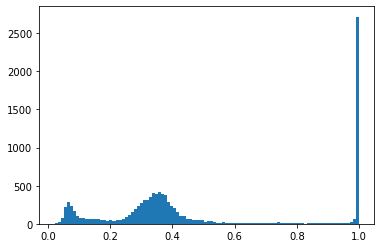

In [63]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [64]:
#%debug

In [65]:
#=====

# Predict and submit

In [66]:
%reload_ext autoreload
%autoreload 2
from src import tta_util

In [67]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None, tta_ops=[0]):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    LOGGER.info(f"tta_ops: {str(tta_ops)}")
    preds = []
    preds2 = []  # for MultiOutput
    preds3 = []  # for MultiOutput2,3
    for i, (images, _, _,) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None
        outputs2 = 0
        outputs3 = 0
        with torch.no_grad():
            
            for _ops in tta_ops:
                
                if "MultiOutput" in CFG.model_cls:
                    if (CFG.model_cls == "CustomModelMultiOutput2") or (CFG.model_cls == "CustomModelMultiOutput3"):
                        o, o2, o3 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput2,3
                    else:
                        o, o2 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                        o3 = 0
                else:
                    o = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                    o2, o3 = 0, 0
                
                if outputs is None:
                    outputs = o
                    outputs2 = o2
                    outputs3 = o3
                else:
                    outputs += o
                    outputs2 += o2
                    outputs3 += o3
        outputs /= len(tta_ops)
        outputs2 /= len(tta_ops)
        outputs3 /= len(tta_ops)
        
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        if "CustomModelMultiOutput" in CFG.model_cls:
            preds2.append(outputs2.argmax(1).cpu().detach().numpy())  # for MultiOutput
        if CFG.model_cls == "CustomModelMultiOutput2":
            preds3.append(outputs3.sigmoid().cpu().detach().numpy())  # for MultiOutput2
        elif CFG.model_cls == "CustomModelMultiOutput3":
            preds3.append(outputs3.argmax(1).cpu().detach().numpy())  # for MultiOutput3
    
    predictions = np.concatenate(preds)
    # for MultiOutput
    if len(preds2) == 0:
        predictions2 = None
    else:
        predictions2 = np.concatenate(preds2) 
    if len(preds3) == 0:
        predictions3 = None
    else:
        predictions3 = np.concatenate(preds3)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    #return predictions, predictions2
    return predictions, predictions2, predictions3  # for MultiOutput2,3

In [68]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None, tta_ops=[0], is_cr=False):
    model = eval(CFG.model_cls)(CFG)
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    #add_ch_type=CFG.add_ch_type,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    LOGGER.info(f'========== TEST ==========')  # for MultiOutput
    for i, pth in enumerate(pths):
        print("pth:", pth)
        
        #p, p2 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput
        p, p2, p3 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput2,3
        # 各foldの予測個別で持つ
        test[f'preds_fold{i}'] = p
        # for MultiOutput
        if "CustomModelMultiOutput" in CFG.model_cls:
            test[f'preds_freq_min//N_fold{i}'] = p2
            score2 = accuracy_score(test["freq_min//N"].to_numpy(), p2)
            LOGGER.info(f'freq_min//N {str(Path(pth).stem)} Accuracy: {score2:<.4f}')
            if is_cr:
                LOGGER.info(classification_report(test["freq_min//N"].to_numpy(), p2))
        if CFG.model_cls == "CustomModelMultiOutput2":
            test[f'preds_real_sim_fold{i}'] = p3
            score3 = get_score(test["real_sim"].to_numpy(), p3)
            LOGGER.info(f'real_sim {str(Path(pth).stem)} AUC: {score3:<.4f}')
        elif CFG.model_cls == "CustomModelMultiOutput3":
            test[f'preds_h0deg//10_fold{i}'] = p3
            #score3 = accuracy_score(test["h0deg//10"].to_numpy(), p3)  # testに h0deg//10 は無いのでコメントアウト
            #LOGGER.info(classification_report(test["h0deg//10"].to_numpy(), p3))  # testに h0deg//10 は無いのでコメントアウト
        
        if predictions is None:
            predictions = p
        else:
            predictions += p

    test['preds'] = predictions / len(pths)
    
    return test

In [69]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [70]:
# ==========================================================
# valid inference
# ==========================================================
def _run_valid_tta(tta_ops):
    seed = CFG.seeds[0]
    valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

    # tta inference
    score_list = []
    pred_valid = pd.DataFrame()
    for fold in CFG.trn_fold:
        print(f"===== valid fold{fold} =====")

        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
        print(pths)

        valid_f = valid[valid.fold == fold]
        print(valid_f.shape)

        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops, is_cr=False)

        ## =============================
        ## tta alb
        ## =============================
        #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        ## =============================
        ## tta Dataset
        ## =============================
        #_test_dataset = TrainDataset(valid_f, 
        #                             transforms=get_transforms(data="valid"),
        #                             #prob_spec_start_random=1.0,
        #                             #prob_vshift=1.0,  # CV悪化
        #                             prob_swap_nega=1.0,  # CV悪化
        #                             is_npy=CFG.is_npy,
        #                             add_ch_type=CFG.add_ch_type,
        #                           )
        #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
        #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
        #
        #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
        ## =============================

        score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
        score_list.append(score)
        pred_valid = pd.concat([pred_valid, valid_f])

    LOGGER.info(f"macro mean folds Score ± std: {str(round(np.mean(score_list), 4))} ± {str(round(np.std(score_list), 4))}")
    tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
    pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
    display(pred_valid.head())

    #if CFG.is_wandb:
    #    # save log wandb
    #    wandb.log({f"TTA oof Score": tta_oof_score})

In [71]:
_run_valid_tta([0,1,2])
_run_valid_tta([0,1])
_run_valid_tta([0,2])
_run_valid_tta([0])
_run_valid_tta([0,8])
_run_valid_tta([0,1,2,8])

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.20it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1959
TTA fold0 Score: 0.8953


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.20it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1941
TTA fold1 Score: 0.9136


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.20it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1899
TTA fold2 Score: 0.8981


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.19it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1650
TTA fold3 Score: 0.8951


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:19<00:00,  1.20it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1696
TTA fold4 Score: 0.9011
macro mean folds Score ± std: 0.9007 ± 0.0068
TTA oof Score: 0.8981


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.994620   
12        NaN        NaN         NaN            NaN       NaN     0.275624   
17        NaN        NaN         NaN            NaN       NaN     0.999827   
18        NaN        NaN         NaN            NaN       NaN     0.997955   
32        NaN        NaN         NaN            NaN       NaN     0.999899   

    preds_freq_min//N_fold0     preds  
5                         5  0.994620  
12                        3  0.275624  
17                        1  0.999827  
18                        1  0.997955  
32                        9  0.999899

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.78it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1969
TTA fold0 Score: 0.8942


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.78it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1885
TTA fold1 Score: 0.9136


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.78it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1913
TTA fold2 Score: 0.8975


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.75it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1673
TTA fold3 Score: 0.8956


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.79it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1673
TTA fold4 Score: 0.9016
macro mean folds Score ± std: 0.9005 ± 0.007
TTA oof Score: 0.8980


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.995791   
12        NaN        NaN         NaN            NaN       NaN     0.267913   
17        NaN        NaN         NaN            NaN       NaN     0.999601   
18        NaN        NaN         NaN            NaN       NaN     0.997314   
32        NaN        NaN         NaN            NaN       NaN     0.999887   

    preds_freq_min//N_fold0     preds  
5                         5  0.995791  
12                        3  0.267913  
17                        1  0.999601  
18                        1  0.997314  
32                        9  0.999887

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.77it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.2015
TTA fold0 Score: 0.8962


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.77it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1908
TTA fold1 Score: 0.9139


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.78it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1885
TTA fold2 Score: 0.8984


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.79it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1668
TTA fold3 Score: 0.8958


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.79it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1636
TTA fold4 Score: 0.9009
macro mean folds Score ± std: 0.901 ± 0.0067
TTA oof Score: 0.8982


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.993041   
12        NaN        NaN         NaN            NaN       NaN     0.307509   
17        NaN        NaN         NaN            NaN       NaN     0.999881   
18        NaN        NaN         NaN            NaN       NaN     0.998133   
32        NaN        NaN         NaN            NaN       NaN     0.999917   

    preds_freq_min//N_fold0     preds  
5                         5  0.993041  
12                        3  0.307509  
17                        1  0.999881  
18                        1  0.998133  
32                        9  0.999917

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.40it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1964
TTA fold0 Score: 0.8944


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.47it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1876
TTA fold1 Score: 0.9137


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.42it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1904
TTA fold2 Score: 0.8978


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.31it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1710
TTA fold3 Score: 0.8950


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.43it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1613
TTA fold4 Score: 0.9008
macro mean folds Score ± std: 0.9003 ± 0.0071
TTA oof Score: 0.8974


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.994486   
12        NaN        NaN         NaN            NaN       NaN     0.324047   
17        NaN        NaN         NaN            NaN       NaN     0.999565   
18        NaN        NaN         NaN            NaN       NaN     0.997059   
32        NaN        NaN         NaN            NaN       NaN     0.999912   

    preds_freq_min//N_fold0     preds  
5                         5  0.994486  
12                        3  0.324047  
17                        1  0.999565  
18                        1  0.997059  
32                        9  0.999912

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.76it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1825
TTA fold0 Score: 0.8988


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.78it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1848
TTA fold1 Score: 0.9151


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.79it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1908
TTA fold2 Score: 0.8988


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.76it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1710
TTA fold3 Score: 0.8965


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.78it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1622
TTA fold4 Score: 0.8993
macro mean folds Score ± std: 0.9017 ± 0.0068
TTA oof Score: 0.8990


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.996782   
12        NaN        NaN         NaN            NaN       NaN     0.333737   
17        NaN        NaN         NaN            NaN       NaN     0.998993   
18        NaN        NaN         NaN            NaN       NaN     0.997841   
32        NaN        NaN         NaN            NaN       NaN     0.999855   

    preds_freq_min//N_fold0     preds  
5                         5  0.996782  
12                        2  0.333737  
17                        1  0.998993  
18                        2  0.997841  
32                        9  0.999855

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.11s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1931
TTA fold0 Score: 0.8981


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1904
TTA fold1 Score: 0.9149


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1969
TTA fold2 Score: 0.8993


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1682
TTA fold3 Score: 0.8969


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1654
TTA fold4 Score: 0.9009
macro mean folds Score ± std: 0.902 ± 0.0066
TTA oof Score: 0.8992


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.995865   
12        NaN        NaN         NaN            NaN       NaN     0.291820   
17        NaN        NaN         NaN            NaN       NaN     0.999669   
18        NaN        NaN         NaN            NaN       NaN     0.998081   
32        NaN        NaN         NaN            NaN       NaN     0.999875   

    preds_freq_min//N_fold0     preds  
5                         5  0.995865  
12                        3  0.291820  
17                        1  0.999669  
18                        1  0.998081  
32                        9  0.999875

In [72]:
#%debug

In [73]:
#=====

In [74]:
def _run_test_tta(tta_ops):
    if IS_MAKE_SUB:
        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
        print(pths)

        # 'h0deg//10'列無いとエラーになるので入れとく
        test_df['h0deg//10'] = 0

        # ==========================================================
        # test inference
        # ==========================================================
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        #submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
        submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops)

        ## =============================
        ## tta alb
        ## =============================
        #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
        #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        submit["target"] = submit["preds"].to_numpy()
        display(submit.head())
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)

        submit = submit[["id", "target"]]
        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

        # Write prediction
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
        display(submit)

        plt.hist(submit["target"], bins=100)
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:09<00:00,  1.22it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1964


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:09<00:00,  1.21it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.2004


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:09<00:00,  1.21it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1975


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:09<00:00,  1.21it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1668


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:09<00:00,  1.20it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1832


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.294138   
1  1.248537e+09         42746.0  0.482649   
2  1.248567e+09         55878.0  0.259227   
3  1.248537e+09         48020.0  0.865931   
4  1.248543e+09         45246.0  0.760766   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.278700   
1         0          2.0    4.503615   0.799438          0     0.501588   
2         0          3.0    4.500148   0.800086          0     0.275511   
3         0          1.0    4.502120   0.799486          0     0.908247   
4         0          9.0    4.500598   0.802849          0     0.850884   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.316782                        6     0.321503   
1                        1     0.449407                        6     0.592867   
2                        3     0.272710                        6     0.247232   
3                        2     0.912312                        2     0.885271   
4                        2     0.962063                        2     0.950021   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.254758                        6     0.298947   
1                        1     0.491556                        2     0.377827   
2                        6     0.264819                        4     0.235863   
3                        2     0.751454                        2     0.872372   
4                        2     0.601131                        2     0.439733   

   preds_freq_min//N_fold4     preds  
0                        6  0.294138  
1                      

target range [0.133128, 0.999744]


id    target
0     00054c878  0.294138
1     0007285a3  0.482649
2     00076c5a6  0.259227
3     001349290  0.865931
4     001a52e92  0.760766
...         ...       ...
7970  ffbce04ef  0.994924
7971  ffc2d976b  0.296450
7972  ffc905909  0.231681
7973  ffe276f3e  0.267997
7974  fffa17f67  0.249741

[7975 rows x 2 columns]

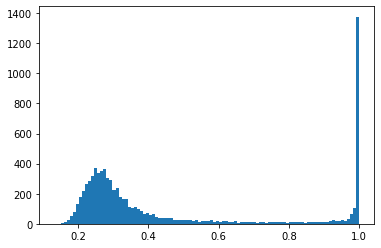

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1992


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1999


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1990


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1661


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1792


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.298175   
1  1.248537e+09         42746.0  0.470165   
2  1.248567e+09         55878.0  0.259226   
3  1.248537e+09         48020.0  0.858198   
4  1.248543e+09         45246.0  0.785040   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.280084   
1         0          2.0    4.503615   0.799438          0     0.453691   
2         0          3.0    4.500148   0.800086          0     0.265659   
3         0          1.0    4.502120   0.799486          0     0.903110   
4         0          9.0    4.500598   0.802849          0     0.871758   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.323784                        6     0.330748   
1                        1     0.478472                        3     0.600728   
2                        3     0.288362                        6     0.236218   
3                        2     0.905069                        2     0.899668   
4                        2     0.961703                        2     0.967100   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.245796                        6     0.310462   
1                        1     0.441990                        2     0.375945   
2                        6     0.269932                        4     0.235960   
3                        2     0.710116                        2     0.873027   
4                        2     0.700587                        2     0.424055   

   preds_freq_min//N_fold4     preds  
0                        6  0.298175  
1                      

target range [0.134173, 0.999793]


id    target
0     00054c878  0.298175
1     0007285a3  0.470165
2     00076c5a6  0.259226
3     001349290  0.858198
4     001a52e92  0.785040
...         ...       ...
7970  ffbce04ef  0.995696
7971  ffc2d976b  0.306931
7972  ffc905909  0.229772
7973  ffe276f3e  0.265097
7974  fffa17f67  0.245957

[7975 rows x 2 columns]

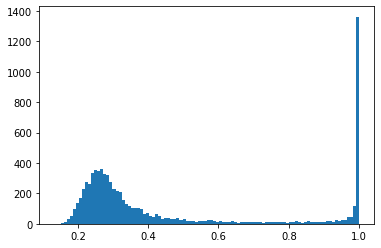

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1961


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.2018


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1989


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.80it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1682


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.80it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1806


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.290060   
1  1.248537e+09         42746.0  0.492619   
2  1.248567e+09         55878.0  0.263090   
3  1.248537e+09         48020.0  0.870034   
4  1.248543e+09         45246.0  0.759274   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.274883   
1         0          2.0    4.503615   0.799438          0     0.532387   
2         0          3.0    4.500148   0.800086          0     0.296419   
3         0          1.0    4.502120   0.799486          0     0.894110   
4         0          9.0    4.500598   0.802849          0     0.844277   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.305557                        6     0.317307   
1                        1     0.439018                        6     0.586037   
2                        7     0.266045                        6     0.251012   
3                        1     0.928770                        2     0.894555   
4                        1     0.971445                        2     0.944742   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.263415                        6     0.289136   
1                        1     0.503339                        2     0.402311   
2                        6     0.257922                        4     0.244050   
3                        2     0.764187                        2     0.868550   
4                        2     0.580496                        2     0.455408   

   preds_freq_min//N_fold4     preds  
0                        6  0.290060  
1                      

target range [0.131586, 0.999723]


id    target
0     00054c878  0.290060
1     0007285a3  0.492619
2     00076c5a6  0.263090
3     001349290  0.870034
4     001a52e92  0.759274
...         ...       ...
7970  ffbce04ef  0.993002
7971  ffc2d976b  0.292527
7972  ffc905909  0.231560
7973  ffe276f3e  0.259386
7974  fffa17f67  0.252129

[7975 rows x 2 columns]

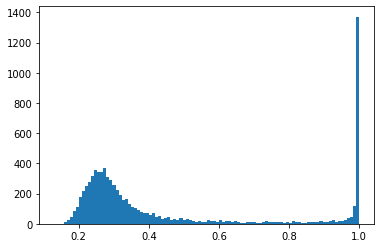

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:23<00:00,  3.58it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1957


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:23<00:00,  3.58it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1995


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:23<00:00,  3.57it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1962


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:23<00:00,  3.55it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1659


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:23<00:00,  3.57it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1773


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.293823   
1  1.248537e+09         42746.0  0.477712   
2  1.248567e+09         55878.0  0.266750   
3  1.248537e+09         48020.0  0.856858   
4  1.248543e+09         45246.0  0.804936   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.273823   
1         0          2.0    4.503615   0.799438          0     0.467263   
2         0          3.0    4.500148   0.800086          0     0.296959   
3         0          1.0    4.502120   0.799486          0     0.864613   
4         0          9.0    4.500598   0.802849          0     0.879674   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.308099                        6     0.331515   
1                        1     0.486647                        6     0.595011   
2                        7     0.290386                        6     0.232686   
3                        1     0.932075                        2     0.926450   
4                        2     0.978141                        2     0.973526   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.253747                        6     0.301928   
1                        1     0.416265                        2     0.423374   
2                        6     0.261089                        4     0.252631   
3                        2     0.695147                        2     0.866006   
4                        2     0.753854                        2     0.439487   

   preds_freq_min//N_fold4     preds  
0                        6  0.293823  
1                      

target range [0.132145, 0.999755]


id    target
0     00054c878  0.293823
1     0007285a3  0.477712
2     00076c5a6  0.266750
3     001349290  0.856858
4     001a52e92  0.804936
...         ...       ...
7970  ffbce04ef  0.993606
7971  ffc2d976b  0.309572
7972  ffc905909  0.227613
7973  ffe276f3e  0.245057
7974  fffa17f67  0.247043

[7975 rows x 2 columns]

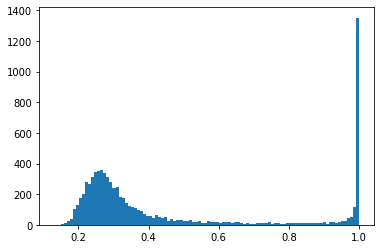

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1902


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1961


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.79it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1944


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.82it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1636


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [00:46<00:00,  1.81it/s]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1749


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.279582   
1  1.248537e+09         42746.0  0.687180   
2  1.248567e+09         55878.0  0.270828   
3  1.248537e+09         48020.0  0.821418   
4  1.248543e+09         45246.0  0.774258   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.251972   
1         0          2.0    4.503615   0.799438          0     0.634999   
2         0          3.0    4.500148   0.800086          0     0.296742   
3         0          1.0    4.502120   0.799486          0     0.839009   
4         0          9.0    4.500598   0.802849          0     0.787051   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.315189                        6     0.300271   
1                        1     0.785730                        2     0.701466   
2                        7     0.291762                        4     0.247443   
3                        1     0.918742                        2     0.898545   
4                        1     0.949999                        1     0.914538   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.240116                        6     0.290361   
1                        1     0.798540                        2     0.515166   
2                        6     0.255326                        4     0.262864   
3                        2     0.601054                        2     0.849738   
4                        2     0.762822                        2     0.456879   

   preds_freq_min//N_fold4     preds  
0                        6  0.279582  
1                      

target range [0.135609, 0.999792]


id    target
0     00054c878  0.279582
1     0007285a3  0.687180
2     00076c5a6  0.270828
3     001349290  0.821418
4     001a52e92  0.774258
...         ...       ...
7970  ffbce04ef  0.994829
7971  ffc2d976b  0.294780
7972  ffc905909  0.231779
7973  ffe276f3e  0.237292
7974  fffa17f67  0.268236

[7975 rows x 2 columns]

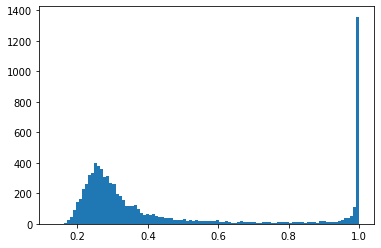

['./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:32<00:00,  1.11s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold0_seed0_best_score Accuracy: 0.1966


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:32<00:00,  1.10s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold1_seed0_best_score Accuracy: 0.1977


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:32<00:00,  1.10s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold2_seed0_best_score Accuracy: 0.1999


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:31<00:00,  1.09s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold3_seed0_best_score Accuracy: 0.1649


pth: ./output/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise/kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2, 8]
100%|█████████████████████████████████████████████████████████████████████| 84/84 [01:32<00:00,  1.11s/it]
freq_min//N kqi_3090_ex075_v2_stride12_norm_lb0771_pseudo_th_5_10_addD_EX007_2_GaussNoise_fold4_seed0_best_score Accuracy: 0.1828


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.286870   
1  1.248537e+09         42746.0  0.592798   
2  1.248567e+09         55878.0  0.263069   
3  1.248537e+09         48020.0  0.847606   
4  1.248543e+09         45246.0  0.756475   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.266311   
1         0          2.0    4.503615   0.799438          0     0.577961   
2         0          3.0    4.500148   0.800086          0     0.280678   
3         0          1.0    4.502120   0.799486          0     0.889063   
4         0          9.0    4.500598   0.802849          0     0.811906   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.318174                        6     0.308355   
1                        1     0.624981                        2     0.648588   
2                        3     0.277734                        4     0.251069   
3                        2     0.910078                        2     0.879714   
4                        2     0.950112                        2     0.923625   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        6     0.247613                        6     0.293899   
1                        1     0.678698                        2     0.433764   
2                        6     0.260971                        4     0.244894   
3                        2     0.696067                        2     0.863105   
4                        2     0.648380                        2     0.448353   

   preds_freq_min//N_fold4     preds  
0                        6  0.286870  
1                      

target range [0.134562, 0.999732]


id    target
0     00054c878  0.286870
1     0007285a3  0.592798
2     00076c5a6  0.263069
3     001349290  0.847606
4     001a52e92  0.756475
...         ...       ...
7970  ffbce04ef  0.995144
7971  ffc2d976b  0.292297
7972  ffc905909  0.232742
7973  ffe276f3e  0.258011
7974  fffa17f67  0.259613

[7975 rows x 2 columns]

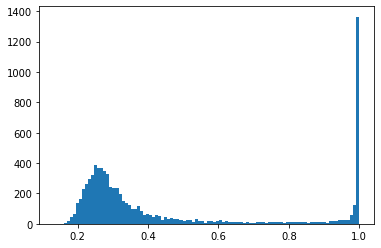

In [75]:
_run_test_tta([0,1,2])
_run_test_tta([0,1])
_run_test_tta([0,2])
_run_test_tta([0])
_run_test_tta([0,8])
_run_test_tta([0,1,2,8])

In [76]:
if CFG.is_wandb:
    wandb.finish()

In [77]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [78]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
#        transforms_type = 'valid_norm'
#    else:
#        transforms_type = 'valid'
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [79]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()